<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Umicore/Umicore_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UMI.BR"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02   7.03   7.44   6.95   7.44       4.26   603806
2009-01-05   7.49   7.62   7.41   7.61       4.36   898240
2009-01-06   7.60   7.97   7.41   7.97       4.56  1768962
2009-01-07   8.00   8.00   7.57   7.67       4.39  1631304
2009-01-08   7.61   7.61   7.37   7.57       4.33  1598838
...           ...    ...    ...    ...        ...      ...
2018-12-21  34.27  34.48  33.55  34.17      33.31  1479492
2018-12-24  33.63  35.00  33.55  34.78      33.90   209675
2018-12-27  35.40  35.54  34.15  34.42      33.55   770386
2018-12-28  34.63  35.36  34.52  34.68      33.81   762591
2018-12-31  34.92  35.13  34.50  34.86      33.98   172188

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     21.430477    21.679362    21.176193    21.432152    17.942954  9.747165e+05
std      10.030314    10.118951     9.916874    10.015215    10.944641  5.111359e+05
min       5.960000     6.140000     5.820000     5.940000     3.400000  4.523200e+04
25%      16.257500    16.425000    16.075000    16.257500    12.157500  6.405240e+05
50%      18.580000    18.810000    18.370000    18.580000    14.110000  8.613980e+05
75%      23.382500    23.622500    23.197500    23.477500    21.237500  1.166162e+06
max      53.600000    53.960000    52.700000    53.140000    51.420000  5.078146e+06

7

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13   6.80   6.93   6.43   6.48       3.71  1693962   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   6.448800   6.492769   5.916375   6.447791   6.412975   6.212124       6.330        6.43   5.982816   6.36500   6.577497   6.3230   6.420000   6.36500   6.556667   6.473049                6.850901                  6.36500                5.879099                7.093852                  6.36500                5.636148                7.336802                  6.36500                5.393198                7.579753                  6.36500                5.150247   6.412975   6.501960   6.420577                6.898876                 6.412975                5.927073                7.141826                 6.412975                5.684123                7.384777                 6.412975                5.441172                7.627728                 6.412975   
2009-03-16   6.61   6.82   6.49   6.57       3.76  1242332   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   6.454860   6.491821   5.977193   6.502089   6.447869   6.214050       6.330        6.43   6.058591   6.36250   6.618063   6.3970   6.465556   6.36250   6.525000   6.455405                6.843930                  6.36250                5.881070                7.084645                  6.36250                5.640355                7.325360                  6.36250                5.399640                7.566075                  6.36250                5.158925   6.447869   6.550944   6.411083                6.929299                 6.447869                5.966439                7.170014                 6.447869                5.725724                7.410729                 6.447869                5.485009                7.651445                 6.447869   
2009-03-17   6.51   6.72   6.42   6.47       

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     21.719409    21.969669    21.464397    21.721137    18.221616  9.596659e+05    15.774142     1.998404   186.245810      30.462889      0.032721        0.027933        0.009976          0.007981     6.625698     2.540702    27.029928     1.998404      2.012769    27.029928    21.664686    21.571503     0.905167    21.721693    21.681370    21.637334    21.675545    21.661504    21.575361    21.681679    21.721122    21.681716    21.694864    21.681679    21.710160    21.600154               22.446160                21.681679               20.917198               22.828400                21.681679               20.534958               23.210640                21.681679               20.152718               23.592881                21.681679               19.770477    21.681370    21.711828    21.612587               22.445851                21.681370               20.916890               22.828091                21.681370               20.534649               23.210332   
std       9.916638    10.006052     9.800697     9.900951    10.872104  5.003799e+05     8.732031     1.408556   103.650851       0.785865      0.177942        0.164814        0.099401          0.088996     3.396541     1.106387    14.824654     1.408556      1.412461    14.824654     9.851290     9.821639    23.794347     9.905623     9.888571     9.876716     9.900168     9.893938     9.928526     9.894208     9.903348     9.896740     9.894421     9.894208     9.895715     9.880107               10.216705                 9.894208                9.594194               10.385735                 9.894208                9.453294               10.559624                 9.894208                9.318835               10.738136                 9.894208                9.191101     9.888571     9.895790     9.882699               10.211850                 9.888571                9.587736               10.381258                 9.888571                9.446412               10.555513   
min       6.510000     6.670000     6.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.006158  0.005498  0.003446  0.000857   0.000419  1693962   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000206  0.572638  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000055  0.000829  0.000000  0.000000  0.000055  0.001359  0.000800                0.003750                 0.000055                0.000000                0.007281                 0.000055                0.000000                0.010640                 0.000055                0.001617                0.013423                 0.000055                0.009736  0.000000  0.000655  0.000275                0.005681                 0.000000                0.000000                0.009185                 0.000000                0.000000                0.012428                 0.000000                0.000000                0.015110                 0.000000   
2009-03-16  0.002124  0.003172  0.004738  0.002784   0.001467  1242332   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000132  0.000185  0.573220  0.001171  0.000763  0.000043    0.000000    0.000000  0.001579  0.000000  0.001702  0.001621  0.000994  0.000000  0.000679  0.000406                0.003601                 0.000000                0.000044                0.007089                 0.000000                0.000094                0.010407                 0.000000                0.001761                0.013159                 0.000000                0.009930  0.000763  0.001708  0.000064                0.006328                 0.000763                0.000881                0.009773                 0.000763                0.000938                0.012953                 0.000763                0.000994                0.015566                 0.000763   
2009-03-17  0.000000  0.001057  0.003231  0.000642  

140182

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 59 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_xxca9k
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  16.925376                   0.5  0.700028  0.490040
1  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  17.613400                   0.5  0.714115  0.509960
2  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  16.925376                   0.5  0.700028  0.490040
3  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  17.613400                   0.5  0.714115  0.509960
4  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  16.925376                   0.5  0.700028  0.490040
5              DeepLearning_1_AutoML_20190825_160248  0.5  17.613400                   0.5  0.714115  0.509960
6  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  17.613400                   0.5  0.714115  0.509960
7  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5   0.693067                   0.5  0.499960  0.249960
8  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5   0.698674                   0.5  0.502746  0.252754
9  DeepLearning_grid_1_AutoML_20190825_160248_mod...  0.5  17.613400                   0.5  0.714115  0.509960

variable  relative_importance  scaled_importance  percentage
0                       SAREXT             1.000000           1.000000    0.001346
1                 aroondown_12             0.993327           0.993327    0.001337
2                      weekday             0.972396           0.972396    0.001309
3                          OBV             0.936405           0.936405    0.001260
4                    dayofweek             0.935026           0.935026    0.001259
...                        ...                  ...                ...         ...
1037  BBANDS_middleband_12_1_4             0.620374           0.620374    0.000835
1038                   MA_14_0             0.619967           0.619967    0.000834
1039  BBANDS_middleband_14_1_2             0.616038           0.616038    0.000829
1040       CDLXSIDEGAP3METHODS             0.602761           0.602761    0.000811
1041              CDLTASUKIGAP             0.587707           0.587707    0.000791

[1042 rows x 4 columns]

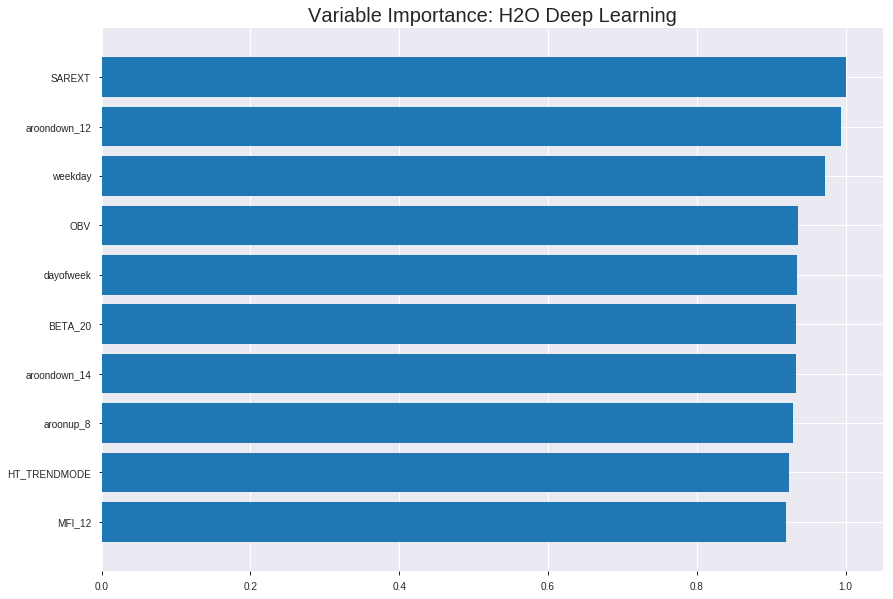

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_160248_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24590495590183495
RMSE: 0.4958880477505331
LogLoss: 0.6844047616207054
Mean Per-Class Error: 0.459233036040265
AUC: 0.5468960256610859
pr_auc: 0.5846362276418052
Gini: 0.09379205132217172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4016515711165554: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      21   819   0.975    (819.0/840.0)
1      1    912   0.0011   (1.0/913.0)
Total  22   1731  0.4678   (820.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401652     0.689864  378
max f2                       0.401652     0.847111  378
max f0point5                 0.498398     0.582531  365
max accuracy                 0.504974     0.533942  361
max precision                0.98578      1         0
max recall                   0.369158     1         384
max specificity              0.98578      1         0
max absolute_mcc             0.545172     0.108302  236
max min_per_class_accuracy   0.50527      0.306681  359
max mean_per_class_accuracy  0.538532     0.540767  250

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.859553           1.70671   1.70671            0.888889         0.911202  0.888889                    0.911202            0.0175246       0.0175246                  70.6706   70.6706
    2        0.0205362                   0.808551           1.28003   1.49337            0.666667         0.828906  0.777778                    0.870054            0.0131435       0.0306681                  28.0029   49.3367
    3        0.0302339                   0.772253           1.12944   1.37664            0.588235         0.790607  0.716981                    0.844571            0.0109529       0.041621                   12.9438   37.6635
    4        0.040502                    0.712088           1.28003   1.35214            0.666667         0.74317   0.704225                    0.818864            0.0131435       0.0547645                  28.0029   35.2144
    5        0.0501997                   0.681146           1.01649   1.2873             0.529412         0.696688  0.670455                    0.795262            0.00985761      0.0646221                  1.64938   28.7302
    6        0.100399                    0.589321           1.15639   1.22185            0.602273         0.627692  0.636364                    0.711477            0.0580504       0.122673                   15.639    22.1846
    7        0.150029                    0.552029           1.19175   1.21189            0.62069          0.566027  0.631179                    0.663362            0.0591457       0.181818                   19.1751   21.1891
    8        0.200228                    0.527622           1.0473    1.17063            0.545455         0.538788  0.609687                    0.63213             0.0525739       0.234392                   4.72966   17.0625
    9        0.977752                    0.504974           0.973404  1.01379            0.50697          0.506107  0.528005                    0.531915            0.756846        0.991238                   -2.65955  1.37921
    10       1                           0.114042           0.393855  1                  0.205128         0.359644  0.520821                    0.528082            0.00876232      1                          -60.6145  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.36050519323510455
RMSE: 0.6004208467692511
LogLoss: 6.040458594126171
Mean Per-Class Error: 0.46753903990746104
AUC: 0.5182105905790116
pr_auc: 0.5655375511161005
Gini: 0.036421181158023286
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.286549767336108e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.28655e-50  0.705426   201
max f2                       4.28655e-50  0.856874   201
max f0point5                 4.28655e-50  0.599473   201
max accuracy                 4.28655e-50  0.54491    201
max precision                0.810178     1          0
max recall                   4.28655e-50  1          201
max specificity              0.810178     1          0
max absolute_mcc             0.768359     0.0709303  2
max min_per_class_accuracy   0.406792     0.512821   52
max mean_per_class_accuracy  0.259616     0.532461   90

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 29.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.657979           1.22344   1.22344            0.666667         0.739602     0.666667                    0.739602            0.014652        0.014652                   22.3443    22.3443
    2        0.0219561                   0.615794           0.734066  1.001              0.4              0.620463     0.545455                    0.685448            0.00732601      0.021978                   -26.5934   0.0999001
    3        0.0319361                   0.519412           1.1011    1.03228            0.6              0.566722     0.5625                      0.648346            0.010989        0.032967                   10.1099    3.22802
    4        0.0419162                   0.510359           1.46813   1.13605            0.8              0.514632     0.619048                    0.616509            0.014652        0.047619                   46.8132    13.6054
    5        0.443114                    0.504974           1.04084   1.04985            0.567164         0.505035     0.572072                    0.51558             0.417582        0.465201                   4.08398    4.98465
    6        0.500998                    0.397753           0.82266   1.0236             0.448276         0.449201     0.557769                    0.507911            0.047619        0.512821                   -17.734    2.35979
    7        0.600798                    0.208673           0.990989  1.01818            0.54             0.295552     0.554817                    0.472635            0.0989011       0.611722                   -0.901099  1.81812
    8        0.700599                    1.74867e-06        0.880879  0.998622           0.48             0.0694579    0.54416                     0.415203            0.0879121       0.699634                   -11.9121   -0.137754
    9        0.800399                    6.88972e-58        0.954286  0.993094           0.52             3.94524e-08  0.541147                    0.363432            0.0952381       0.794872                   -4.57143   -0.690581
    10       1                           0                  1.02769   1                  0.56             6.16913e-61  0.54491                     0.29089             0.205128        1                          2.76923    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:12:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:12:29  4 min 18.504 sec  308 obs/sec       0.402738  1             706        0.705496         6.07043             -0.994355      0.463793        0.406068           0.853353         0.479179                         0.701156           12.2097               -0.982473        0.499807          0.300362             1.04867            0.45509
    2019-08-25 16:12:58  4 min 48.012 sec  364 obs/sec       6.00742   15            10531      0.496212         0.687384            0.0133852      0.581122        0.591171           1.28003          0.46891                          0.640234           7.33133               -0.652935        0.519496          0.565283             0.917582           0.45509
    2019-08-25 16:13:28  5 min 17.488 sec  429 obs/sec       13.5973   34            23836      0.495888         0.684405            0.0146715      0.546896        0.584636           1.70671          0.46777                          0.600421           6.04046               -0.453749        0.518211          0.565538             1.22344            0.45509
    2019-08-25 16:13:57  5 min 46.307 sec  464 obs/sec       21.5682   54            37809      0.491224         0.673173            0.0331189      0.538413        0.609702           1.92004          0.463206                         0.618747           6.90162               -0.543847        0.514636          0.555094             1.22344            0.45509
    2019-08-25 16:14:26  6 min 16.089 sec  508 obs/sec       31.4604   79            55150      0.48871          0.666748            0.0429909      0.568581        0.649187           1.92004          0.462065                         0.614862           6.44655               -0.52452         0.514347          0.556381             0.917582           0.45509
    2019-08-25 16:14:55  6 min 44.928 sec  535 obs/sec       41.0428   103           71948      0.484854         0.658075            0.0580347      0.6123          0.674593           1.92004          0.44267                          0.660168           7.68337               -0.757466        0.511383          0.549757             0.611722           0.45509
    2019-08-25 16:15:24  7 min 14.055 sec  566 obs/sec       51.8734   130           90934      0.489629         0.666823            0.039387       0.616452        0.667459           1.92004          0.440958                         0.70137            9.19752               -0.983682        0.517849          0.568228             0.917582           0.45509
    2019-08-25 16:15:54  7 min 43.757 sec  585 obs/sec       62.6406   157           109809     0.477827         0.640386            0.085139       0.63695         0.701675           1.92004          0.446663                         0.670589           9.47949               -0.813388        0.508049          0.554149             0.917582           0.45509
    2019-08-25 16:15:57  7 min 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
SAREXT                    1.0                    1.0                  0.0013459661156082828
aroondown_12              0.9933272004127502     0.9933272004127502   0.0013369847534675998
weekday                   0.9723957777023315     0.9723957777023315   0.0013088117677479024
OBV                       0.9364053010940552     0.9364053010940552   0.00126036980574857
dayofweek                 0.935026228427887      0.935026228427887    0.0012585136206689459
---                       ---                    ---                  ---
BBANDS_middleband_12_1_4  0.6203739643096924     0.6203739643096924   0.0008350023349664281
MA_14_0                   0.619966983795166      0.619966983795166    0.0008344545529841628
BBANDS_middleband_14_1_2  0.6160380840301514     0.6160380840301514   0.0008291663870288317
CDLXSIDEGAP3METHODS       0.6027607917785645     0.6027607917785645   0.0008112956015511673
CDLTASUKIGAP              0.5877069234848022     0.5877069234848022   0.0007910336049189335


See the whole table with table.as_data_frame()


('accuracy', 0.4900398406374502)

('F1', 0.6577540106951871)

('auc', 0.5)

('logloss', 16.925376480374545)

('mean_per_class_error', 0.5)

('rmse', 0.7000284570197487)

('mse', 0.4900398406374502)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


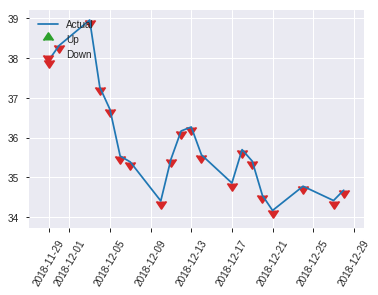


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4900398406374502
RMSE: 0.7000284570197487
LogLoss: 16.925376480374545
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2251335647477786e-270: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    123  0        (0.0/123.0)
Total  0    251  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold     value     idx
---------------------------  ------------  --------  -----
max f1                       2.22513e-270  0.657754  0
max f2                       2.22513e-270  0.827725  0
max f0point5                 2.22513e-270  0.545697  0
max accuracy                 2.22513e-270  0.49004   0
max precision                2.22513e-270  0.49004   0
max recall                   2.22513e-270  1         0
max specificity              2.22513e-270  0         0
max absolute_mcc             2.22513e-270  0         0
max min_per_class_accuracy   2.22513e-270  0         0
max mean_per_class_accuracy  2.22513e-270  0.5       0

Gains/Lift Table: Avg response rate: 49.00 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.49004          2.22513e-270  0.49004                     2.22513e-270        1               1                          0       0

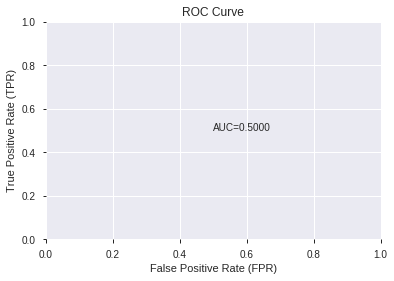

This function is available for GLM models only


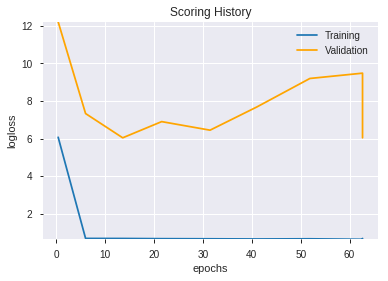

--2019-08-25 16:37:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_160248_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_160248_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_163850_model_9  0.578538  0.691836              0.416127  0.499344  0.249345
1  DeepLearning_grid_1_AutoML_20190825_163850_model_8  0.544779  0.700190              0.488281  0.503481  0.253493
2  DeepLearning_grid_1_AutoML_20190825_163850_model_6  0.543826  0.697995              0.450489  0.501541  0.251543
3  DeepLearning_grid_1_AutoML_20190825_163850_model_5  0.540777  0.706089              0.484534  0.506201  0.256239
4  DeepLearning_grid_1_AutoML_20190825_163850_model_3  0.532584  0.877893              0.488281  0.554396  0.307355
5  DeepLearning_grid_1_AutoML_20190825_163850_model_1  0.523438  1.286096              0.480628  0.609655  0.371680
6  DeepLearning_grid_1_AutoML_20190825_163850_model_4  0.512640  1.096290              0.500000  0.595035  0.354066
7  DeepLearning_grid_1_AutoML_20190825_163850_model_7  0.499111  0.897475              0.461731  0.563598  0.317643
8               DeepLearning_1_AutoML_20190825_163850  0.492442  0.846822              0.496094  0.554324  0.307275
9  DeepLearning_grid_1_AutoML_20190825_163850_model_2  0.492060  0.986763              0.480945  0.581926  0.338638

variable  relative_importance  scaled_importance  percentage
0                NATR_24             1.000000           1.000000    0.022507
1         STOCHRSI_fastk             0.974702           0.974702    0.021938
2                BETA_20             0.969502           0.969502    0.021821
3                    OBV             0.951957           0.951957    0.021426
4                  DX_12             0.935295           0.935295    0.021051
5                 MFI_12             0.931689           0.931689    0.020970
6         STOCHRSI_fastd             0.928865           0.928865    0.020906
7           HT_TRENDMODE             0.922770           0.922770    0.020769
8                quarter             0.922202           0.922202    0.020756
9                 MFI_14             0.920892           0.920892    0.020727
10                ADX_14             0.914118           0.914118    0.020574
11           aroondown_8             0.913581           0.913581    0.020562
12                   BOP             0.913188           0.913188    0.020553
13                ADXR_8             0.911073           0.911073    0.020506
14                  DX_8             0.907676           0.907676    0.020429
15               BETA_12             0.907113           0.907113    0.020417
16          STOCHF_fastk             0.906620           0.906620    0.020406
17             dayofweek             0.905894           0.905894    0.020389
18                   SIN             0.903359           0.903359    0.020332
19                  week             0.900512           0.900512    0.020268
20                BETA_8             0.899205           0.899205    0.020239
21               weekday             0.894737           0.894737    0.020138
22            aroonup_14             0.892946           0.892946    0.020098
23          aroondown_14             0.891604           0.891604    0.020068
24              CORREL_8             0.888817           0.888817    0.020005
25                 month             0.888814           0.888814    0.020005
26                ADX_24             0.888675           0.888675    0.020002
27        CDLRICKSHAWMAN             0.880581           0.880581    0.019820
28          MACDEXT_hist             0.880524           0.880524    0.019818
29            PLUS_DI_20             0.880364           0.880364    0.019815
30             aroonup_8             0.876300           0.876300    0.019723
31               BETA_24             0.874849           0.874849    0.019691
32  HT_PHASOR_quadrature             0.872461           0.872461    0.019637
33               CDLDOJI             0.870882           0.870882    0.019601
34          aroondown_24             0.869630           0.869630    0.019573
35               ADXR_12             0.866253           0.866253    0.019497
36               BETA_30             0.862085           0.862085    0.019403
37               ADXR_14             0.858690           0.858690    0.019327
38           AROONOSC_30             0.855350           0.855350    0.019252
39            aroonup_30             0.853631           0.853631    0.019213
40                ADX_20             0.851973           0.851973    0.019176
41            AROONOSC_8             0.851945           0.851945    0.019175
42            aroonup_20             0.847771           0.847771    0.019081
43          weekday_name             0.843036           0.843036    0.018975
44               BETA_14             0.841593           0.841593    0.018942
45     CDLLONGLEGGEDDOJI             0.829892           0.829892    0.018679
46          aroondown_12             0.826403           0.826403    0.018600
47           AROONOSC_14             0.825627           0.825627    0.018583
48                SAREXT             0.818610           0.818610    0.018425
49            aroonup_24             0.805600           0.805600    0.018132

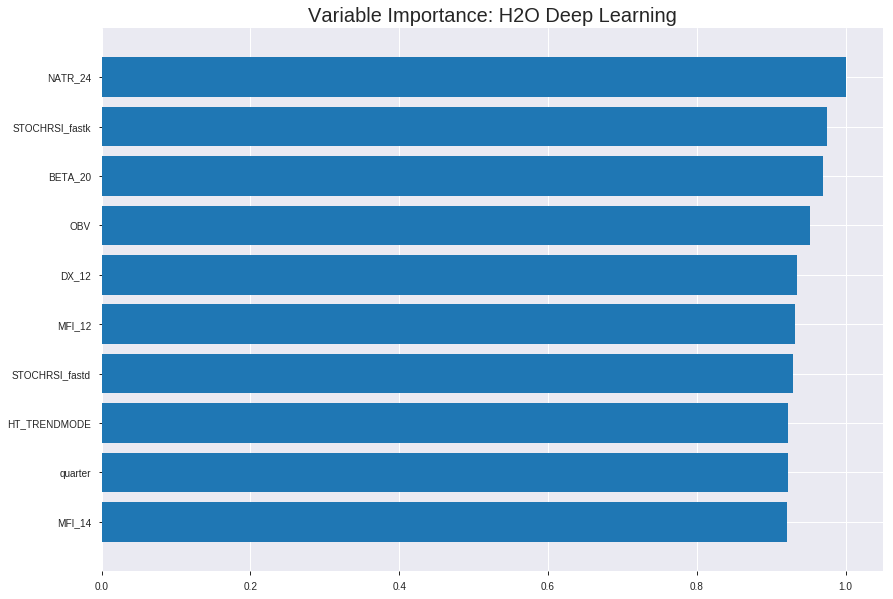

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_163850_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24974841863178843
RMSE: 0.4997483553067368
LogLoss: 0.6926437738884944
Mean Per-Class Error: 0.44851288269962963
AUC: 0.5666321128670526
pr_auc: 0.5760963472239019
Gini: 0.13326422573410523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4827991464053848: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   822   0.9786   (822.0/840.0)
1      9    904   0.0099   (9.0/913.0)
Total  27   1726  0.474    (831.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482799     0.685108  389
max f2                       0.482012     0.844588  399
max f0point5                 0.484913     0.587807  347
max accuracy                 0.486404     0.551055  319
max precision                0.518163     1         0
max recall                   0.482012     1         399
max specificity              0.518163     1         0
max absolute_mcc             0.492306     0.10461   209
max min_per_class_accuracy   0.49081      0.547645  237
max mean_per_class_accuracy  0.492306     0.551487  209

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 49.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.510895           1.17336   1.17336            0.611111         0.512771  0.611111                    0.512771            0.0120482       0.0120482                  17.336    17.336
    2        0.0205362                   0.507072           0.960022  1.06669            0.5              0.508741  0.555556                    0.510756            0.00985761      0.0219058                  -3.99781  6.6691
    3        0.0302339                   0.505403           1.58121   1.23173            0.823529         0.506328  0.641509                    0.509336            0.0153341       0.0372399                  58.1213   23.1726
    4        0.040502                    0.504344           1.3867    1.27101            0.722222         0.504868  0.661972                    0.508203            0.0142388       0.0514786                  38.6698   27.1015
    5        0.0501997                   0.503354           1.35533   1.2873             0.705882         0.503849  0.670455                    0.507362            0.0131435       0.0646221                  35.5325   28.7302
    6        0.100399                    0.500148           1.09093   1.18912            0.568182         0.501744  0.619318                    0.504553            0.0547645       0.119387                   9.0934    18.9118
    7        0.150029                    0.497822           1.0814    1.15349            0.563218         0.498889  0.60076                     0.502679            0.0536692       0.173056                   8.1404    15.3486
    8        0.200228                    0.496264           1.26548   1.18157            0.659091         0.496969  0.615385                    0.501248            0.0635268       0.236583                   26.5483   18.1565
    9        0.300057                    0.494125           1.00939   1.12428            0.525714         0.495084  0.585551                    0.499197            0.100767        0.337349                   0.939446  12.4284
    10       0.399886                    0.492456           1.09717   1.11751            0.571429         0.493281  0.582026                    0.49772             0.109529        0.446878                   9.71679   11.7515
    11       0.500285                    0.490796           1.00366   1.09467            0.522727         0.491617  0.570125                    0.496495            0.100767        0.547645                   0.365927  9.46658
    12       0.600114                    0.489187           0.910649  1.06405            0.474286         0.489994  0.554183                    0.495414            0.0909091       0.638554                   -8.93506  6.40547
    13       0.699943                    0.487625           0.921621  1.04374            0.48             0.488365  0.543602                    0.494408            0.0920044       0.730559                   -7.8379   4.37402
    14       0.799772                    0.485797           1.02037   1.04082            0.531429         0.486741  0.542083                    0.493451            0.101862        0.832421                   2.03661   4.08226
    15       0.899601                    0.483913           0.899678  1.02516            0.468571         0.484876  0.533925                    0.4925              0.0898138       0.922234                   -10.0322  2.51597
    16       1                           0.482012           0.774563  1                  0.403409         0.483258  0.520821                    0.491572           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25120055584000456
RMSE: 0.5011991179561318
LogLoss: 0.6955490581721303
Mean Per-Class Error: 0.47115384615384615
AUC: 0.503245292718977
pr_auc: 0.5575251400157859
Gini: 0.0064905854379539996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48225585728586: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482256     0.705426  399
max f2                       0.482256     0.856874  399
max f0point5                 0.482256     0.599473  399
max accuracy                 0.482256     0.54491   399
max precision                0.513172     1         0
max recall                   0.482256     1         399
max specificity              0.513172     1         0
max absolute_mcc             0.482534     0.116415  392
max min_per_class_accuracy   0.485935     0.498168  223
max mean_per_class_accuracy  0.488634     0.528846  130

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 48.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.509073           0.917582  0.917582           0.5              0.509933  0.5                         0.509933            0.010989        0.010989                   -8.24176   -8.24176
    2        0.0219561                   0.502608           0.734066  0.834166           0.4              0.504087  0.454545                    0.507276            0.00732601      0.018315                   -26.5934   -16.5834
    3        0.0319361                   0.498789           1.46813   1.03228            0.8              0.500609  0.5625                      0.505193            0.014652        0.032967                   46.8132    3.22802
    4        0.0419162                   0.497905           1.83516   1.22344            1                0.498105  0.666667                    0.503505            0.018315        0.0512821                  83.5165    22.3443
    5        0.0518962                   0.496769           1.1011    1.19992            0.6              0.49714   0.653846                    0.502281            0.010989        0.0622711                  10.1099    19.9915
    6        0.101796                    0.492692           1.02769   1.11549            0.56             0.494306  0.607843                    0.498372            0.0512821       0.113553                   2.76923    11.5492
    7        0.151697                    0.491142           0.954286  1.06246            0.52             0.491806  0.578947                    0.496212            0.047619        0.161172                   -4.57143   6.24639
    8        0.201597                    0.490115           1.17451   1.0902             0.64             0.490524  0.594059                    0.494804            0.0586081       0.21978                    17.4505    9.01969
    9        0.301397                    0.488348           0.990989  1.05735            0.54             0.489214  0.576159                    0.492953            0.0989011       0.318681                   -0.901099  5.73466
    10       0.401198                    0.487038           0.807473  0.995189           0.44             0.487619  0.542289                    0.491626            0.0805861       0.399267                   -19.2527   -0.481111
    11       0.500998                    0.48591            0.990989  0.994352           0.54             0.48636   0.541833                    0.490577            0.0989011       0.498168                   -0.901099  -0.564774
    12       0.600798                    0.48471            0.990989  0.993794           0.54             0.485345  0.541528                    0.489708            0.0989011       0.59707                    -0.901099  -0.620642
    13       0.700599                    0.484265           0.880879  0.977709           0.48             0.484492  0.532764                    0.488965            0.0879121       0.684982                   -11.9121   -2.22911
    14       0.800399                    0.483573           1.02769   0.983941           0.56             0.483856  0.53616                     0.488328            0.102564        0.787546                   2.76923    -1.60588
    15       0.9002                      0.483183           1.02769   0.988792           0.56             0.483394  0.538803                    0.487781            0.102564        0.89011                    2.76923    -1.12083
    16       1                           0.482256           1.1011    1                  0.6              0.482823  0.54491          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:46:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:46:46  2 min 52.354 sec  494 obs/sec       0.712493  1             1249       0.595424         1.00209             -0.420585      0.557718        0.560037           0.960022         0.477467                         0.588803           0.993959              -0.398036        0.502924          0.549097             0.917582           0.45509
    2019-08-25 16:47:01  3 min  7.863 sec  815 obs/sec       7.71706   11            13528      0.499748         0.692644            -0.00072907    0.566632        0.576096           1.17336          0.474044                         0.501199           0.695549              -0.0129746       0.503245          0.557525             0.917582           0.45509
    2019-08-25 16:47:16  3 min 22.932 sec  937 obs/sec       16.1694   23            28345      0.500972         0.695093            -0.00563633    0.585809        0.601529           1.60004          0.478608                         0.505101           0.703431              -0.0288094       0.497879          0.548913             0.917582           0.449102
    2019-08-25 16:47:31  3 min 37.927 sec  987 obs/sec       24.656    35            43222      0.490402         0.673923            0.0363538      0.630686        0.639579           1.49337          0.425556                         0.507329           0.708338              -0.0379027       0.532533          0.573786             1.5293             0.45509
    2019-08-25 16:47:46  3 min 52.857 sec  1031 obs/sec      33.7142   48            59101      0.483437         0.659242            0.0635308      0.642554        0.656253           1.70671          0.434113                         0.509236           0.71496               -0.0457218       0.547884          0.57277              0.917582           0.45509
    2019-08-25 16:48:01  4 min  8.030 sec  1074 obs/sec      43.5111   62            76275      0.478912         0.649723            0.0809802      0.663831        0.672694           1.81337          0.407872                         0.5094             0.714628              -0.046394        0.534855          0.566785             0.917582           0.45509
    2019-08-25 16:48:16  4 min 22.474 sec  1113 obs/sec      53.3423   76            93509      0.472862         0.636623            0.104051       0.685424        0.701219           1.81337          0.382202                         0.510784           0.719037              -0.0520903       0.532734          0.552596             0.305861           0.45509
    2019-08-25 16:48:17  4 min 23.991 sec  1112 obs/sec      53.3423   76            93509      0.499748         0.692644            -0.00072907    0.566632        0.576096           1.17336          0.474044                         0.501199           0.695549              -0.0129746       0.503245          0.557525             0.917582           0.45509

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
NATR_24            1.0                    1.0                  0.02250738854847105
STOCHRSI_fastk     0.974702000617981      0.974702000617981    0.021937996646880967
BETA_20            0.9695016741752625     0.9695016741752625   0.021820950879055813
OBV                0.9519568681716919     0.9519568681716919   0.021426063113325903
DX_12              0.935295045375824      0.935295045375824    0.021051048993733532
---                ---                    ---                  ---
CDLLONGLEGGEDDOJI  0.8298923969268799     0.8298923969268799   0.018678710631055247
aroondown_12       0.8264032602310181     0.8264032602310181   0.018600179275742756
AROONOSC_14        0.8256267309188843     0.8256267309188843   0.018582701628795287
SAREXT             0.818609893321991      0.818609893321991    0.018424770938620487
aroonup_24         0.8056002259254456     0.8056002259254456   0.018131957299640063


See the whole table with table.as_data_frame()


('accuracy', 0.5816733067729084)

('F1', 0.6748466257668712)

('auc', 0.5785378556910569)

('logloss', 0.6918358241589985)

('mean_per_class_error', 0.41476117886178865)

('rmse', 0.4993442876890169)

('mse', 0.24934471764765168)

deeplearning prediction progress: |███████████████████████████████████████| 100%


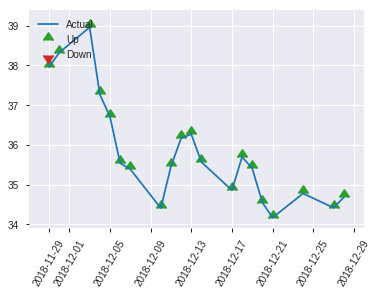


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24934471764765168
RMSE: 0.4993442876890169
LogLoss: 0.6918358241589985
Mean Per-Class Error: 0.41476117886178865
AUC: 0.5785378556910569
pr_auc: 0.524036126874371
Gini: 0.15707571138211374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4834573719203665: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      35   93   0.7266   (93.0/128.0)
1      13   110  0.1057   (13.0/123.0)
Total  48   203  0.4223   (106.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483457     0.674847  202
max f2                       0.482043     0.828841  248
max f0point5                 0.483457     0.588235  202
max accuracy                 0.488011     0.581673  137
max precision                0.503252     0.666667  2
max recall                   0.482043     1         248
max specificity              0.507015     0.992188  0
max absolute_mcc             0.483457     0.213227  202
max min_per_class_accuracy   0.489053     0.569106  124
max mean_per_class_accuracy  0.485664     0.585239  169

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 48.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.503099           1.36043   1.36043            0.666667         0.504801  0.666667                    0.504801            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.50075            0.680217  1.02033            0.333333         0.501729  0.5                         0.503265            0.00813008      0.0243902                  -31.9783  2.03252
    3        0.0318725                   0.500592           0         0.765244           0                0.500638  0.375                       0.502609            0               0.0243902                  -100      -23.4756
    4        0.0438247                   0.499826           1.36043   0.927568           0.666667         0.50032   0.454545                    0.501984            0.0162602       0.0406504                  36.0434   -7.24316
    5        0.0517928                   0.49969            1.02033   0.941839           0.5              0.499784  0.461538                    0.501646            0.00813008      0.0487805                  2.03252   -5.81614
    6        0.103586                    0.497764           1.09881   1.02033            0.538462         0.49881   0.5                         0.500228            0.0569106       0.105691                   9.88118   2.03252
    7        0.151394                    0.496069           1.02033   1.02033            0.5              0.497046  0.5                         0.499223            0.0487805       0.154472                   2.03252   2.03252
    8        0.203187                    0.494029           1.09881   1.04033            0.538462         0.494966  0.509804                    0.498138            0.0569106       0.211382                   9.88118   4.03316
    9        0.302789                    0.492248           1.14276   1.07403            0.56             0.493064  0.526316                    0.496469            0.113821        0.325203                   14.2764   7.40265
    10       0.40239                     0.490482           1.22439   1.11125            0.6              0.491463  0.544554                    0.49523             0.121951        0.447154                   22.439    11.1245
    11       0.501992                    0.488911           1.22439   1.13369            0.6              0.489623  0.555556                    0.494117            0.121951        0.569106                   22.439    13.3695
    12       0.601594                    0.487071           1.06114   1.12168            0.52             0.487955  0.549669                    0.493097            0.105691        0.674797                   6.11382   12.1682
    13       0.701195                    0.485222           0.979512  1.10149            0.48             0.485987  0.539773                    0.492087            0.097561        0.772358                   -2.04878  10.1487
    14       0.800797                    0.483494           1.06114   1.09647            0.52             0.484226  0.537313                    0.491109            0.105691        0.878049                   6.11382   9.64689
    15       0.900398                    0.483027           0.653008  1.04741            0.32             0.483251  0.513274                    0.49024             0.0650407       0.943089                   -34.6992  4.74135
    16       1                           0.48198            0.571382  1                  0.28             0.482691  0.49004                     0.489488      

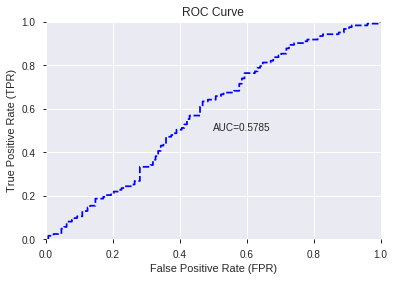

This function is available for GLM models only


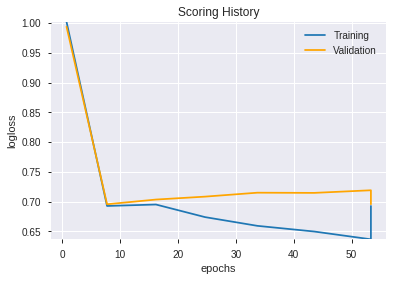

--2019-08-25 16:48:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_163850_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_163850_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['NATR_24',
 'STOCHRSI_fastk',
 'BETA_20',
 'OBV',
 'DX_12',
 'MFI_12',
 'STOCHRSI_fastd',
 'HT_TRENDMODE',
 'quarter',
 'MFI_14',
 'ADX_14',
 'aroondown_8',
 'BOP',
 'ADXR_8',
 'DX_8',
 'BETA_12',
 'STOCHF_fastk',
 'dayofweek',
 'SIN',
 'week',
 'BETA_8',
 'weekday',
 'aroonup_14',
 'aroondown_14',
 'CORREL_8',
 'month',
 'ADX_24',
 'CDLRICKSHAWMAN',
 'MACDEXT_hist',
 'PLUS_DI_20',
 'aroonup_8',
 'BETA_24',
 'HT_PHASOR_quadrature',
 'CDLDOJI',
 'aroondown_24',
 'ADXR_12',
 'BETA_30',
 'ADXR_14',
 'AROONOSC_30',
 'aroonup_30',
 'ADX_20',
 'AROONOSC_8',
 'aroonup_20',
 'weekday_name',
 'BETA_14',
 'CDLLONGLEGGEDDOJI',
 'aroondown_12',
 'AROONOSC_14',
 'SAREXT',
 'aroonup_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_164925_model_1  0.590828  0.690477              0.401296  0.498664  0.248665

variable  relative_importance  scaled_importance  percentage
0                    OBV             0.013606           1.000000    0.069454
1               CORREL_8             0.010827           0.795716    0.055266
2                NATR_24             0.010395           0.764023    0.053065
3                    SIN             0.010361           0.761498    0.052889
4         STOCHRSI_fastk             0.009651           0.709298    0.049264
5             PLUS_DI_20             0.009002           0.661607    0.045951
6                   DX_8             0.008853           0.650643    0.045190
7           HT_TRENDMODE             0.008137           0.598027    0.041536
8                 MFI_14             0.007785           0.572188    0.039741
9           STOCHF_fastk             0.007649           0.562169    0.039045
10                 DX_12             0.007604           0.558857    0.038815
11                MFI_12             0.007034           0.516999    0.035908
12                   BOP             0.005189           0.381397    0.026490
13               quarter             0.005074           0.372927    0.025901
14                 month             0.004780           0.351324    0.024401
15          aroondown_24             0.004577           0.336356    0.023361
16                BETA_8             0.004465           0.328150    0.022791
17                  week             0.003782           0.277980    0.019307
18          aroondown_14             0.003659           0.268940    0.018679
19               ADXR_14             0.003458           0.254144    0.017651
20               ADXR_12             0.003332           0.244916    0.017010
21               BETA_24             0.003303           0.242752    0.016860
22        CDLRICKSHAWMAN             0.003298           0.242397    0.016835
23                SAREXT             0.003006           0.220920    0.015344
24          MACDEXT_hist             0.002971           0.218353    0.015166
25            aroonup_20             0.002802           0.205902    0.014301
26               BETA_20             0.002755           0.202458    0.014062
27            aroonup_24             0.002628           0.193163    0.013416
28                ADX_14             0.002585           0.189953    0.013193
29            aroonup_14             0.002574           0.189176    0.013139
30                ADXR_8             0.002521           0.185309    0.012870
31  HT_PHASOR_quadrature             0.001861           0.136789    0.009501
32               BETA_30             0.001800           0.132279    0.009187
33                ADX_20             0.001632           0.119930    0.008330
34             aroonup_8             0.001407           0.103423    0.007183
35           AROONOSC_30             0.001383           0.101651    0.007060
36             dayofweek             0.001216           0.089362    0.006207
37               weekday             0.001203           0.088398    0.006140
38            aroonup_30             0.001149           0.084424    0.005864
39        STOCHRSI_fastd             0.001145           0.084154    0.005845
40          weekday_name             0.001077           0.079188    0.005500
41          aroondown_12             0.000839           0.061668    0.004283
42               BETA_14             0.000750           0.055157    0.003831
43            AROONOSC_8             0.000583           0.042813    0.002974
44           AROONOSC_14             0.000571           0.041933    0.002912
45                ADX_24             0.000562           0.041310    0.002869
46           aroondown_8             0.000399           0.029291    0.002034
47               BETA_12             0.000248           0.018237    0.001267
48     CDLLONGLEGGEDDOJI             0.000211           0.015515    0.001078
49               CDLDOJI             0.000203           0.014889    0.001034

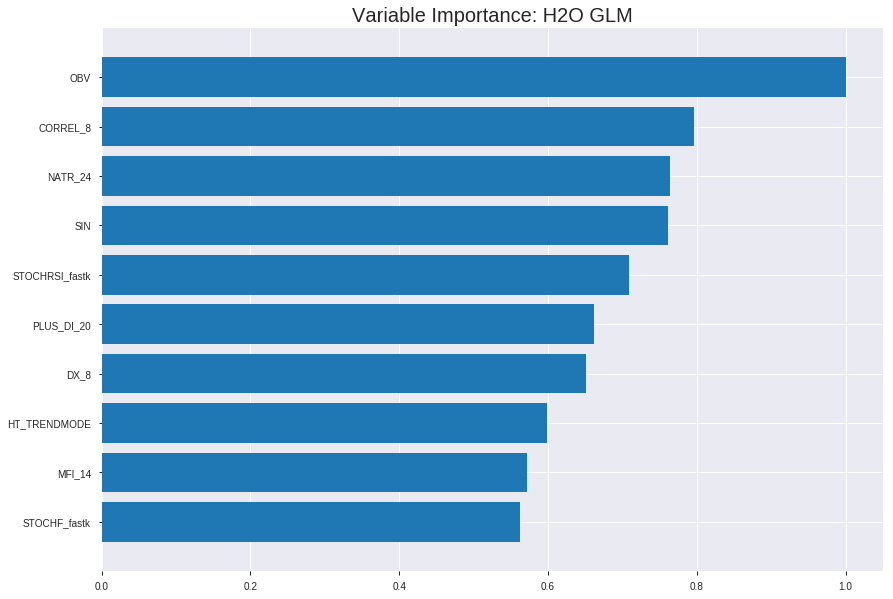

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_164925_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24800510246144122
RMSE: 0.4980011068877671
LogLoss: 0.689149989967627
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2427.133204280672
Residual deviance: 2416.1598648265
AIC: 2518.1598648265
AUC: 0.5857005945861368
pr_auc: 0.5929997101001895
Gini: 0.17140118917227354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5014216911975871: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   791   0.9417   (791.0/840.0)
1      19   894   0.0208   (19.0/913.0)
Total  68   1685  0.4621   (810.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501422     0.688222  362
max f2                       0.489724     0.844745  398
max f0point5                 0.512952     0.590697  278
max accuracy                 0.521737     0.571021  189
max precision                0.557899     1         0
max recall                   0.489724     1         398
max specificity              0.557899     1         0
max absolute_mcc             0.521737     0.146932  189
max min_per_class_accuracy   0.520523     0.559693  203
max mean_per_class_accuracy  0.521737     0.573179  189

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.548316           1.49337   1.49337            0.777778         0.552127  0.777778                    0.552127            0.0153341       0.0153341                  49.3367   49.3367
    2        0.0205362                   0.544925           1.17336   1.33336            0.611111         0.546447  0.694444                    0.549287            0.0120482       0.0273823                  17.336    33.3364
    3        0.0302339                   0.543103           0.451775  1.05059            0.235294         0.544048  0.54717                     0.547606            0.00438116      0.0317634                  -54.8225  5.059
    4        0.040502                    0.541556           1.17336   1.08171            0.611111         0.54237   0.56338                     0.546279            0.0120482       0.0438116                  17.336    8.17148
    5        0.0501997                   0.540673           1.58121   1.17821            0.823529         0.54104   0.613636                    0.545267            0.0153341       0.0591457                  58.1213   17.8209
    6        0.100399                    0.536484           1.2873    1.23276            0.670455         0.538439  0.642045                    0.541853            0.0646221       0.123768                   28.7302   23.2755
    7        0.150029                    0.532396           1.14761   1.20459            0.597701         0.534428  0.627376                    0.539397            0.0569551       0.180723                   14.7612   20.459
    8        0.200228                    0.529977           1.24366   1.21439            0.647727         0.531002  0.632479                    0.537292            0.0624315       0.243154                   24.3665   21.4387
    9        0.300057                    0.526097           1.09717   1.17539            0.571429         0.527956  0.612167                    0.534186            0.109529        0.352683                   9.71679   17.5388
    10       0.399886                    0.522995           1.14105   1.16682            0.594286         0.524522  0.607703                    0.531773            0.11391         0.466594                   14.1055   16.6817
    11       0.500285                    0.520505           0.894566  1.11218            0.465909         0.521694  0.579247                    0.529751            0.0898138       0.556407                   -10.5434  11.218
    12       0.600114                    0.517504           0.921621  1.08048            0.48             0.519046  0.562738                    0.52797             0.0920044       0.648412                   -7.8379   8.04809
    13       0.699943                    0.515022           0.921621  1.05782            0.48             0.516264  0.550937                    0.5263              0.0920044       0.740416                   -7.8379   5.78236
    14       0.799772                    0.511458           0.976479  1.04767            0.508571         0.513227  0.545649                    0.524668            0.0974808       0.837897                   -2.35206  4.76701
    15       0.899601                    0.50665            0.844819  1.02516            0.44             0.509221  0.533925                    0.522954            0.0843373       0.922234                   -15.5181  2.51597
    16       1                           0.488236           0.774563  1                  0.403409         0.501711  0.520821                    0.520821            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24835695591858664
RMSE: 0.4983542474170223
LogLoss: 0.6898581917489602
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 691.6529992083883
Residual deviance: 691.2379081324582
AIC: 793.2379081324582
AUC: 0.5389917100443415
pr_auc: 0.5747851088298677
Gini: 0.07798342008868309
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48487410811001214: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484874     0.705426  399
max f2                       0.484874     0.856874  399
max f0point5                 0.502735     0.60969   304
max accuracy                 0.503511     0.568862  296
max precision                0.551024     1         0
max recall                   0.484874     1         399
max specificity              0.551024     1         0
max absolute_mcc             0.503511     0.106734  296
max min_per_class_accuracy   0.512199     0.517544  196
max mean_per_class_accuracy  0.508948     0.54639   231

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.544332           1.22344   1.22344            0.666667         0.548035  0.666667                    0.548035            0.014652        0.014652                   22.3443   22.3443
    2        0.0219561                   0.538271           0.734066  1.001              0.4              0.541689  0.545455                    0.54515             0.00732601      0.021978                   -26.5934  0.0999001
    3        0.0319361                   0.535674           1.1011    1.03228            0.6              0.536833  0.5625                      0.542551            0.010989        0.032967                   10.1099   3.22802
    4        0.0419162                   0.532938           1.46813   1.13605            0.8              0.534148  0.619048                    0.54055             0.014652        0.047619                   46.8132   13.6054
    5        0.0518962                   0.532114           1.1011    1.12933            0.6              0.53257   0.615385                    0.539016            0.010989        0.0586081                  10.1099   12.9332
    6        0.101796                    0.526641           1.17451   1.15148            0.64             0.528976  0.627451                    0.534094            0.0586081       0.117216                   17.4505   15.1476
    7        0.151697                    0.524301           1.02769   1.11076            0.56             0.525395  0.605263                    0.531233            0.0512821       0.168498                   2.76923   11.0758
    8        0.201597                    0.521887           1.02769   1.0902             0.56             0.522762  0.594059                    0.529136            0.0512821       0.21978                    2.76923   9.01969
    9        0.301397                    0.518122           0.954286  1.04519            0.52             0.519784  0.569536                    0.526039            0.0952381       0.315018                   -4.57143  4.51932
    10       0.401198                    0.515172           0.954286  1.02258            0.52             0.516697  0.557214                    0.523716            0.0952381       0.410256                   -4.57143  2.25794
    11       0.500998                    0.512252           1.0644    1.03091            0.58             0.513676  0.561753                    0.521716            0.106227        0.516484                   6.43956   3.09093
    12       0.600798                    0.50889            1.24791   1.06696            0.68             0.510784  0.581395                    0.5199              0.124542        0.641026                   24.7912   6.69563
    13       0.700599                    0.505636           0.880879  1.04045            0.48             0.50719   0.566952                    0.518089            0.0879121       0.728938                   -11.9121  4.04496
    14       0.800399                    0.501711           1.02769   1.03886            0.56             0.50387   0.566085                    0.516316            0.102564        0.831502                   2.76923   3.88589
    15       0.9002                      0.496965           0.807473  1.01321            0.44             0.49922   0.552106                    0.514421            0.0805861       0.912088                   -19.2527  1.32063
    16       1                           0.484874           0.880879  1                  0.48             0.493025  0.54491                     0.512286       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:49:26  0.000 sec   2            3.5       51            1.38033           1.37973
    2019-08-25 16:49:26  0.008 sec   4            2.2       51            1.3783            1.37972
    2019-08-25 16:49:26  0.015 sec   6            1.3       51            1.37555           1.38005
    2019-08-25 16:49:26  0.022 sec   8            0.83      51            1.37202           1.38103
    2019-08-25 16:49:26  0.030 sec   10           0.52      51            1.36777           1.38313
    2019-08-25 16:49:26  0.037 sec   12           0.32      51            1.36306           1.38689
    2019-08-25 16:49:26  0.043 sec   14           0.2       51            1.35831           1.39272

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.601593625498008)

('F1', 0.673076923076923)

('auc', 0.5908282520325203)

('logloss', 0.69047717708381)

('mean_per_class_error', 0.3944359756097561)

('rmse', 0.4986635728205208)

('mse', 0.24866535885812685)

glm prediction progress: |████████████████████████████████████████████████| 100%


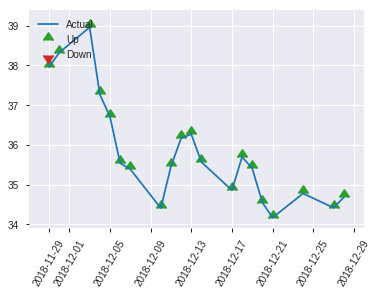


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24866535885812685
RMSE: 0.4986635728205208
LogLoss: 0.69047717708381
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.8121992937332
Residual deviance: 346.6195428960726
AIC: 448.6195428960726
AUC: 0.5908282520325203
pr_auc: 0.5419691845320839
Gini: 0.18165650406504064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5020513657872488: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   84   0.6562   (84.0/128.0)
1      18   105  0.1463   (18.0/123.0)
Total  62   189  0.4064   (102.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502051     0.673077  188
max f2                       0.491233     0.829932  242
max f0point5                 0.504748     0.601458  174
max accuracy                 0.504748     0.601594  174
max precision                0.529193     0.6875    15
max recall                   0.486822     1         249
max specificity              0.537071     0.992188  0
max absolute_mcc             0.504748     0.229709  174
max min_per_class_accuracy   0.511169     0.569106  123
max mean_per_class_accuracy  0.504748     0.605564  174

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.533467           0         0                  0                0.535836  0                           0.535836            0               0                          -100      -100
    2        0.0239044                   0.533185           2.04065   1.02033            1                0.533261  0.5                         0.534549            0.0243902       0.0243902                  104.065   2.03252
    3        0.0318725                   0.531813           1.02033   1.02033            0.5              0.532183  0.5                         0.533957            0.00813008      0.0325203                  2.03252   2.03252
    4        0.0438247                   0.530901           2.04065   1.2986             1                0.531233  0.636364                    0.533214            0.0243902       0.0569106                  104.065   29.8596
    5        0.0517928                   0.530185           1.02033   1.25578            0.5              0.530389  0.615385                    0.53278             0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.526249           1.25578   1.25578            0.615385         0.528137  0.615385                    0.530458            0.0650407       0.130081                   25.5785   25.5785
    7        0.151394                    0.524381           1.02033   1.18143            0.5              0.525275  0.578947                    0.528821            0.0487805       0.178862                   2.03252   18.1429
    8        0.203187                    0.522708           0.627892  1.04033            0.307692         0.523448  0.509804                    0.527452            0.0325203       0.211382                   -37.2108  4.03316
    9        0.302789                    0.517425           0.979512  1.02033            0.48             0.519886  0.5                         0.524963            0.097561        0.308943                   -2.04878  2.03252
    10       0.40239                     0.514062           1.38764   1.11125            0.68             0.515733  0.544554                    0.522678            0.138211        0.447154                   38.7642   11.1245
    11       0.501992                    0.51088            1.22439   1.13369            0.6              0.512357  0.555556                    0.52063             0.121951        0.569106                   22.439    13.3695
    12       0.601594                    0.508287           1.14276   1.1352             0.56             0.509621  0.556291                    0.518808            0.113821        0.682927                   14.2764   13.5196
    13       0.701195                    0.50461            1.22439   1.14787            0.6              0.506642  0.5625                      0.51708             0.121951        0.804878                   22.439    14.7866
    14       0.800797                    0.500441           0.734634  1.09647            0.36             0.502503  0.537313                    0.515267            0.0731707       0.878049                   -26.5366  9.64689
    15       0.900398                    0.495634           0.653008  1.04741            0.32             0.497883  0.513274                    0.513344            0.0650407       0.943089                   -34.6992  4.74135
    16       1                           0.482675           0.571382  1                  0.28             0.49182   0.49004                     0.5112              

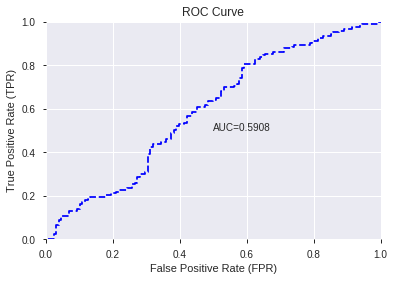

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


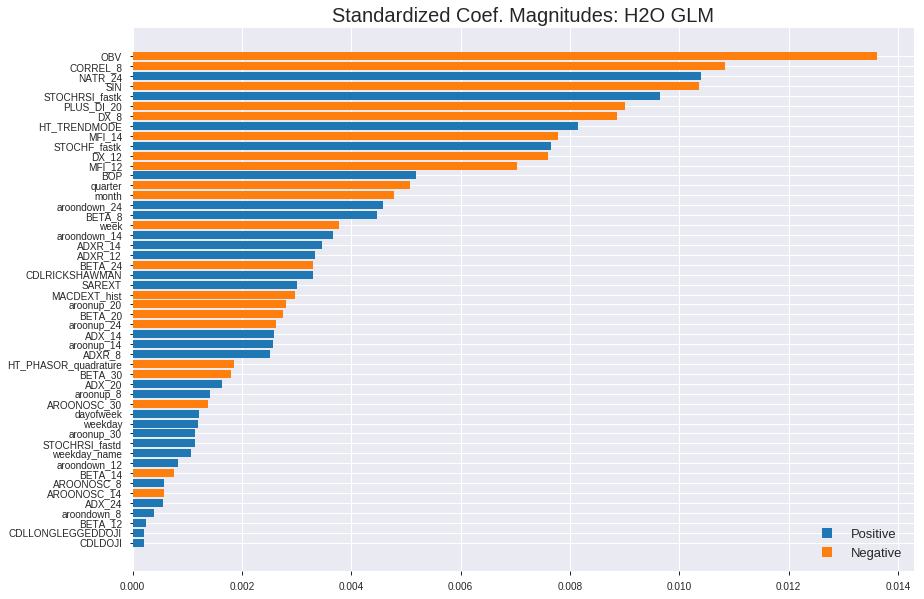

'log_likelihood'
--2019-08-25 16:49:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.240
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_164925_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_164925_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['OBV',
 'CORREL_8',
 'NATR_24',
 'SIN',
 'STOCHRSI_fastk',
 'PLUS_DI_20',
 'DX_8',
 'HT_TRENDMODE',
 'MFI_14',
 'STOCHF_fastk',
 'DX_12',
 'MFI_12',
 'BOP',
 'quarter',
 'month',
 'aroondown_24',
 'BETA_8',
 'week',
 'aroondown_14',
 'ADXR_14',
 'ADXR_12',
 'BETA_24',
 'CDLRICKSHAWMAN',
 'SAREXT',
 'MACDEXT_hist',
 'aroonup_20',
 'BETA_20',
 'aroonup_24',
 'ADX_14',
 'aroonup_14',
 'ADXR_8',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'ADX_20',
 'aroonup_8',
 'AROONOSC_30',
 'dayofweek',
 'weekday',
 'aroonup_30',
 'STOCHRSI_fastd',
 'weekday_name',
 'aroondown_12',
 'BETA_14',
 'AROONOSC_8',
 'AROONOSC_14',
 'ADX_24',
 'aroondown_8',
 'BETA_12',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI']

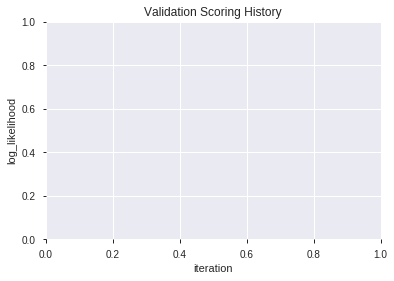

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_165032_model_4  0.578760  0.682383              0.437976  0.494661  0.244689
1  XGBoost_grid_1_AutoML_20190825_165032_model_1  0.574155  0.694902              0.428004  0.500675  0.250676
2  XGBoost_grid_1_AutoML_20190825_165032_model_6  0.569931  0.687054              0.442677  0.497027  0.247036
3  XGBoost_grid_1_AutoML_20190825_165032_model_2  0.569169  0.684043              0.427052  0.495515  0.245535
4               XGBoost_1_AutoML_20190825_165032  0.566819  0.690661              0.492188  0.498625  0.248627
5               XGBoost_3_AutoML_20190825_165032  0.563199  0.689100              0.439247  0.498045  0.248049
6  XGBoost_grid_1_AutoML_20190825_165032_model_7  0.559642  0.689484              0.476880  0.498188  0.248191
7  XGBoost_grid_1_AutoML_20190825_165032_model_3  0.556180  0.689816              0.476562  0.498477  0.248479
8  XGBoost_grid_1_AutoML_20190825_165032_model_5  0.547891  0.711137              0.496094  0.507676  0.257735
9               XGBoost_2_AutoML_20190825_165032  0.540333  0.695405              0.500000  0.500975  0.250976

variable  relative_importance  scaled_importance  percentage
0                    SIN           153.938202           1.000000    0.053869
1                 MFI_12           142.916962           0.928405    0.050013
2                 BETA_8           135.169052           0.878073    0.047301
3               CORREL_8           131.746674           0.855841    0.046104
4                NATR_24           126.625633           0.822574    0.044311
5                    OBV           126.291107           0.820401    0.044194
6                 SAREXT           118.871506           0.772203    0.041598
7         STOCHRSI_fastk           112.151093           0.728546    0.039246
8            AROONOSC_30           108.915756           0.707529    0.038114
9                 MFI_14            95.368530           0.619525    0.033373
10               BETA_20            94.342430           0.612859    0.033014
11                ADXR_8            92.447876           0.600552    0.032351
12                 DX_12            90.333420           0.586816    0.031611
13                   BOP            90.226700           0.586123    0.031574
14            PLUS_DI_20            90.111984           0.585378    0.031534
15               ADXR_12            85.783264           0.557258    0.030019
16                  DX_8            84.490990           0.548863    0.029567
17               BETA_14            83.857979           0.544751    0.029345
18               BETA_30            74.678345           0.485119    0.026133
19                ADX_14            71.087852           0.461795    0.024877
20  HT_PHASOR_quadrature            62.315464           0.404808    0.021807
21          MACDEXT_hist            60.429409           0.392556    0.021147
22          STOCHF_fastk            60.208843           0.391123    0.021070
23                  week            55.571671           0.361000    0.019447
24               BETA_24            54.822342           0.356132    0.019185
25        STOCHRSI_fastd            50.106205           0.325496    0.017534
26               ADXR_14            42.720299           0.277516    0.014950
27                ADX_20            40.226471           0.261316    0.014077
28            aroonup_30            35.512897           0.230696    0.012427
29             dayofweek            31.125927           0.202198    0.010892
30            aroonup_24            29.894083           0.194195    0.010461
31               BETA_12            29.813753           0.193674    0.010433
32             aroonup_8            26.569382           0.172598    0.009298
33           aroondown_8            24.758774           0.160836    0.008664
34                 month            23.833881           0.154828    0.008340
35          aroondown_12            22.668816           0.147259    0.007933
36                ADX_24            20.178308           0.131081    0.007061
37          weekday_name            14.912905           0.096876    0.005219
38          aroondown_24            14.510159           0.094260    0.005078
39          HT_TRENDMODE            12.364254           0.080320    0.004327
40            AROONOSC_8            12.337429           0.080145    0.004317
41            aroonup_14            10.124099           0.065767    0.003543
42            aroonup_20             6.680351           0.043396    0.002338
43          aroondown_14             6.583546           0.042767    0.002304

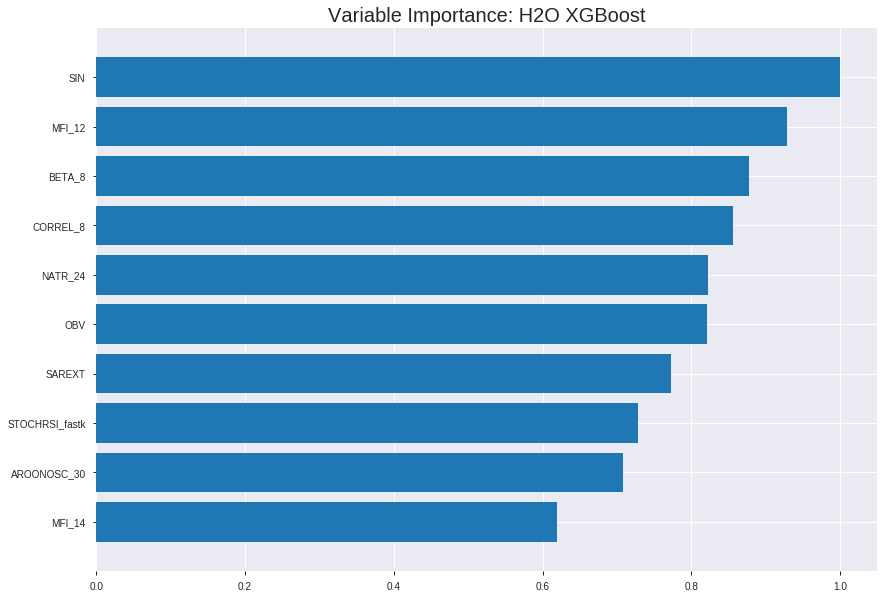

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_165032_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21723091750268647
RMSE: 0.46608037665480667
LogLoss: 0.626472845875051
Mean Per-Class Error: 0.2776267407291504
AUC: 0.7910642570281124
pr_auc: 0.788450160164176
Gini: 0.5821285140562249
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4781218667825063: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      429  411   0.4893   (411.0/840.0)
1      105  808   0.115    (105.0/913.0)
Total  534  1219  0.2944   (516.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478122     0.757974  259
max f2                       0.420979     0.85879   329
max f0point5                 0.530299     0.741897  182
max accuracy                 0.499708     0.72162   227
max precision                0.742582     1         0
max recall                   0.362929     1         380
max specificity              0.742582     1         0
max absolute_mcc             0.530299     0.445531  182
max min_per_class_accuracy   0.52031      0.711939  197
max mean_per_class_accuracy  0.530299     0.722373  182

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.686327           1.81337   1.81337            0.944444         0.703153  0.944444                    0.703153            0.0186199       0.0186199                  81.3375   81.3375
    2        0.0205362                   0.670597           1.70671   1.76004            0.888889         0.677073  0.916667                    0.690113            0.0175246       0.0361446                  70.6706   76.004
    3        0.0302339                   0.656193           1.69416   1.73891            0.882353         0.661954  0.90566                     0.681081            0.0164294       0.0525739                  69.4156   73.8908
    4        0.040502                    0.647544           1.81337   1.75779            0.944444         0.651136  0.915493                    0.673489            0.0186199       0.0711939                  81.3375   75.7787
    5        0.0501997                   0.639491           1.8071    1.76731            0.941176         0.642529  0.920455                    0.667508            0.0175246       0.0887185                  80.71     76.7313
    6        0.100399                    0.617609           1.68004   1.72368            0.875            0.62728   0.897727                    0.647394            0.0843373       0.173056                   68.0038   72.3676
    7        0.150029                    0.601163           1.589     1.67913            0.827586         0.609506  0.874525                    0.634861            0.0788609       0.251917                   58.9002   67.9126
    8        0.200228                    0.587599           1.54913   1.64653            0.806818         0.5944    0.85755                     0.624717            0.0777656       0.329682                   54.9126   64.6533
    9        0.300057                    0.565251           1.42632   1.57327            0.742857         0.575473  0.819392                    0.608333            0.142388        0.47207                    42.6318   57.3268
    10       0.399886                    0.544578           1.25077   1.49276            0.651429         0.555125  0.777461                    0.59505             0.124863        0.596933                   25.0771   49.2759
    11       0.500285                    0.522591           1.08002   1.40993            0.5625           0.533633  0.734322                    0.582725            0.108434        0.705367                   8.00246   40.993
    12       0.600114                    0.499633           1.03134   1.34695            0.537143         0.510377  0.701521                    0.57069             0.102957        0.808324                   3.13378   34.6951
    13       0.699943                    0.476199           0.778989  1.26595            0.405714         0.488488  0.659332                    0.558966            0.0777656       0.88609                    -22.1011  26.5946
    14       0.799772                    0.451617           0.482754  1.16819            0.251429         0.464945  0.608417                    0.54723             0.0481928       0.934283                   -51.7246  16.8186
    15       0.899601                    0.414106           0.449839  1.08847            0.234286         0.435357  0.566899                    0.534815            0.0449069       0.979189                   -55.0161  8.84713
    16       1                           0.304333           0.207277  1                  0.107955         0.385003  0.520821                    0.519774           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2535057305231848
RMSE: 0.5034935258006649
LogLoss: 0.7003542024621274
Mean Per-Class Error: 0.4528629265471371
AUC: 0.5473298631193368
pr_auc: 0.5848393621664326
Gini: 0.09465972623867369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3115386366844177: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    225  0.9868   (225.0/228.0)
1      0    273  0        (0.0/273.0)
Total  3    498  0.4491   (225.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311539     0.708171  396
max f2                       0.311539     0.858491  396
max f0point5                 0.375331     0.606061  370
max accuracy                 0.375331     0.558882  370
max precision                0.720021     1         0
max recall                   0.311539     1         396
max specificity              0.720021     1         0
max absolute_mcc             0.49503      0.104622  116
max min_per_class_accuracy   0.459281     0.527473  199
max mean_per_class_accuracy  0.49503      0.547137  116

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 46.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.650674           0.917582  0.917582           0.5              0.676397  0.5                         0.676397            0.010989        0.010989                   -8.24176   -8.24176
    2        0.0219561                   0.640687           1.1011    1.001              0.6              0.64529   0.545455                    0.662257            0.010989        0.021978                   10.1099    0.0999001
    3        0.0319361                   0.597945           1.83516   1.26168            1                0.608739  0.6875                      0.645533            0.018315        0.040293                   83.5165    26.1676
    4        0.0419162                   0.577226           1.1011    1.22344            0.6              0.586578  0.666667                    0.631496            0.010989        0.0512821                  10.1099    22.3443
    5        0.0518962                   0.560508           1.1011    1.19992            0.6              0.567025  0.653846                    0.619098            0.010989        0.0622711                  10.1099    19.9915
    6        0.101796                    0.543486           1.02769   1.11549            0.56             0.549526  0.607843                    0.584994            0.0512821       0.113553                   2.76923    11.5492
    7        0.151697                    0.525439           1.17451   1.1349             0.64             0.5323    0.618421                    0.56766             0.0586081       0.172161                   17.4505    13.4905
    8        0.201597                    0.514264           1.32132   1.18105            0.72             0.51913   0.643564                    0.555648            0.0659341       0.238095                   32.1319    18.1047
    9        0.301397                    0.490366           0.954286  1.10596            0.52             0.501984  0.602649                    0.537878            0.0952381       0.333333                   -4.57143   10.596
    10       0.401198                    0.475831           0.990989  1.07736            0.54             0.48278   0.587065                    0.524172            0.0989011       0.432234                   -0.901099  7.73605
    11       0.500998                    0.455258           0.954286  1.05284            0.52             0.467163  0.573705                    0.512816            0.0952381       0.527473                   -4.57143   5.28436
    12       0.600798                    0.439442           0.880879  1.02428            0.48             0.447127  0.55814                     0.501904            0.0879121       0.615385                   -11.9121   2.4278
    13       0.700599                    0.425827           1.1011    1.03522            0.6              0.432389  0.564103                    0.492002            0.10989         0.725275                   10.1099    3.52212
    14       0.800399                    0.405975           0.844176  1.0114             0.46             0.416427  0.551122                    0.482578            0.0842491       0.809524                   -15.5824   1.14001
    15       0.9002                      0.38735            1.02769   1.01321            0.56             0.39755   0.552106                    0.473152            0.102564        0.912088                   2.76923    1.32063
    16       1                           0.294396           0.880879  1                  0.48             0.35757   0.54491                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:50:37  2.148 sec   0                  0.5              0.693147            0.5             0                  1                0.479179                         0.5                0.693147              0.5               0                    1                  0.45509
    2019-08-25 16:50:37  2.210 sec   5                  0.494573         0.682338            0.667013        0.675766           1.60004          0.435254                         0.499272           0.691692              0.551764          0.572677             0.917582           0.45509
    2019-08-25 16:50:37  2.254 sec   10                 0.491037         0.675334            0.698864        0.71106            1.72804          0.389047                         0.499754           0.692654              0.549692          0.567542             0.917582           0.451098
    2019-08-25 16:50:37  2.307 sec   15                 0.487285         0.66792             0.714402        0.727586           1.81337          0.358243                         0.500051           0.693255              0.547466          0.570097             0.917582           0.44511
    2019-08-25 16:50:37  2.358 sec   20                 0.483092         0.659661            0.732827        0.74134            1.81337          0.335995                         0.499929           0.693015              0.560191          0.586842             0.917582           0.449102
    2019-08-25 16:50:38  2.406 sec   25                 0.480096         0.653779            0.744996        0.747864           1.81337          0.351968                         0.499562           0.692277              0.563356          0.590792             0.917582           0.447106
    2019-08-25 16:50:38  2.456 sec   30                 0.477124         0.647945            0.751367        0.754927           1.81337          0.341129                         0.500556           0.694283              0.559347          0.58633              0.917582           0.44511
    2019-08-25 16:50:38  2.511 sec   35                 0.474393         0.642617            0.761582        0.762046           1.81337          0.334855                         0.500821           0.694827              0.55619           0.588045             1.22344            0.449102
    2019-08-25 16:50:38  2.565 sec   40                 0.471607         0.637191            0.771434        0.770673           1.81337          0.302909                         0.502003           0.697256              0.548238          0.582364             0.917582           0.447106
    2019-08-25 16:50:38  2.622 sec   45                 0.468642         0.631448            0.783622        0.779444           1.81337          0.294353                         0.502863           0.699036              0.547089          0.586604             0.917582           0.44511
    2019-08-25 16:50:38  2.689 sec   50                 0.46608          0.626473            0.791064        0.78845            1.81337          0.294353                         0.503494           0.700354              0.54733           0.584839             0.917582           0.449102

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ---------------------
SIN           153.93820190429688     1.0                  0.05386928737163372
MFI_12        142.91696166992188     0.9284047747860087   0.050012503610144386
BETA_8        135.16905212402344     0.8780734765763849   0.04730119244310277
CORREL_8      131.74667358398438     0.85584131784189     0.04610356189534248
NATR_24       126.6256332397461      0.8225744595774156   0.044311499947542105
---           ---                    ---                  ---
HT_TRENDMODE  12.364253997802734     0.08031959477797182  0.004326759332667735
AROONOSC_8    12.33742904663086      0.08014533685602628  0.0043173721825936675
aroonup_14    10.124098777770996     0.06576729267024395  0.003542837188507711
aroonup_20    6.6803507804870605     0.04339631552043348  0.0023377285916403195
aroondown_14  6.583545684814453      0.04276745865141021  0.002303852520247279


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6818181818181819)

('auc', 0.578760162601626)

('logloss', 0.682382814180111)

('mean_per_class_error', 0.4159679878048781)

('rmse', 0.49466078964540844)

('mse', 0.244689296812619)

xgboost prediction progress: |████████████████████████████████████████████| 100%


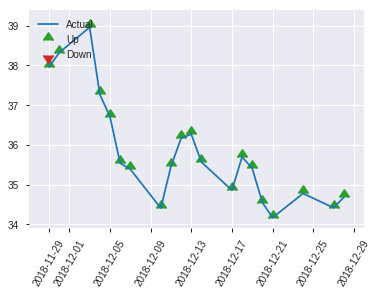


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.244689296812619
RMSE: 0.49466078964540844
LogLoss: 0.682382814180111
Mean Per-Class Error: 0.4159679878048781
AUC: 0.578760162601626
pr_auc: 0.5492473102472549
Gini: 0.157520325203252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4148142635822296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   109  0.8516   (109.0/128.0)
1      3    120  0.0244   (3.0/123.0)
Total  22   229  0.4462   (112.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414814     0.681818  228
max f2                       0.404536     0.836763  236
max f0point5                 0.442474     0.588547  204
max accuracy                 0.442474     0.577689  204
max precision                0.599509     0.75      3
max recall                   0.369444     1         247
max specificity              0.679032     0.992188  0
max absolute_mcc             0.410185     0.220271  231
max min_per_class_accuracy   0.497886     0.546875  125
max mean_per_class_accuracy  0.442474     0.584032  204

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 49.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.599729           1.36043   1.36043            0.666667         0.640817  0.666667                    0.640817            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.59324            0.680217  1.02033            0.333333         0.595347  0.5                         0.618082            0.00813008      0.0243902                  -31.9783  2.03252
    3        0.0318725                   0.589806           2.04065   1.27541            1                0.589939  0.625                       0.611046            0.0162602       0.0406504                  104.065   27.5407
    4        0.0438247                   0.588338           1.36043   1.2986             0.666667         0.589191  0.636364                    0.605086            0.0162602       0.0569106                  36.0434   29.8596
    5        0.0517928                   0.583505           2.04065   1.41276            1                0.586147  0.692308                    0.602172            0.0162602       0.0731707                  104.065   41.2758
    6        0.103586                    0.566868           1.09881   1.25578            0.538462         0.57382   0.615385                    0.587996            0.0569106       0.130081                   9.88118   25.5785
    7        0.151394                    0.551637           1.02033   1.18143            0.5              0.558079  0.578947                    0.578549            0.0487805       0.178862                   2.03252   18.1429
    8        0.203187                    0.538196           1.09881   1.16037            0.538462         0.544707  0.568627                    0.569922            0.0569106       0.235772                   9.88118   16.037
    9        0.302789                    0.527791           1.06114   1.12773            0.52             0.532682  0.552632                    0.557672            0.105691        0.341463                   6.11382   12.7728
    10       0.40239                     0.512799           1.06114   1.11125            0.52             0.519119  0.544554                    0.548129            0.105691        0.447154                   6.11382   11.1245
    11       0.501992                    0.497886           1.06114   1.1013             0.52             0.506009  0.539683                    0.539772            0.105691        0.552846                   6.11382   10.1303
    12       0.601594                    0.477849           0.81626   1.05411            0.4              0.48766   0.516556                    0.531144            0.0813008       0.634146                   -18.374   5.41108
    13       0.701195                    0.464298           1.06114   1.05511            0.52             0.470251  0.517045                    0.522495            0.105691        0.739837                   6.11382   5.5109
    14       0.800797                    0.445075           1.30602   1.08632            0.64             0.452203  0.532338                    0.513752            0.130081        0.869919                   30.6016   8.63164
    15       0.900398                    0.417029           0.897886  1.06547            0.44             0.433076  0.522124                    0.504827            0.0894309       0.95935                    -10.2114  6.54723
    16       1                           0.313189           0.40813   1                  0.2              0.395178  0.49004                     0.493906           

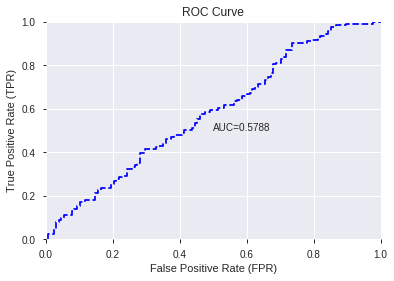

This function is available for GLM models only


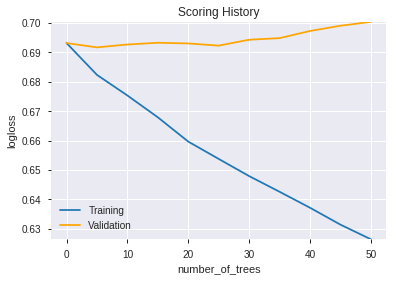

--2019-08-25 16:50:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_165032_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_165032_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'MFI_12',
 'BETA_8',
 'CORREL_8',
 'NATR_24',
 'OBV',
 'SAREXT',
 'STOCHRSI_fastk',
 'AROONOSC_30',
 'MFI_14',
 'BETA_20',
 'ADXR_8',
 'DX_12',
 'BOP',
 'PLUS_DI_20',
 'ADXR_12',
 'DX_8',
 'BETA_14',
 'BETA_30',
 'ADX_14',
 'HT_PHASOR_quadrature',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'week',
 'BETA_24',
 'STOCHRSI_fastd',
 'ADXR_14',
 'ADX_20',
 'aroonup_30',
 'dayofweek',
 'aroonup_24',
 'BETA_12',
 'aroonup_8',
 'aroondown_8',
 'month',
 'aroondown_12',
 'ADX_24',
 'weekday_name',
 'aroondown_24',
 'HT_TRENDMODE',
 'AROONOSC_8',
 'aroonup_14',
 'aroonup_20',
 'aroondown_14']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190825_165147_model_1  0.5  16.925376                   0.5  0.700028  0.49004

variable  relative_importance  scaled_importance    percentage
0              CDLMATCHINGLOW         7.258906e-03           1.000000  1.032001e-02
1                    CORREL_8         5.583741e-03           0.769226  7.938422e-03
2                         SIN         4.855149e-03           0.668854  6.902580e-03
3         CDLXSIDEGAP3METHODS         4.834569e-03           0.666019  6.873322e-03
4                        DX_8         4.760662e-03           0.655837  6.768248e-03
...                       ...                  ...                ...           ...
1037                   TSF_30         4.414123e-06           0.000608  6.275573e-06
1038                   MAX_30         3.556631e-06           0.000490  5.056473e-06
1039  BBANDS_lowerband_30_2_3         1.862952e-06           0.000257  2.648565e-06
1040                   SUM_14         1.672139e-06           0.000230  2.377285e-06
1041  BBANDS_lowerband_20_6_2         6.735252e-07           0.000093  9.575528e-07

[1042 rows x 4 columns]

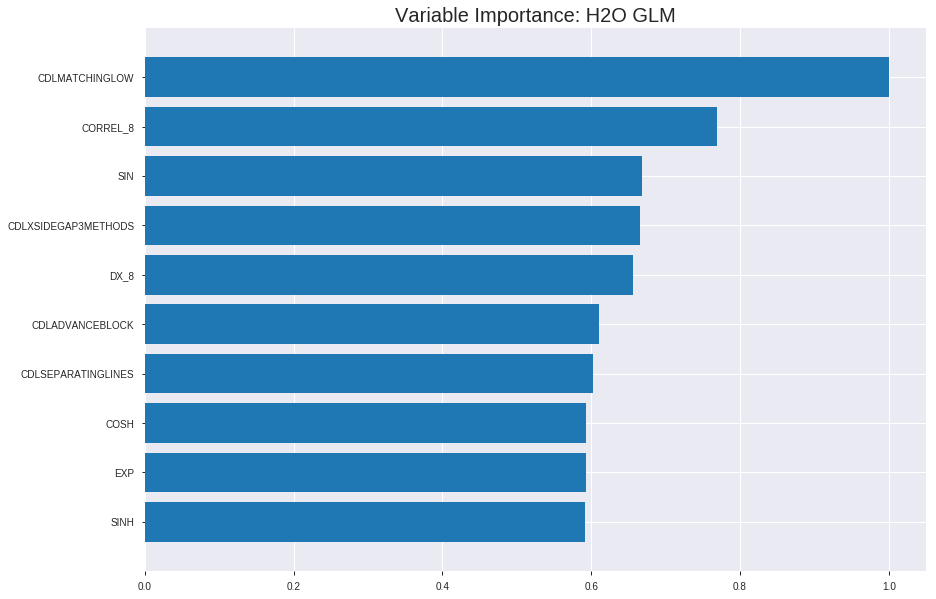

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_165147_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.245077249750039
RMSE: 0.49505277471198866
LogLoss: 0.6832194896122805
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2427.133204280672
Residual deviance: 2395.3675305806555
AIC: 4481.3675305806555
AUC: 0.5817412507171543
pr_auc: 0.5924314945674023
Gini: 0.16348250143430865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4522441984520651: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   792   0.9429   (792.0/840.0)
1      17   896   0.0186   (17.0/913.0)
Total  65   1688  0.4615   (809.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452244     0.688966  359
max f2                       0.406448     0.845684  393
max f0point5                 0.484581     0.591167  293
max accuracy                 0.503397     0.565317  242
max precision                0.652301     1         0
max recall                   0.406448     1         393
max specificity              0.652301     1         0
max absolute_mcc             0.517752     0.124614  205
max min_per_class_accuracy   0.513855     0.555312  214
max mean_per_class_accuracy  0.517752     0.562227  205

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.629695           1.3867    1.3867             0.722222         0.639746  0.722222                    0.639746            0.0142388       0.0142388                  38.6698    38.6698
    2        0.0205362                   0.619847           1.70671   1.5467             0.888889         0.623858  0.805556                    0.631802            0.0175246       0.0317634                  70.6706    54.6702
    3        0.0302339                   0.61226            0.90355   1.34041            0.470588         0.616432  0.698113                    0.626872            0.00876232      0.0405257                  -9.645     34.0408
    4        0.040502                    0.606377           1.49337   1.37919            0.777778         0.60981   0.71831                     0.622546            0.0153341       0.0558598                  49.3367    37.9186
    5        0.0501997                   0.60263            1.58121   1.41821            0.823529         0.604234  0.738636                    0.619009            0.0153341       0.0711939                  58.1213    41.8214
    6        0.100399                    0.584465           1.15639   1.2873             0.602273         0.592952  0.670455                    0.60598             0.0580504       0.129244                   15.639     28.7302
    7        0.150029                    0.57235            0.926918  1.16809            0.482759         0.57864   0.608365                    0.596936            0.0460022       0.175246                   -7.30823   16.8087
    8        0.200228                    0.562494           1.09093   1.14874            0.568182         0.567569  0.598291                    0.589574            0.0547645       0.230011                   9.0934     14.8744
    9        0.300057                    0.541217           1.10814   1.13524            0.577143         0.55105   0.591255                    0.576757            0.110624        0.340635                   10.814     13.5235
    10       0.399886                    0.525286           1.14105   1.13669            0.594286         0.532502  0.592011                    0.565709            0.11391         0.454545                   14.1055    13.6688
    11       0.500285                    0.513865           0.99275   1.1078             0.517045         0.519514  0.576967                    0.556438            0.0996714       0.554217                   -0.725007  10.7802
    12       0.600114                    0.504241           1.02037   1.09326            0.531429         0.509026  0.569392                    0.548551            0.101862        0.656079                   2.03661    9.32569
    13       0.699943                    0.494322           0.932593  1.07034            0.485714         0.499142  0.557457                    0.541504            0.0930997       0.749179                   -6.74073   7.03423
    14       0.799772                    0.484398           0.954536  1.05589            0.497143         0.489478  0.549929                    0.53501             0.0952903       0.844469                   -4.54639   5.58871
    15       0.899601                    0.470716           0.844819  1.03246            0.44             0.478328  0.53773                     0.52872             0.0843373       0.928806                   -15.5181   3.24649
    16       1                           0.395534           0.709107  1                  0.369318         0.450045  0.520821                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.45702298601194324
RMSE: 0.6760347520741394
LogLoss: 8.632825840732718
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 691.6529992083883
Residual deviance: 113250.52728860152
AIC: 115336.52728860152
AUC: 0.5187809266756636
pr_auc: 0.5672651167451096
Gini: 0.03756185335132711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.282110303405602e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       9.28211e-50  0.705426  338
max f2                       9.28211e-50  0.856874  338
max f0point5                 9.28211e-50  0.599473  338
max accuracy                 9.28211e-50  0.54491   338
max precision                0.442993     0.711111  44
max recall                   9.28211e-50  1         338
max specificity              0.565825     0.995614  0
max absolute_mcc             0.442993     0.104845  44
max min_per_class_accuracy   5.60436e-05  0.517544  251
max mean_per_class_accuracy  0.000329183  0.53087   229

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 12.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.560188           0.917582  0.917582           0.5              0.563496      0.5                         0.563496            0.010989        0.010989                   -8.24176  -8.24176
    2        0.0219561                   0.55221            1.1011    1.001              0.6              0.556935      0.545455                    0.560514            0.010989        0.021978                   10.1099   0.0999001
    3        0.0319361                   0.519392           1.46813   1.14698            0.8              0.538557      0.625                       0.553652            0.014652        0.03663                    46.8132   14.6978
    4        0.0419162                   0.467326           0.734066  1.04867            0.4              0.4777        0.571429                    0.535569            0.00732601      0.043956                   -26.5934  4.86656
    5        0.0518962                   0.460649           1.46813   1.12933            0.8              0.463993      0.615385                    0.521804            0.014652        0.0586081                  46.8132   12.9332
    6        0.101796                    0.441522           1.32132   1.22344            0.72             0.448934      0.666667                    0.486083            0.0659341       0.124542                   32.1319   22.3443
    7        0.151697                    0.429662           0.880879  1.11076            0.48             0.436331      0.605263                    0.469718            0.043956        0.168498                   -11.9121  11.0758
    8        0.201597                    0.406136           0.954286  1.07203            0.52             0.419111      0.584158                    0.457191            0.047619        0.216117                   -4.57143  7.2027
    9        0.301397                    0.128844           0.954286  1.03304            0.52             0.273222      0.562914                    0.396274            0.0952381       0.311355                   -4.57143  3.30398
    10       0.401198                    0.00361057         1.02769   1.03171            0.56             0.0449363     0.562189                    0.308877            0.102564        0.413919                   2.76923   3.17096
    11       0.500998                    6.18468e-05        1.02769   1.03091            0.56             0.000787856   0.561753                    0.247504            0.102564        0.516484                   2.76923   3.09093
    12       0.600798                    5.80402e-08        0.954286  1.01818            0.52             9.86944e-06   0.554817                    0.206392            0.0952381       0.611722                   -4.57143  1.81812
    13       0.700599                    1.41321e-97        0.880879  0.998622           0.48             1.39222e-09   0.54416                     0.176992            0.0879121       0.699634                   -11.9121  -0.137754
    14       1                           0                  1.00322   1                  0.546667         1.17248e-105  0.54491                     0.124               0.300366        1                          0.322344  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 16:51:50  0.000 sec   2            4.3       1043          1.36644           226.049
    2019-08-25 16:51:53  2.079 sec   4            3.2       1043          1.36352           235.47
    2019-08-25 16:51:55  4.143 sec   6            2.3       1043          1.35997           243.556
    2019-08-25 16:51:57  6.195 sec   8            1.7       1043          1.35576           251.221
    2019-08-25 16:51:59  8.255 sec   10           1.2       1043          1.35084           258.796

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4900398406374502)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6577540106951871)

('auc', 0.5)

('logloss', 16.925376480374545)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7000284570197487)

('mse', 0.4900398406374502)

glm prediction progress: |████████████████████████████████████████████████| 100%


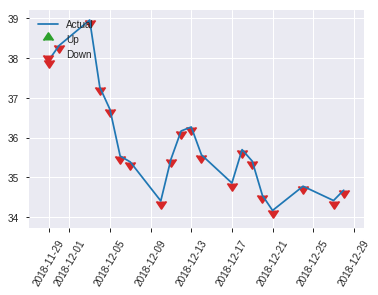


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4900398406374502
RMSE: 0.7000284570197487
LogLoss: 16.925376480374545
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 348.8121992937332
Residual deviance: 174265.51895893694
AIC: 176351.51895893694
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    123  0        (0.0/123.0)
Total  0    251  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.657754  0
max f2                       0            0.827725  0
max f0point5                 0            0.545697  0
max accuracy                 0            0.49004   0
max precision                0            0.49004   0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 49.00 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.49004          0        0.49004                     0                   1               1                          0       0

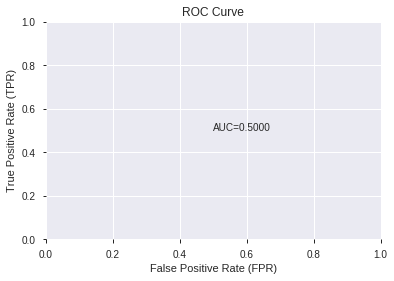

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


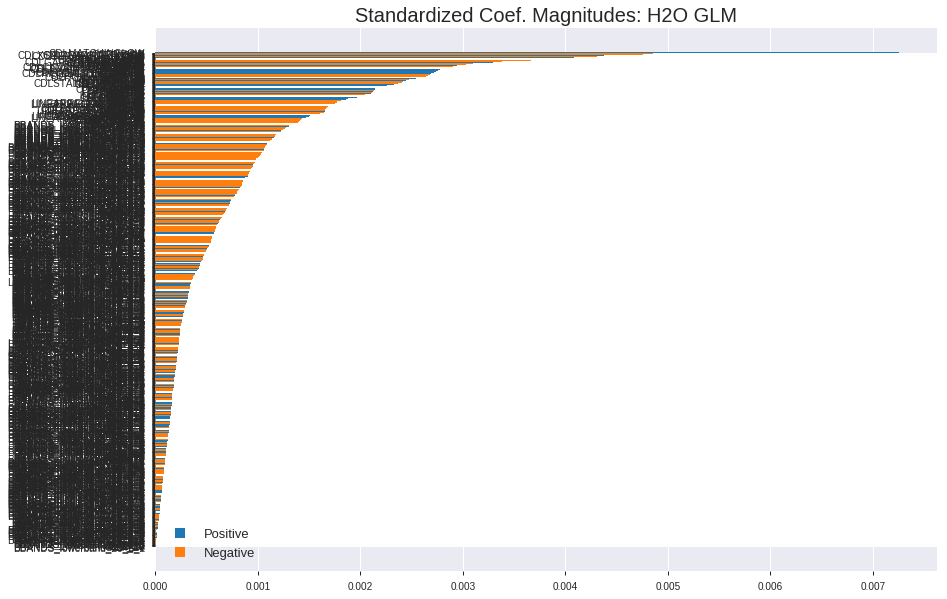

'log_likelihood'
--2019-08-25 16:52:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_165147_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_165147_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

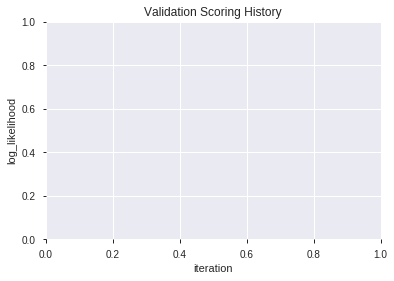

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190825_165320  0.568089  0.709199              0.477039  0.507398  0.257453
1               XGBoost_3_AutoML_20190825_165320  0.567518  0.696003              0.496094  0.500784  0.250785
2  XGBoost_grid_1_AutoML_20190825_165320_model_1  0.565422  0.714918              0.496094  0.508931  0.259011
3  XGBoost_grid_1_AutoML_20190825_165320_model_4  0.563199  0.693891              0.496094  0.500323  0.250323
4  XGBoost_grid_1_AutoML_20190825_165320_model_7  0.552782  0.717422              0.488440  0.509850  0.259947
5  XGBoost_grid_1_AutoML_20190825_165320_model_3  0.550559  0.759487              0.492188  0.527676  0.278442
6  XGBoost_grid_1_AutoML_20190825_165320_model_2  0.544398  0.692614              0.492188  0.499629  0.249629
7  XGBoost_grid_1_AutoML_20190825_165320_model_6  0.533727  0.701483              0.492346  0.503694  0.253708
8  XGBoost_grid_1_AutoML_20190825_165320_model_5  0.530615  0.724697              0.484534  0.513166  0.263339
9               XGBoost_1_AutoML_20190825_165320  0.527884  0.729294              0.492188  0.515428  0.265666

variable  relative_importance  scaled_importance  percentage
0                        BOP           140.418488           1.000000    0.021314
1                     Volume           130.534180           0.929608    0.019813
2                  CORREL_12           102.413773           0.729347    0.015545
3                     MFI_14           102.107124           0.727163    0.015498
4                   CORREL_8            96.976105           0.690622    0.014720
..                       ...                  ...                ...         ...
324              LINEARREG_8             2.338692           0.016655    0.000355
325  BBANDS_lowerband_14_5_5             1.849440           0.013171    0.000281
326  BBANDS_upperband_24_2_3             1.788834           0.012739    0.000272
327  BBANDS_upperband_30_6_4             1.606573           0.011441    0.000244
328  BBANDS_upperband_14_2_3             0.576220           0.004104    0.000087

[329 rows x 4 columns]

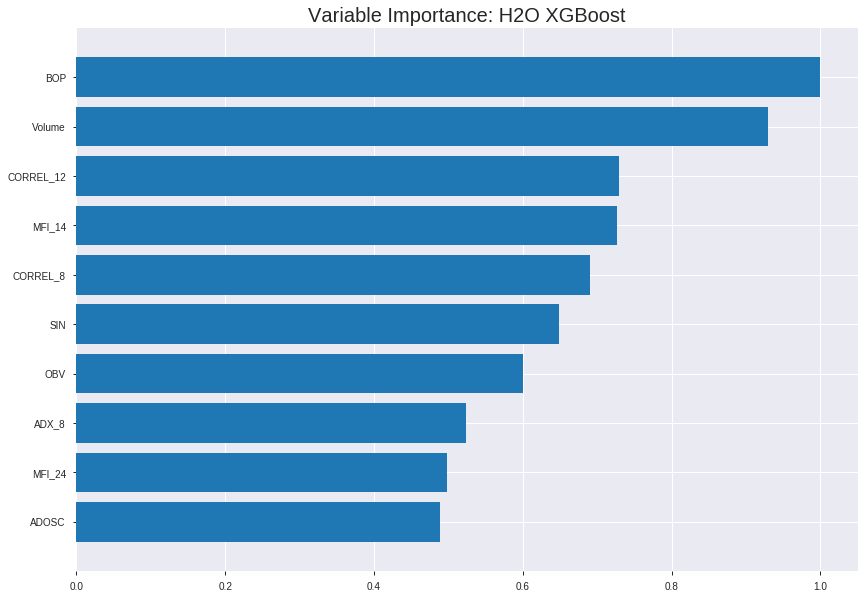

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190825_165320


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16877341973756896
RMSE: 0.4108204227367098
LogLoss: 0.5241960765426976
Mean Per-Class Error: 0.13633625410733852
AUC: 0.9370983935742971
pr_auc: 0.9436226080548461
Gini: 0.8741967871485943
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4937826267310551: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      695  145  0.1726   (145.0/840.0)
1      92   821  0.1008   (92.0/913.0)
Total  787  966  0.1352   (237.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493783     0.873869  220
max f2                       0.44608      0.908903  258
max f0point5                 0.553579     0.889712  174
max accuracy                 0.493783     0.864803  220
max precision                0.830968     1         0
max recall                   0.340194     1         337
max specificity              0.830968     1         0
max absolute_mcc             0.493783     0.729799  220
max min_per_class_accuracy   0.508112     0.859524  208
max mean_per_class_accuracy  0.503821     0.863664  212

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.774424           1.92004    1.92004            1                0.797924  1                           0.797924            0.0197152       0.0197152                  92.0044   92.0044
    2        0.0205362                   0.755525           1.92004    1.92004            1                0.764414  1                           0.781169            0.0197152       0.0394304                  92.0044   92.0044
    3        0.0302339                   0.744295           1.92004    1.92004            1                0.749038  1                           0.770863            0.0186199       0.0580504                  92.0044   92.0044
    4        0.040502                    0.735163           1.92004    1.92004            1                0.740258  1                           0.763104            0.0197152       0.0777656                  92.0044   92.0044
    5        0.0501997                   0.726599           1.92004    1.92004            1                0.730524  1                           0.75681             0.0186199       0.0963855                  92.0044   92.0044
    6        0.100399                    0.693818           1.92004    1.92004            1                0.708854  1                           0.732832            0.0963855       0.192771                   92.0044   92.0044
    7        0.150029                    0.667813           1.89797    1.91274            0.988506         0.681087  0.996198                    0.715715            0.094195        0.286966                   89.7974   91.2743
    8        0.200228                    0.645451           1.87641    1.90363            0.977273         0.655998  0.991453                    0.700743            0.094195        0.381161                   87.6406   90.3633
    9        0.300057                    0.601259           1.75547    1.85434            0.914286         0.623358  0.965779                    0.674997            0.175246        0.556407                   75.5469   85.4339
    10       0.399886                    0.564703           1.62381    1.79679            0.845714         0.583417  0.935806                    0.652135            0.162103        0.71851                    62.3808   79.6789
    11       0.500285                    0.515424           1.23276    1.6836             0.642045         0.541825  0.876853                    0.629997            0.123768        0.842278                   23.2755   68.3596
    12       0.600114                    0.476391           0.811904   1.53859            0.422857         0.494497  0.801331                    0.607457            0.0810515       0.92333                    -18.8096  53.859
    13       0.699943                    0.43422            0.449839   1.38331            0.234286         0.454618  0.720456                    0.585658            0.0449069       0.968237                   -55.0161  38.3308
    14       0.799772                    0.391722           0.208462   1.23666            0.108571         0.414016  0.64408                     0.564234            0.0208105       0.989047                   -79.1538  23.6662
    15       0.899601                    0.340182           0.0987451  1.11039            0.0514286        0.367466  0.578313                    0.542398            0.00985761      0.998905                   -90.1255  11.0387
    16       1                           0.175964           0.0109093  1                  0.00568182       0.297697  0.520821                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2722794752158412
RMSE: 0.5218040582592677
LogLoss: 0.7413054200314789
Mean Per-Class Error: 0.45409196067090807
AUC: 0.5405099286678234
pr_auc: 0.5936686097336267
Gini: 0.08101985733564687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24404273927211761: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    224  0.9825   (224.0/228.0)
1      2    271  0.0073   (2.0/273.0)
Total  6    495  0.4511   (226.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244043     0.705729  393
max f2                       0.212905     0.856874  399
max f0point5                 0.244043     0.60142   393
max accuracy                 0.244043     0.548902  393
max precision                0.702096     1         0
max recall                   0.212905     1         399
max specificity              0.702096     1         0
max absolute_mcc             0.603892     0.109573  10
max min_per_class_accuracy   0.38026      0.542125  202
max mean_per_class_accuracy  0.381782     0.545908  199

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 39.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.625734           1.5293    1.5293             0.833333         0.667969  0.833333                    0.667969            0.018315        0.018315                   52.9304    52.9304
    2        0.0219561                   0.603892           1.83516   1.66833            1                0.610154  0.909091                    0.64169             0.018315        0.03663                    83.5165    66.8332
    3        0.0319361                   0.590867           0.734066  1.37637            0.4              0.59833   0.75                        0.62814             0.00732601      0.043956                   -26.5934   37.6374
    4        0.0419162                   0.576474           1.1011    1.31083            0.6              0.582185  0.714286                    0.617198            0.010989        0.0549451                  10.1099    31.0832
    5        0.0518962                   0.564354           0.734066  1.19992            0.4              0.56624   0.653846                    0.607399            0.00732601      0.0622711                  -26.5934   19.9915
    6        0.101796                    0.511271           1.17451   1.18746            0.64             0.528799  0.647059                    0.568869            0.0586081       0.120879                   17.4505    18.746
    7        0.151697                    0.475167           0.954286  1.11076            0.52             0.489252  0.605263                    0.54268             0.047619        0.168498                   -4.57143   11.0758
    8        0.201597                    0.461077           1.46813   1.19922            0.8              0.467164  0.653465                    0.523988            0.0732601       0.241758                   46.8132    19.9217
    9        0.301397                    0.428828           0.770769  1.05735            0.42             0.443144  0.576159                    0.497218            0.0769231       0.318681                   -22.9231   5.73466
    10       0.401198                    0.404008           1.02769   1.04997            0.56             0.416764  0.572139                    0.477205            0.102564        0.421245                   2.76923    4.99699
    11       0.500998                    0.380221           1.21121   1.08209            0.66             0.390279  0.589641                    0.459889            0.120879        0.542125                   21.1209    8.20892
    12       0.600798                    0.365737           0.880879  1.04867            0.48             0.373084  0.571429                    0.44547             0.0879121       0.630037                   -11.9121   4.86656
    13       0.700599                    0.344285           0.917582  1.02999            0.5              0.354299  0.561254                    0.432482            0.0915751       0.721612                   -8.24176   2.99928
    14       0.800399                    0.320964           0.770769  0.997671           0.42             0.334573  0.543641                    0.420274            0.0769231       0.798535                   -22.9231   -0.232934
    15       0.9002                      0.282238           0.990989  0.99693            0.54             0.301231  0.543237                    0.407077            0.0989011       0.897436                   -0.901099  -0.30701
    16       1                           0.212905           1.02769   1                  0.56             0.260228  0.54491                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:53:24  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.479179                         0.5                0.693147              0.5               0                    1                  0.45509
    2019-08-25 16:53:25  0.749 sec   5                  0.488302         0.669971            0.760069        0.770355           1.81337          0.34227                          0.503191           0.699568              0.470857          0.533534             1.04867            0.45509
    2019-08-25 16:53:25  1.363 sec   10                 0.476759         0.647472            0.814972        0.825242           1.92004          0.262407                         0.503969           0.701182              0.503342          0.559314             0.917582           0.451098
    2019-08-25 16:53:26  1.966 sec   15                 0.466284         0.627307            0.847838        0.858784           1.92004          0.247576                         0.508601           0.710757              0.509455          0.566876             1.22344            0.449102
    2019-08-25 16:53:27  2.539 sec   20                 0.456563         0.608772            0.864216        0.873379           1.92004          0.207074                         0.510599           0.715031              0.524926          0.573992             0.917582           0.451098
    2019-08-25 16:53:27  3.141 sec   25                 0.447766         0.592205            0.883444        0.890848           1.92004          0.199658                         0.51142            0.716947              0.525304          0.572145             1.22344            0.453094
    2019-08-25 16:53:28  3.787 sec   30                 0.440083         0.577752            0.893988        0.904413           1.92004          0.184256                         0.516318           0.727786              0.527866          0.576136             1.22344            0.45509
    2019-08-25 16:53:29  4.436 sec   35                 0.432116         0.562919            0.904713        0.914572           1.92004          0.173417                         0.517421           0.730541              0.53896           0.589837             1.5293             0.451098
    2019-08-25 16:53:29  5.002 sec   40                 0.425183         0.550114            0.915217        0.92298            1.92004          0.162008                         0.518618           0.733505              0.542502          0.590551             1.5293             0.45509
    2019-08-25 16:53:30  5.639 sec   45                 0.41781          0.536835            0.928871        0.936702           1.92004          0.144894                         0.519832           0.736425              0.545498          0.590317             1.5293             0.453094
    2019-08-25 16:53:30  6.261 sec   50                 0.41082          0.524196            0.937098        0.943623           1.92004          0.135197                         0.521804           0.741305              0.54051           0.593669             1.5293             0.451098

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      140.41848754882812     1.0                   0.021313517310092782
Volume                   130.5341796875         0.9296082158847422    0.01981322080086392
CORREL_12                102.41377258300781     0.7293467859593288    0.015544945347604687
MFI_14                   102.10712432861328     0.7271629691432709    0.015498400530093569
CORREL_8                 96.97610473632812      0.6906220571746747    0.014719585170324316
---                      ---                    ---                   ---
LINEARREG_8              2.3386917114257812     0.01665515525947067   0.00035497993992501093
BBANDS_lowerband_14_5_5  1.8494396209716797     0.013170912557568809  0.0002807184727854612
BBANDS_upperband_24_2_3  1.7888336181640625     0.01273930270429687   0.00027151934870654315
BBANDS_upperband_30_6_4  1.6065731048583984     0.011441321815261257  0.00024385481055991297
BBANDS_upperband_14_2_3  0.5762195587158203     0.004103587560117038  8.74618844960359e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6629834254143646)

('auc', 0.568089430894309)

('logloss', 0.709198935510086)

('mean_per_class_error', 0.4372459349593496)

('rmse', 0.5073979470237967)

('mse', 0.25745267664396365)

xgboost prediction progress: |████████████████████████████████████████████| 100%


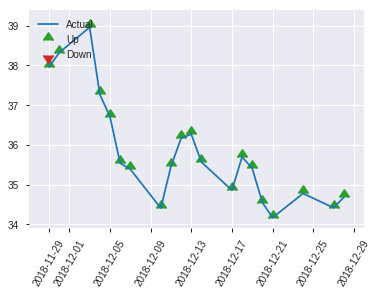


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25745267664396365
RMSE: 0.5073979470237967
LogLoss: 0.709198935510086
Mean Per-Class Error: 0.4372459349593496
AUC: 0.568089430894309
pr_auc: 0.5578477865654496
Gini: 0.13617886178861793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2757567763328552: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    119  0.9297   (119.0/128.0)
1      3    120  0.0244   (3.0/123.0)
Total  12   239  0.4861   (122.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275757     0.662983  238
max f2                       0.243456     0.828841  249
max f0point5                 0.32985      0.571429  187
max accuracy                 0.425428     0.561753  80
max precision                0.555998     1         0
max recall                   0.243456     1         249
max specificity              0.555998     1         0
max absolute_mcc             0.32985      0.144704  187
max min_per_class_accuracy   0.383352     0.539062  125
max mean_per_class_accuracy  0.32985      0.562754  187

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 38.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.514997           2.04065   2.04065            1                0.53157   1                           0.53157             0.0243902       0.0243902                  104.065   104.065
    2        0.0239044                   0.512162           1.36043   1.70054            0.666667         0.513002  0.833333                    0.522286            0.0162602       0.0406504                  36.0434   70.0542
    3        0.0318725                   0.504027           0         1.27541            0                0.507529  0.625                       0.518597            0               0.0406504                  -100      27.5407
    4        0.0438247                   0.494401           2.04065   1.48411            1                0.498986  0.727273                    0.513248            0.0243902       0.0650407                  104.065   48.4109
    5        0.0517928                   0.490431           0         1.25578            0                0.49192   0.615385                    0.509967            0               0.0650407                  -100      25.5785
    6        0.103586                    0.474503           1.25578   1.25578            0.615385         0.480021  0.615385                    0.494994            0.0650407       0.130081                   25.5785   25.5785
    7        0.151394                    0.456753           1.19038   1.23513            0.583333         0.468948  0.605263                    0.486769            0.0569106       0.186992                   19.0379   23.5131
    8        0.203187                    0.447776           1.25578   1.2404             0.615385         0.4511    0.607843                    0.477677            0.0650407       0.252033                   25.5785   24.0395
    9        0.302789                    0.427652           0.979512  1.15458            0.48             0.436844  0.565789                    0.464245            0.097561        0.349593                   -2.04878  15.4579
    10       0.40239                     0.404248           0.979512  1.11125            0.48             0.416778  0.544554                    0.452496            0.097561        0.447154                   -2.04878  11.1245
    11       0.501992                    0.383352           0.979512  1.08511            0.48             0.394767  0.531746                    0.441042            0.097561        0.544715                   -2.04878  8.51078
    12       0.601594                    0.357439           0.897886  1.05411            0.44             0.372277  0.516556                    0.429657            0.0894309       0.634146                   -10.2114  5.41108
    13       0.701195                    0.340118           1.06114   1.05511            0.52             0.347549  0.517045                    0.417994            0.105691        0.739837                   6.11382   5.5109
    14       0.800797                    0.318915           0.979512  1.04571            0.48             0.327662  0.512438                    0.406758            0.097561        0.837398                   -2.04878  4.57064
    15       0.900398                    0.299252           0.81626   1.02033            0.4              0.307512  0.5                         0.39578             0.0813008       0.918699                   -18.374   2.03252
    16       1                           0.237716           0.81626   1                  0.4              0.274816  0.49004                     0.383732          

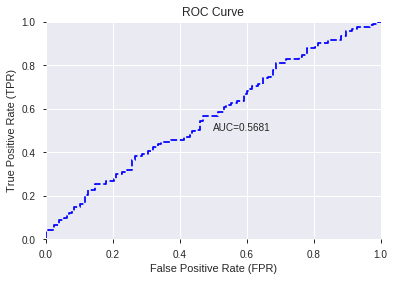

This function is available for GLM models only


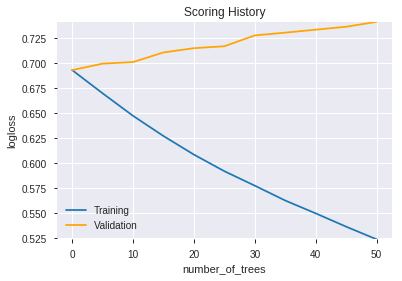

--2019-08-25 16:54:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


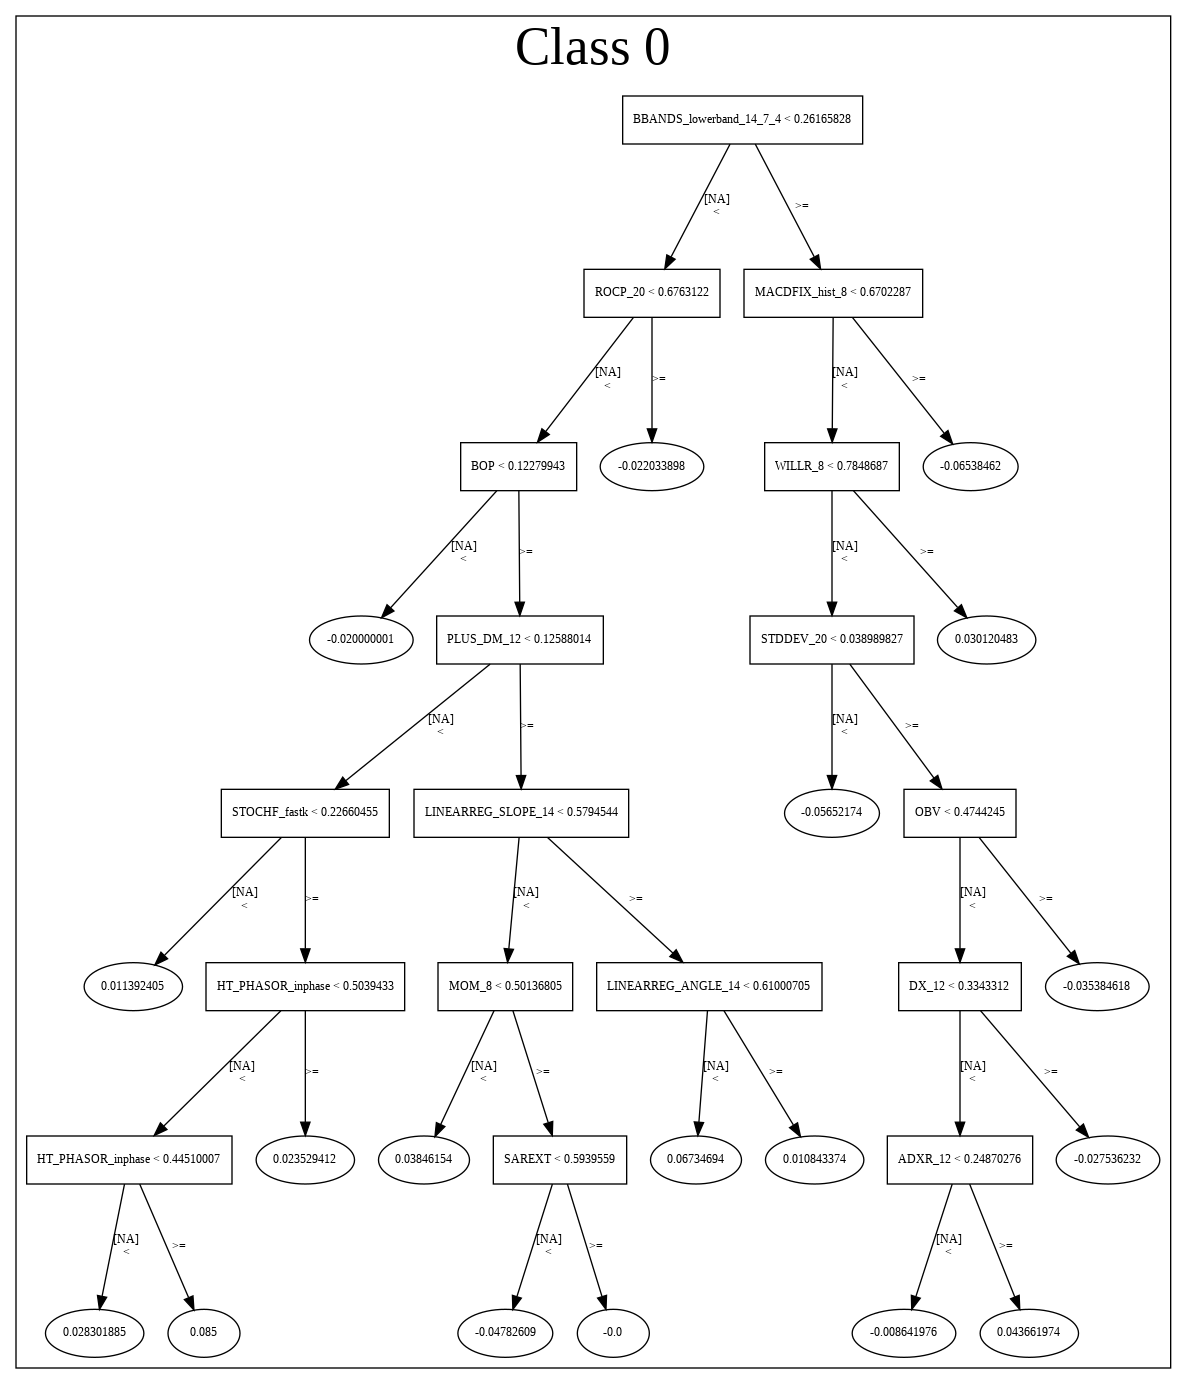

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190825_165320',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190825_165320',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_ada5',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_165507_model_7  0.569360  0.715533              0.431752  0.506634  0.256678
1  DeepLearning_grid_1_AutoML_20190825_165507_model_8  0.551258  0.695339              0.472974  0.501075  0.251076
2  DeepLearning_grid_1_AutoML_20190825_165507_model_4  0.548844  0.921709              0.488281  0.560037  0.313642
3  DeepLearning_grid_1_AutoML_20190825_165507_model_1  0.537792  1.391804              0.469226  0.614059  0.377069
4  DeepLearning_grid_1_AutoML_20190825_165507_model_9  0.525216  0.692678              0.484693  0.499765  0.249765
5  DeepLearning_grid_1_AutoML_20190825_165507_model_6  0.522421  0.732757              0.496094  0.516661  0.266938
6  DeepLearning_grid_1_AutoML_20190825_165507_model_3  0.512322  0.894219              0.480786  0.561322  0.315083
7  DeepLearning_grid_1_AutoML_20190825_165507_model_5  0.510480  0.706036              0.465320  0.505985  0.256021
8  DeepLearning_grid_1_AutoML_20190825_165507_model_2  0.481517  1.456910              0.488281  0.623283  0.388481
9               DeepLearning_1_AutoML_20190825_165507  0.473133  1.037130              0.500000  0.587253  0.344867

variable  relative_importance  scaled_importance  percentage
0         STOCHRSI_fastd             1.000000           1.000000    0.021313
1              dayofweek             0.998824           0.998824    0.021288
2           HT_TRENDMODE             0.982977           0.982977    0.020950
3                NATR_24             0.981955           0.981955    0.020928
4                 ADXR_8             0.969726           0.969726    0.020668
5                BETA_12             0.968850           0.968850    0.020649
6             aroonup_30             0.967158           0.967158    0.020613
7         CDLRICKSHAWMAN             0.967074           0.967074    0.020611
8               CORREL_8             0.963485           0.963485    0.020535
9                    OBV             0.960367           0.960367    0.020468
10            aroonup_14             0.959314           0.959314    0.020446
11          MACDEXT_hist             0.958157           0.958157    0.020421
12           aroondown_8             0.956703           0.956703    0.020390
13        STOCHRSI_fastk             0.956584           0.956584    0.020388
14                ADX_14             0.956360           0.956360    0.020383
15               quarter             0.954991           0.954991    0.020354
16  HT_PHASOR_quadrature             0.953776           0.953776    0.020328
17               weekday             0.947025           0.947025    0.020184
18               CDLDOJI             0.946655           0.946655    0.020176
19               BETA_20             0.941384           0.941384    0.020064
20                  week             0.940712           0.940712    0.020049
21          aroondown_12             0.940509           0.940509    0.020045
22               BETA_30             0.940491           0.940491    0.020045
23          aroondown_14             0.940330           0.940330    0.020041
24               BETA_24             0.940248           0.940248    0.020039
25            AROONOSC_8             0.939665           0.939665    0.020027
26                ADX_24             0.939488           0.939488    0.020023
27             aroonup_8             0.936780           0.936780    0.019966
28                  DX_8             0.936022           0.936022    0.019949
29                   SIN             0.931774           0.931774    0.019859
30                MFI_12             0.931274           0.931274    0.019848
31                 DX_12             0.929643           0.929643    0.019813
32                 month             0.927812           0.927812    0.019774
33          weekday_name             0.926463           0.926463    0.019746
34                   BOP             0.924900           0.924900    0.019712
35            aroonup_20             0.922660           0.922660    0.019665
36                MFI_14             0.921913           0.921913    0.019649
37          STOCHF_fastk             0.920515           0.920515    0.019619
38               ADXR_14             0.919550           0.919550    0.019598
39          aroondown_24             0.918853           0.918853    0.019583
40            PLUS_DI_20             0.916282           0.916282    0.019529
41           AROONOSC_14             0.913953           0.913953    0.019479
42                BETA_8             0.912913           0.912913    0.019457
43               ADXR_12             0.910855           0.910855    0.019413
44           AROONOSC_30             0.903891           0.903891    0.019265
45                ADX_20             0.900218           0.900218    0.019186
46            aroonup_24             0.899030           0.899030    0.019161
47               BETA_14             0.887176           0.887176    0.018908
48     CDLLONGLEGGEDDOJI             0.884602           0.884602    0.018853
49                SAREXT             0.869924           0.869924    0.018541

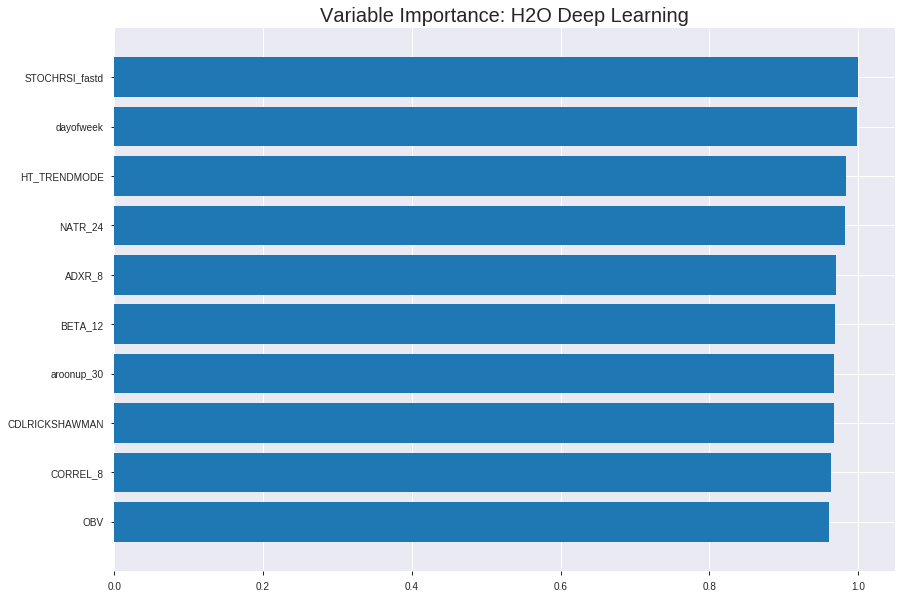

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_165507_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.214169916645049
RMSE: 0.4627849572372129
LogLoss: 0.615806573469938
Mean Per-Class Error: 0.34941128148959477
AUC: 0.7165349710530433
pr_auc: 0.7259161693707742
Gini: 0.4330699421060866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41888825497959786: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      323  517   0.6155   (517.0/840.0)
1      102  811   0.1117   (102.0/913.0)
Total  425  1328  0.3531   (619.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418888     0.723784  269
max f2                       0.25119      0.852902  353
max f0point5                 0.532666     0.664704  186
max accuracy                 0.470069     0.654877  232
max precision                0.991203     1         0
max recall                   0.0830441    1         393
max specificity              0.991203     1         0
max absolute_mcc             0.418888     0.318004  269
max min_per_class_accuracy   0.515998     0.642935  200
max mean_per_class_accuracy  0.487895     0.650589  220

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.908164           1.81337   1.81337            0.944444         0.941561  0.944444                    0.941561            0.0186199       0.0186199                  81.3375   81.3375
    2        0.0205362                   0.859              1.70671   1.76004            0.888889         0.880115  0.916667                    0.910838            0.0175246       0.0361446                  70.6706   76.004
    3        0.0302339                   0.808753           1.8071    1.77513            0.941176         0.82766   0.924528                    0.884158            0.0175246       0.0536692                  80.71     77.5135
    4        0.040502                    0.791482           1.70671   1.75779            0.888889         0.798131  0.915493                    0.862349            0.0175246       0.0711939                  70.6706   75.7787
    5        0.0501997                   0.777602           1.92004   1.78913            1                0.782829  0.931818                    0.846987            0.0186199       0.0898138                  92.0044   78.9132
    6        0.100399                    0.704765           1.46185   1.62549            0.761364         0.737258  0.846591                    0.792122            0.0733844       0.163198                   46.1852   62.5492
    7        0.150029                    0.659589           1.39038   1.54772            0.724138         0.678862  0.806084                    0.754656            0.0690033       0.232202                   39.0377   54.7716
    8        0.200228                    0.629797           1.2873    1.48243            0.670455         0.644471  0.77208                     0.727031            0.0646221       0.296824                   28.7302   48.2427
    9        0.300057                    0.586302           1.25077   1.40536            0.651429         0.607347  0.731939                    0.687213            0.124863        0.421687                   25.0771   40.5355
    10       0.399886                    0.549972           1.17397   1.34759            0.611429         0.568108  0.701854                    0.657479            0.117196        0.538883                   17.397    34.7591
    11       0.500285                    0.516213           1.02548   1.28295            0.534091         0.532109  0.668187                    0.632319            0.102957        0.64184                    2.54779   28.2948
    12       0.600114                    0.479144           0.987451  1.23379            0.514286         0.498313  0.642586                    0.610027            0.0985761       0.740416                   -1.25489  23.3792
    13       0.699943                    0.442332           0.932593  1.19083            0.485714         0.460444  0.620212                    0.588693            0.0930997       0.833516                   -6.74073  19.0834
    14       0.799772                    0.399019           0.800933  1.14217            0.417143         0.421621  0.594864                    0.567839            0.0799562       0.913472                   -19.9067  14.2166
    15       0.899601                    0.316973           0.603442  1.08238            0.314286         0.36173   0.563729                    0.544967            0.060241        0.973713                   -39.6558  8.23836
    16       1                           0.0278248          0.261824  1                  0.136364         0.240114  0.520821                    0.51436           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2776768351416418
RMSE: 0.5269505054003097
LogLoss: 0.7614540874049849
Mean Per-Class Error: 0.46086369770580293
AUC: 0.5280428635691794
pr_auc: 0.5700958531194973
Gini: 0.0560857271383588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09161420036079979: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    227  0.9956   (227.0/228.0)
1      0    273  0        (0.0/273.0)
Total  1    500  0.4531   (227.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0916142    0.706339  398
max f2                       0.0916142    0.857412  398
max f0point5                 0.0916142    0.600528  398
max accuracy                 0.264241     0.550898  334
max precision                0.990687     1         0
max recall                   0.0916142    1         398
max specificity              0.990687     1         0
max absolute_mcc             0.483247     0.08333   133
max min_per_class_accuracy   0.427674     0.516484  200
max mean_per_class_accuracy  0.483247     0.539136  133

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 41.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.719029           1.22344   1.22344            0.666667         0.816169  0.666667                    0.816169            0.014652        0.014652                   22.3443    22.3443
    2        0.0219561                   0.668359           1.46813   1.33467            0.8              0.680439  0.727273                    0.754474            0.014652        0.029304                   46.8132    33.4665
    3        0.0319361                   0.644005           0.367033  1.03228            0.2              0.657156  0.5625                      0.724062            0.003663        0.032967                   -63.2967   3.22802
    4        0.0419162                   0.622979           1.46813   1.13605            0.8              0.632043  0.619048                    0.702153            0.014652        0.047619                   46.8132    13.6054
    5        0.0518962                   0.606642           1.46813   1.19992            0.8              0.613175  0.653846                    0.685042            0.014652        0.0622711                  46.8132    19.9915
    6        0.101796                    0.580258           0.954286  1.07951            0.52             0.592572  0.588235                    0.639713            0.047619        0.10989                    -4.57143   7.95087
    7        0.151697                    0.552276           1.02769   1.06246            0.56             0.562982  0.578947                    0.614473            0.0512821       0.161172                   2.76923    6.24639
    8        0.201597                    0.533266           0.880879  1.01752            0.48             0.540755  0.554455                    0.596226            0.043956        0.205128                   -11.9121   1.75171
    9        0.301397                    0.493998           1.28462   1.10596            0.7              0.512292  0.602649                    0.568433            0.128205        0.333333                   28.4615    10.596
    10       0.401198                    0.458386           0.880879  1.04997            0.48             0.474435  0.572139                    0.54505             0.0879121       0.421245                   -11.9121   4.99699
    11       0.500998                    0.427668           0.954286  1.03091            0.52             0.443639  0.561753                    0.524849            0.0952381       0.516484                   -4.57143   3.09093
    12       0.600798                    0.390568           1.1011    1.04257            0.6              0.407266  0.568106                    0.505317            0.10989         0.626374                   10.1099    4.25687
    13       0.700599                    0.342878           0.807473  1.00908            0.44             0.365506  0.549858                    0.485401            0.0805861       0.70696                    -19.2527   0.907924
    14       0.800399                    0.286247           1.02769   1.0114             0.56             0.317761  0.551122                    0.464498            0.102564        0.809524                   2.76923    1.14001
    15       0.9002                      0.225434           0.917582  1.001              0.5              0.262088  0.545455                    0.442058            0.0915751       0.901099                   -8.24176   0.0999001
    16       1                           0.0595692          0.990989  1                  0.54             0.162997  0.54491                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:00:04  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:00:11  7.735 sec         232 obs/sec       0.82259   1             1442       0.596526         1.09947             -0.425848      0.566923        0.588863           1.17336          0.474044                         0.559847           0.90491               -0.263912        0.541554          0.579516             1.22344            0.45509
    2019-08-25 17:00:25  22.477 sec        440 obs/sec       4.89447   6             8580       0.462785         0.615807            0.141832       0.716535        0.725916           1.81337          0.353109                         0.526951           0.761454              -0.119741        0.528043          0.570096             1.22344            0.453094
    2019-08-25 17:00:42  38.556 sec        501 obs/sec       9.749     12            17090      0.424378         0.528991            0.278361       0.809487        0.823435           1.92004          0.281803                         0.562158           0.923075              -0.274367        0.542655          0.583805             1.5293             0.451098
    2019-08-25 17:00:58  54.620 sec        527 obs/sec       14.648    18            25678      0.367894         0.41443             0.457675       0.891866        0.880831           1.92004          0.193383                         0.597655           1.2                   -0.440389        0.533602          0.56481              1.22344            0.451098
    2019-08-25 17:01:14  1 min 10.734 sec  541 obs/sec       19.5351   24            34245      0.335374         0.35618             0.549315       0.934493        0.912271           1.92004          0.137479                         0.646969           1.60797               -0.687894        0.502217          0.539801             1.22344            0.45509
    2019-08-25 17:01:31  1 min 27.570 sec  544 obs/sec       24.433    30            42831      0.316927         0.318487            0.59753        0.957574        0.801829           1.92004          0.107815                         0.606645           1.47362               -0.484046        0.537088          0.561067             1.5293             0.45509
    2019-08-25 17:01:32  1 min 29.068 sec  544 obs/sec       24.433    30            42831      0.462785         0.615807            0.141832       0.716535        0.725916           1.81337          0.353109                         0.526951           0.761454              -0.119741        0.528043          0.570096             1.22344            0.453094

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
STOCHRSI_fastd     1.0                    1.0                  0.021312960013301088
dayofweek          0.998823881149292      0.998823881149292    0.021287893439265057
HT_TRENDMODE       0.9829770922660828     0.9829770922660828   0.020950151461457997
NATR_24            0.9819551110267639     0.9819551110267639   0.02092837001617005
ADXR_8             0.9697262048721313     0.9697262048721313   0.020667735828289954
---                ---                    ---                  ---
ADX_20             0.9002181887626648     0.9002181887626648   0.019186314260345005
aroonup_24         0.8990297913551331     0.8990297913551331   0.01916098599391837
BETA_14            0.8871757984161377     0.8871757984161377   0.01890834231641161
CDLLONGLEGGEDDOJI  0.8846017718315125     0.8846017718315125   0.018853482190740317
SAREXT             0.8699244260787964     0.8699244260787964   0.018540664507611285


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5856573705179283)

('F1', 0.6666666666666667)

('auc', 0.569359756097561)

('logloss', 0.7155331229824012)

('mean_per_class_error', 0.4100609756097561)

('rmse', 0.5066342495391262)

('mse', 0.25667826280607353)

deeplearning prediction progress: |███████████████████████████████████████| 100%


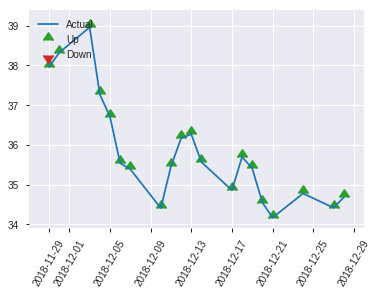


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25667826280607353
RMSE: 0.5066342495391262
LogLoss: 0.7155331229824012
Mean Per-Class Error: 0.4100609756097561
AUC: 0.569359756097561
pr_auc: 0.5177346470820239
Gini: 0.1387195121951219
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32443393543360455: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      31   97   0.7578   (97.0/128.0)
1      13   110  0.1057   (13.0/123.0)
Total  44   207  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324434     0.666667  206
max f2                       0.0782194    0.828841  249
max f0point5                 0.380205     0.589988  178
max accuracy                 0.380205     0.585657  178
max precision                0.773148     0.666667  2
max recall                   0.0782194    1         249
max specificity              0.805829     0.992188  0
max absolute_mcc             0.380205     0.198812  178
max min_per_class_accuracy   0.48151      0.552846  122
max mean_per_class_accuracy  0.380205     0.589939  178

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 46.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.772685           1.36043   1.36043            0.666667         0.787866  0.666667                    0.787866            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.757605           0         0.680217           0                0.766231  0.333333                    0.777049            0               0.0162602                  -100      -31.9783
    3        0.0318725                   0.72979            2.04065   1.02033            1                0.733207  0.5                         0.766088            0.0162602       0.0325203                  104.065   2.03252
    4        0.0438247                   0.709205           1.36043   1.11308            0.666667         0.715897  0.545455                    0.7524              0.0162602       0.0487805                  36.0434   11.3082
    5        0.0517928                   0.701709           0         0.941839           0                0.7052    0.461538                    0.745138            0               0.0487805                  -100      -5.81614
    6        0.103586                    0.638688           0.784866  0.863352           0.384615         0.668664  0.423077                    0.706901            0.0406504       0.0894309                  -21.5134  -13.6648
    7        0.151394                    0.609609           1.36043   1.02033            0.666667         0.623828  0.5                         0.680667            0.0650407       0.154472                   36.0434   2.03252
    8        0.203187                    0.586373           0.941839  1.00032            0.461538         0.593785  0.490196                    0.658521            0.0487805       0.203252                   -5.81614  0.0318827
    9        0.302789                    0.553696           1.30602   1.10088            0.64             0.571603  0.539474                    0.62993             0.130081        0.333333                   30.6016   10.0877
    10       0.40239                     0.516371           1.14276   1.11125            0.56             0.532645  0.544554                    0.605849            0.113821        0.447154                   14.2764   11.1245
    11       0.501992                    0.473543           1.06114   1.1013             0.52             0.494875  0.539683                    0.58383             0.105691        0.552846                   6.11382   10.1303
    12       0.601594                    0.430252           1.06114   1.09465            0.52             0.453797  0.536424                    0.562302            0.105691        0.658537                   6.11382   9.46535
    13       0.701195                    0.388895           1.22439   1.11308            0.6              0.408027  0.545455                    0.540388            0.121951        0.780488                   22.439    11.3082
    14       0.800797                    0.337506           0.979512  1.09647            0.48             0.363429  0.537313                    0.518378            0.097561        0.878049                   -2.04878  9.64689
    15       0.900398                    0.259018           0.571382  1.03838            0.28             0.302143  0.50885                     0.494458            0.0569106       0.934959                   -42.8618  3.83841
    16       1                           0.0519745          0.653008  1                  0.32             0.176349  0.49004                     0.462774    

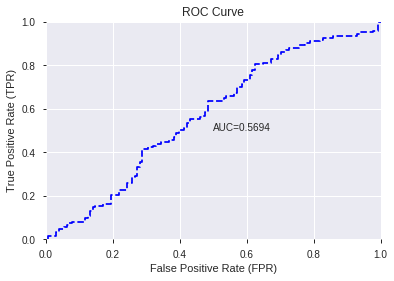

This function is available for GLM models only


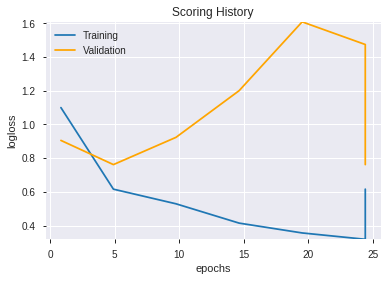

--2019-08-25 17:04:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


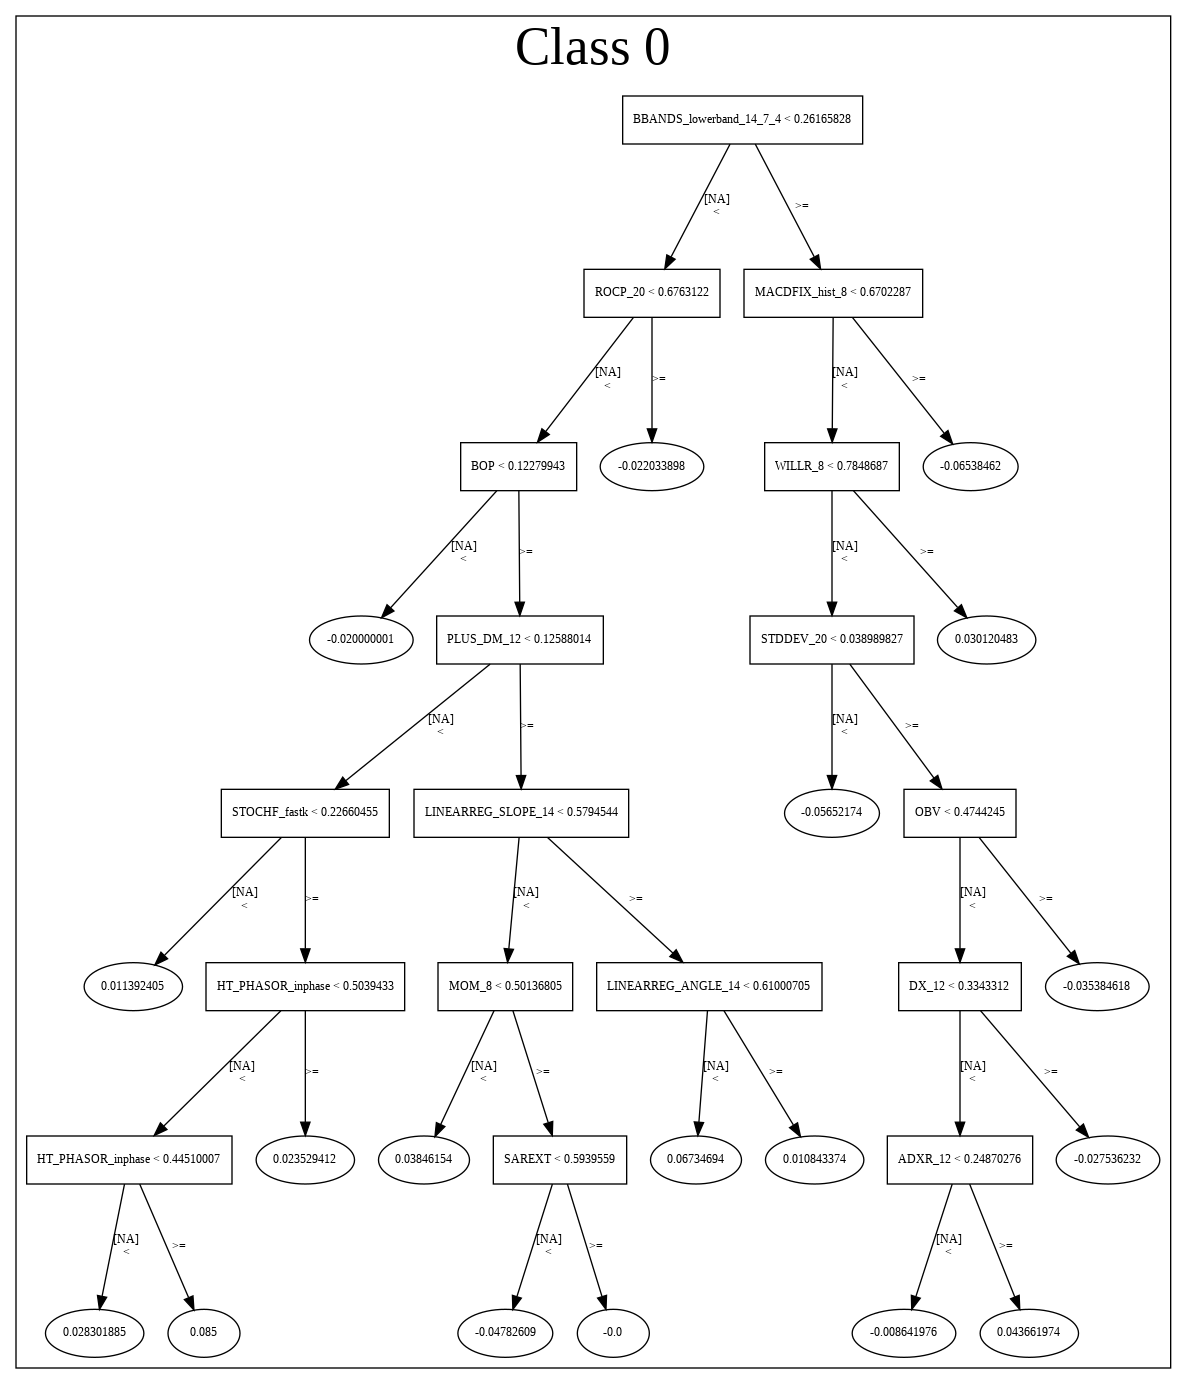

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_165507_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_165507_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHRSI_fastd',
 'dayofweek',
 'HT_TRENDMODE',
 'NATR_24',
 'ADXR_8',
 'BETA_12',
 'aroonup_30',
 'CDLRICKSHAWMAN',
 'CORREL_8',
 'OBV',
 'aroonup_14',
 'MACDEXT_hist',
 'aroondown_8',
 'STOCHRSI_fastk',
 'ADX_14',
 'quarter',
 'HT_PHASOR_quadrature',
 'weekday',
 'CDLDOJI',
 'BETA_20',
 'week',
 'aroondown_12',
 'BETA_30',
 'aroondown_14',
 'BETA_24',
 'AROONOSC_8',
 'ADX_24',
 'aroonup_8',
 'DX_8',
 'SIN',
 'MFI_12',
 'DX_12',
 'month',
 'weekday_name',
 'BOP',
 'aroonup_20',
 'MFI_14',
 'STOCHF_fastk',
 'ADXR_14',
 'aroondown_24',
 'PLUS_DI_20',
 'AROONOSC_14',
 'BETA_8',
 'ADXR_12',
 'AROONOSC_30',
 'ADX_20',
 'aroonup_24',
 'BETA_14',
 'CDLLONGLEGGEDDOJI',
 'SAREXT']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_170536_model_1  0.590828  0.690477              0.401296  0.498664  0.248665

variable  relative_importance  scaled_importance  percentage
0                    OBV             0.013606           1.000000    0.069454
1               CORREL_8             0.010827           0.795716    0.055266
2                NATR_24             0.010395           0.764023    0.053065
3                    SIN             0.010361           0.761498    0.052889
4         STOCHRSI_fastk             0.009651           0.709298    0.049264
5             PLUS_DI_20             0.009002           0.661607    0.045951
6                   DX_8             0.008853           0.650643    0.045190
7           HT_TRENDMODE             0.008137           0.598027    0.041536
8                 MFI_14             0.007785           0.572188    0.039741
9           STOCHF_fastk             0.007649           0.562169    0.039045
10                 DX_12             0.007604           0.558857    0.038815
11                MFI_12             0.007034           0.516999    0.035908
12                   BOP             0.005189           0.381397    0.026490
13               quarter             0.005074           0.372927    0.025901
14                 month             0.004780           0.351324    0.024401
15          aroondown_24             0.004577           0.336356    0.023361
16                BETA_8             0.004465           0.328150    0.022791
17                  week             0.003782           0.277980    0.019307
18          aroondown_14             0.003659           0.268940    0.018679
19               ADXR_14             0.003458           0.254144    0.017651
20               ADXR_12             0.003332           0.244916    0.017010
21               BETA_24             0.003303           0.242752    0.016860
22        CDLRICKSHAWMAN             0.003298           0.242397    0.016835
23                SAREXT             0.003006           0.220920    0.015344
24          MACDEXT_hist             0.002971           0.218353    0.015166
25            aroonup_20             0.002802           0.205902    0.014301
26               BETA_20             0.002755           0.202458    0.014062
27            aroonup_24             0.002628           0.193163    0.013416
28                ADX_14             0.002585           0.189953    0.013193
29            aroonup_14             0.002574           0.189176    0.013139
30                ADXR_8             0.002521           0.185309    0.012870
31  HT_PHASOR_quadrature             0.001861           0.136789    0.009501
32               BETA_30             0.001800           0.132279    0.009187
33                ADX_20             0.001632           0.119930    0.008330
34             aroonup_8             0.001407           0.103423    0.007183
35           AROONOSC_30             0.001383           0.101651    0.007060
36             dayofweek             0.001216           0.089362    0.006207
37               weekday             0.001203           0.088398    0.006140
38            aroonup_30             0.001149           0.084424    0.005864
39        STOCHRSI_fastd             0.001145           0.084154    0.005845
40          weekday_name             0.001077           0.079188    0.005500
41          aroondown_12             0.000839           0.061668    0.004283
42               BETA_14             0.000750           0.055157    0.003831
43            AROONOSC_8             0.000583           0.042813    0.002974
44           AROONOSC_14             0.000571           0.041933    0.002912
45                ADX_24             0.000562           0.041310    0.002869
46           aroondown_8             0.000399           0.029291    0.002034
47               BETA_12             0.000248           0.018237    0.001267
48     CDLLONGLEGGEDDOJI             0.000211           0.015515    0.001078
49               CDLDOJI             0.000203           0.014889    0.001034

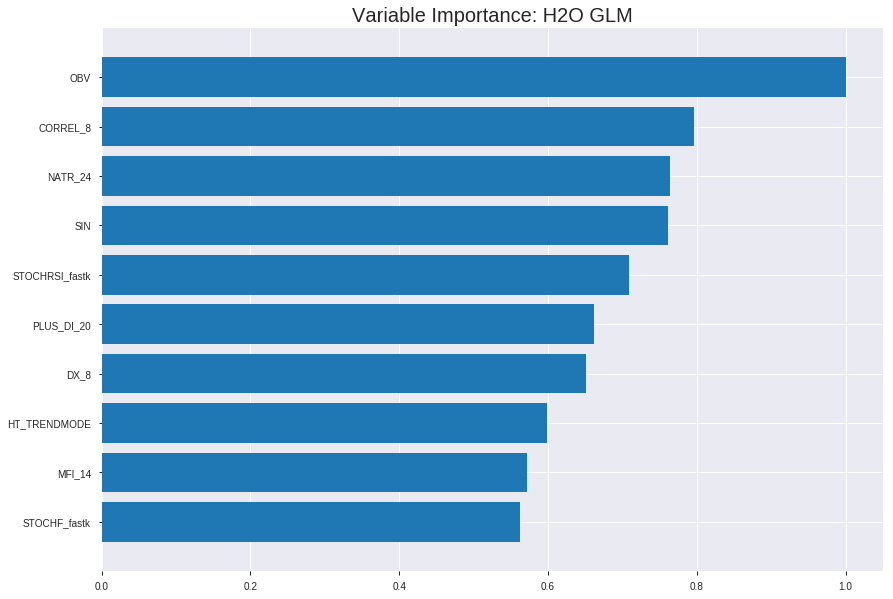

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_170536_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24800510246144122
RMSE: 0.4980011068877671
LogLoss: 0.689149989967627
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2427.133204280672
Residual deviance: 2416.1598648265
AIC: 2518.1598648265
AUC: 0.5857005945861368
pr_auc: 0.5929997101001895
Gini: 0.17140118917227354
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5014216911975871: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   791   0.9417   (791.0/840.0)
1      19   894   0.0208   (19.0/913.0)
Total  68   1685  0.4621   (810.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501422     0.688222  362
max f2                       0.489724     0.844745  398
max f0point5                 0.512952     0.590697  278
max accuracy                 0.521737     0.571021  189
max precision                0.557899     1         0
max recall                   0.489724     1         398
max specificity              0.557899     1         0
max absolute_mcc             0.521737     0.146932  189
max min_per_class_accuracy   0.520523     0.559693  203
max mean_per_class_accuracy  0.521737     0.573179  189

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.548316           1.49337   1.49337            0.777778         0.552127  0.777778                    0.552127            0.0153341       0.0153341                  49.3367   49.3367
    2        0.0205362                   0.544925           1.17336   1.33336            0.611111         0.546447  0.694444                    0.549287            0.0120482       0.0273823                  17.336    33.3364
    3        0.0302339                   0.543103           0.451775  1.05059            0.235294         0.544048  0.54717                     0.547606            0.00438116      0.0317634                  -54.8225  5.059
    4        0.040502                    0.541556           1.17336   1.08171            0.611111         0.54237   0.56338                     0.546279            0.0120482       0.0438116                  17.336    8.17148
    5        0.0501997                   0.540673           1.58121   1.17821            0.823529         0.54104   0.613636                    0.545267            0.0153341       0.0591457                  58.1213   17.8209
    6        0.100399                    0.536484           1.2873    1.23276            0.670455         0.538439  0.642045                    0.541853            0.0646221       0.123768                   28.7302   23.2755
    7        0.150029                    0.532396           1.14761   1.20459            0.597701         0.534428  0.627376                    0.539397            0.0569551       0.180723                   14.7612   20.459
    8        0.200228                    0.529977           1.24366   1.21439            0.647727         0.531002  0.632479                    0.537292            0.0624315       0.243154                   24.3665   21.4387
    9        0.300057                    0.526097           1.09717   1.17539            0.571429         0.527956  0.612167                    0.534186            0.109529        0.352683                   9.71679   17.5388
    10       0.399886                    0.522995           1.14105   1.16682            0.594286         0.524522  0.607703                    0.531773            0.11391         0.466594                   14.1055   16.6817
    11       0.500285                    0.520505           0.894566  1.11218            0.465909         0.521694  0.579247                    0.529751            0.0898138       0.556407                   -10.5434  11.218
    12       0.600114                    0.517504           0.921621  1.08048            0.48             0.519046  0.562738                    0.52797             0.0920044       0.648412                   -7.8379   8.04809
    13       0.699943                    0.515022           0.921621  1.05782            0.48             0.516264  0.550937                    0.5263              0.0920044       0.740416                   -7.8379   5.78236
    14       0.799772                    0.511458           0.976479  1.04767            0.508571         0.513227  0.545649                    0.524668            0.0974808       0.837897                   -2.35206  4.76701
    15       0.899601                    0.50665            0.844819  1.02516            0.44             0.509221  0.533925                    0.522954            0.0843373       0.922234                   -15.5181  2.51597
    16       1                           0.488236           0.774563  1                  0.403409         0.501711  0.520821                    0.520821            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24835695591858664
RMSE: 0.4983542474170223
LogLoss: 0.6898581917489602
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 691.6529992083883
Residual deviance: 691.2379081324582
AIC: 793.2379081324582
AUC: 0.5389917100443415
pr_auc: 0.5747851088298677
Gini: 0.07798342008868309
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48487410811001214: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484874     0.705426  399
max f2                       0.484874     0.856874  399
max f0point5                 0.502735     0.60969   304
max accuracy                 0.503511     0.568862  296
max precision                0.551024     1         0
max recall                   0.484874     1         399
max specificity              0.551024     1         0
max absolute_mcc             0.503511     0.106734  296
max min_per_class_accuracy   0.512199     0.517544  196
max mean_per_class_accuracy  0.508948     0.54639   231

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.544332           1.22344   1.22344            0.666667         0.548035  0.666667                    0.548035            0.014652        0.014652                   22.3443   22.3443
    2        0.0219561                   0.538271           0.734066  1.001              0.4              0.541689  0.545455                    0.54515             0.00732601      0.021978                   -26.5934  0.0999001
    3        0.0319361                   0.535674           1.1011    1.03228            0.6              0.536833  0.5625                      0.542551            0.010989        0.032967                   10.1099   3.22802
    4        0.0419162                   0.532938           1.46813   1.13605            0.8              0.534148  0.619048                    0.54055             0.014652        0.047619                   46.8132   13.6054
    5        0.0518962                   0.532114           1.1011    1.12933            0.6              0.53257   0.615385                    0.539016            0.010989        0.0586081                  10.1099   12.9332
    6        0.101796                    0.526641           1.17451   1.15148            0.64             0.528976  0.627451                    0.534094            0.0586081       0.117216                   17.4505   15.1476
    7        0.151697                    0.524301           1.02769   1.11076            0.56             0.525395  0.605263                    0.531233            0.0512821       0.168498                   2.76923   11.0758
    8        0.201597                    0.521887           1.02769   1.0902             0.56             0.522762  0.594059                    0.529136            0.0512821       0.21978                    2.76923   9.01969
    9        0.301397                    0.518122           0.954286  1.04519            0.52             0.519784  0.569536                    0.526039            0.0952381       0.315018                   -4.57143  4.51932
    10       0.401198                    0.515172           0.954286  1.02258            0.52             0.516697  0.557214                    0.523716            0.0952381       0.410256                   -4.57143  2.25794
    11       0.500998                    0.512252           1.0644    1.03091            0.58             0.513676  0.561753                    0.521716            0.106227        0.516484                   6.43956   3.09093
    12       0.600798                    0.50889            1.24791   1.06696            0.68             0.510784  0.581395                    0.5199              0.124542        0.641026                   24.7912   6.69563
    13       0.700599                    0.505636           0.880879  1.04045            0.48             0.50719   0.566952                    0.518089            0.0879121       0.728938                   -11.9121  4.04496
    14       0.800399                    0.501711           1.02769   1.03886            0.56             0.50387   0.566085                    0.516316            0.102564        0.831502                   2.76923   3.88589
    15       0.9002                      0.496965           0.807473  1.01321            0.44             0.49922   0.552106                    0.514421            0.0805861       0.912088                   -19.2527  1.32063
    16       1                           0.484874           0.880879  1                  0.48             0.493025  0.54491                     0.512286       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:05:37  0.000 sec   2            3.5       51            1.38033           1.37973
    2019-08-25 17:05:37  0.012 sec   4            2.2       51            1.3783            1.37972
    2019-08-25 17:05:37  0.032 sec   6            1.3       51            1.37555           1.38005
    2019-08-25 17:05:37  0.049 sec   8            0.83      51            1.37202           1.38103
    2019-08-25 17:05:37  0.064 sec   10           0.52      51            1.36777           1.38313
    2019-08-25 17:05:37  0.075 sec   12           0.32      51            1.36306           1.38689
    2019-08-25 17:05:37  0.087 sec   14           0.2       51            1.35831           1.39272

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.601593625498008)

('F1', 0.673076923076923)

('auc', 0.5908282520325203)

('logloss', 0.69047717708381)

('mean_per_class_error', 0.3944359756097561)

('rmse', 0.4986635728205208)

('mse', 0.24866535885812685)

glm prediction progress: |████████████████████████████████████████████████| 100%


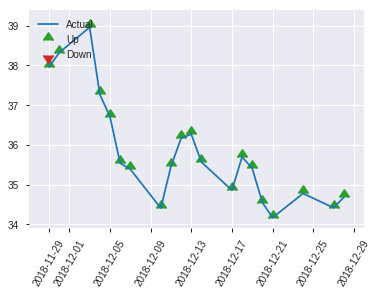


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24866535885812685
RMSE: 0.4986635728205208
LogLoss: 0.69047717708381
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.8121992937332
Residual deviance: 346.6195428960726
AIC: 448.6195428960726
AUC: 0.5908282520325203
pr_auc: 0.5419691845320839
Gini: 0.18165650406504064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5020513657872488: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   84   0.6562   (84.0/128.0)
1      18   105  0.1463   (18.0/123.0)
Total  62   189  0.4064   (102.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502051     0.673077  188
max f2                       0.491233     0.829932  242
max f0point5                 0.504748     0.601458  174
max accuracy                 0.504748     0.601594  174
max precision                0.529193     0.6875    15
max recall                   0.486822     1         249
max specificity              0.537071     0.992188  0
max absolute_mcc             0.504748     0.229709  174
max min_per_class_accuracy   0.511169     0.569106  123
max mean_per_class_accuracy  0.504748     0.605564  174

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 51.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.533467           0         0                  0                0.535836  0                           0.535836            0               0                          -100      -100
    2        0.0239044                   0.533185           2.04065   1.02033            1                0.533261  0.5                         0.534549            0.0243902       0.0243902                  104.065   2.03252
    3        0.0318725                   0.531813           1.02033   1.02033            0.5              0.532183  0.5                         0.533957            0.00813008      0.0325203                  2.03252   2.03252
    4        0.0438247                   0.530901           2.04065   1.2986             1                0.531233  0.636364                    0.533214            0.0243902       0.0569106                  104.065   29.8596
    5        0.0517928                   0.530185           1.02033   1.25578            0.5              0.530389  0.615385                    0.53278             0.00813008      0.0650407                  2.03252   25.5785
    6        0.103586                    0.526249           1.25578   1.25578            0.615385         0.528137  0.615385                    0.530458            0.0650407       0.130081                   25.5785   25.5785
    7        0.151394                    0.524381           1.02033   1.18143            0.5              0.525275  0.578947                    0.528821            0.0487805       0.178862                   2.03252   18.1429
    8        0.203187                    0.522708           0.627892  1.04033            0.307692         0.523448  0.509804                    0.527452            0.0325203       0.211382                   -37.2108  4.03316
    9        0.302789                    0.517425           0.979512  1.02033            0.48             0.519886  0.5                         0.524963            0.097561        0.308943                   -2.04878  2.03252
    10       0.40239                     0.514062           1.38764   1.11125            0.68             0.515733  0.544554                    0.522678            0.138211        0.447154                   38.7642   11.1245
    11       0.501992                    0.51088            1.22439   1.13369            0.6              0.512357  0.555556                    0.52063             0.121951        0.569106                   22.439    13.3695
    12       0.601594                    0.508287           1.14276   1.1352             0.56             0.509621  0.556291                    0.518808            0.113821        0.682927                   14.2764   13.5196
    13       0.701195                    0.50461            1.22439   1.14787            0.6              0.506642  0.5625                      0.51708             0.121951        0.804878                   22.439    14.7866
    14       0.800797                    0.500441           0.734634  1.09647            0.36             0.502503  0.537313                    0.515267            0.0731707       0.878049                   -26.5366  9.64689
    15       0.900398                    0.495634           0.653008  1.04741            0.32             0.497883  0.513274                    0.513344            0.0650407       0.943089                   -34.6992  4.74135
    16       1                           0.482675           0.571382  1                  0.28             0.49182   0.49004                     0.5112              

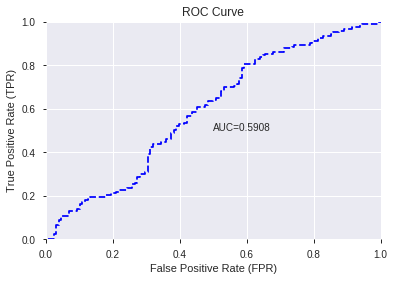

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


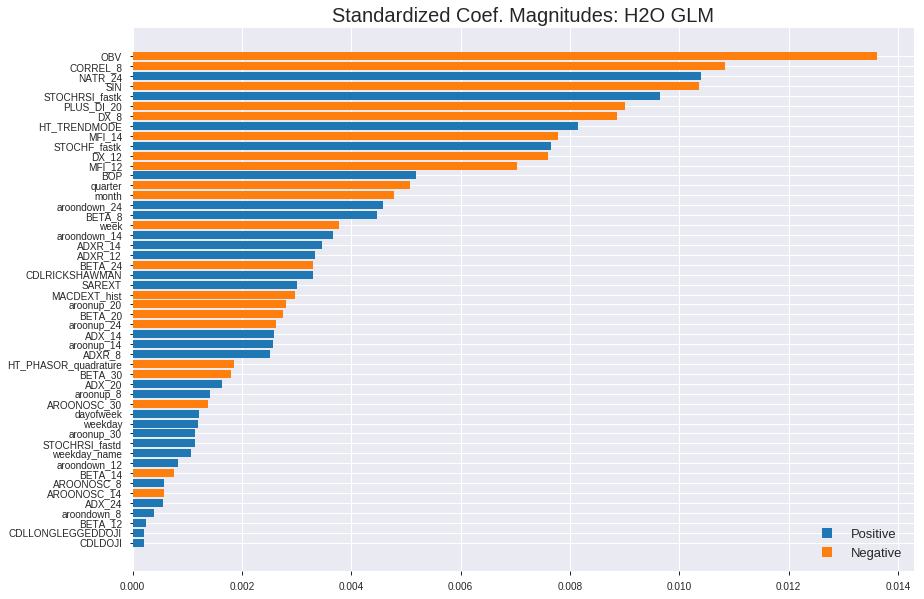

'log_likelihood'
--2019-08-25 17:05:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


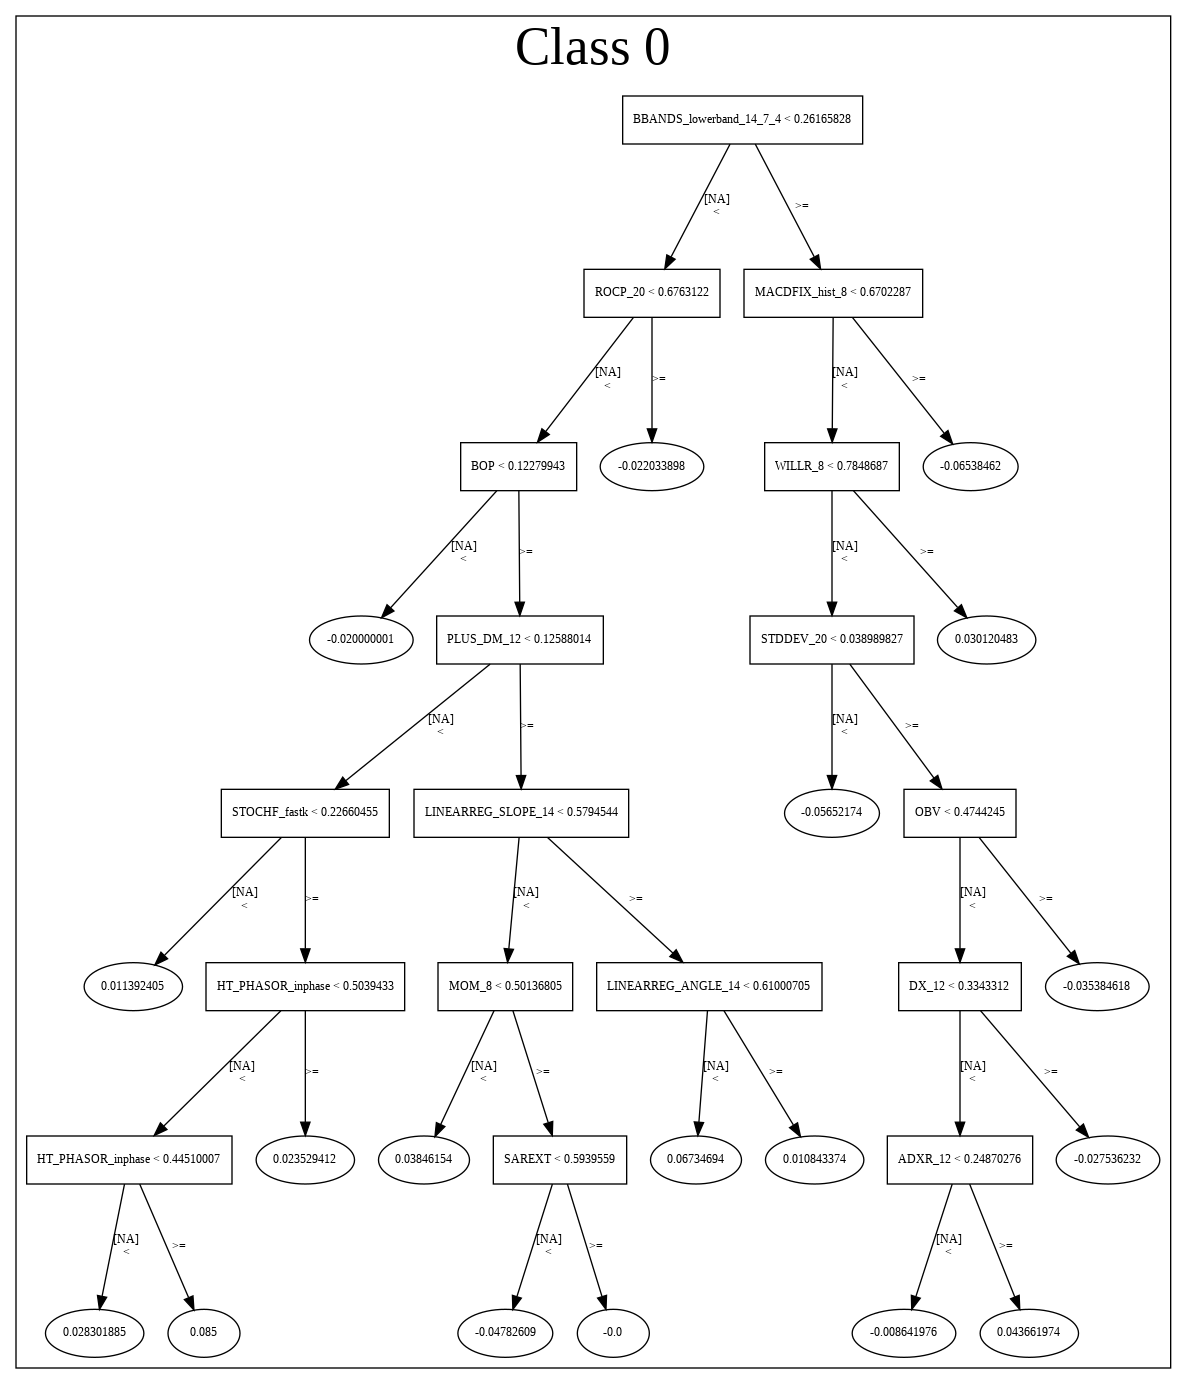

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_170536_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_170536_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['OBV',
 'CORREL_8',
 'NATR_24',
 'SIN',
 'STOCHRSI_fastk',
 'PLUS_DI_20',
 'DX_8',
 'HT_TRENDMODE',
 'MFI_14',
 'STOCHF_fastk',
 'DX_12',
 'MFI_12',
 'BOP',
 'quarter',
 'month',
 'aroondown_24',
 'BETA_8',
 'week',
 'aroondown_14',
 'ADXR_14',
 'ADXR_12',
 'BETA_24',
 'CDLRICKSHAWMAN',
 'SAREXT',
 'MACDEXT_hist',
 'aroonup_20',
 'BETA_20',
 'aroonup_24',
 'ADX_14',
 'aroonup_14',
 'ADXR_8',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'ADX_20',
 'aroonup_8',
 'AROONOSC_30',
 'dayofweek',
 'weekday',
 'aroonup_30',
 'STOCHRSI_fastd',
 'weekday_name',
 'aroondown_12',
 'BETA_14',
 'AROONOSC_8',
 'AROONOSC_14',
 'ADX_24',
 'aroondown_8',
 'BETA_12',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI']

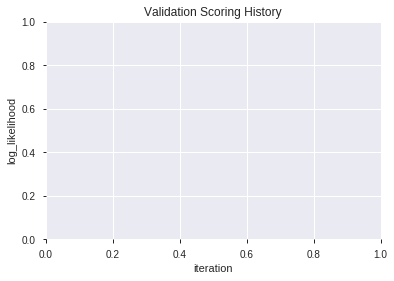

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_170643_model_4  0.578760  0.682383              0.437976  0.494661  0.244689
1  XGBoost_grid_1_AutoML_20190825_170643_model_1  0.574155  0.694902              0.428004  0.500675  0.250676
2  XGBoost_grid_1_AutoML_20190825_170643_model_6  0.569931  0.687054              0.442677  0.497027  0.247036
3  XGBoost_grid_1_AutoML_20190825_170643_model_2  0.569169  0.684043              0.427052  0.495515  0.245535
4               XGBoost_1_AutoML_20190825_170643  0.566819  0.690661              0.492188  0.498625  0.248627
5               XGBoost_3_AutoML_20190825_170643  0.563199  0.689100              0.439247  0.498045  0.248049
6  XGBoost_grid_1_AutoML_20190825_170643_model_7  0.559642  0.689484              0.476880  0.498188  0.248191
7  XGBoost_grid_1_AutoML_20190825_170643_model_3  0.556180  0.689816              0.476562  0.498477  0.248479
8  XGBoost_grid_1_AutoML_20190825_170643_model_5  0.547891  0.711137              0.496094  0.507676  0.257735
9               XGBoost_2_AutoML_20190825_170643  0.540333  0.695405              0.500000  0.500975  0.250976

variable  relative_importance  scaled_importance  percentage
0                    SIN           153.938202           1.000000    0.053869
1                 MFI_12           142.916962           0.928405    0.050013
2                 BETA_8           135.169052           0.878073    0.047301
3               CORREL_8           131.746674           0.855841    0.046104
4                NATR_24           126.625633           0.822574    0.044311
5                    OBV           126.291107           0.820401    0.044194
6                 SAREXT           118.871506           0.772203    0.041598
7         STOCHRSI_fastk           112.151093           0.728546    0.039246
8            AROONOSC_30           108.915756           0.707529    0.038114
9                 MFI_14            95.368530           0.619525    0.033373
10               BETA_20            94.342430           0.612859    0.033014
11                ADXR_8            92.447876           0.600552    0.032351
12                 DX_12            90.333420           0.586816    0.031611
13                   BOP            90.226700           0.586123    0.031574
14            PLUS_DI_20            90.111984           0.585378    0.031534
15               ADXR_12            85.783264           0.557258    0.030019
16                  DX_8            84.490990           0.548863    0.029567
17               BETA_14            83.857979           0.544751    0.029345
18               BETA_30            74.678345           0.485119    0.026133
19                ADX_14            71.087852           0.461795    0.024877
20  HT_PHASOR_quadrature            62.315464           0.404808    0.021807
21          MACDEXT_hist            60.429409           0.392556    0.021147
22          STOCHF_fastk            60.208843           0.391123    0.021070
23                  week            55.571671           0.361000    0.019447
24               BETA_24            54.822342           0.356132    0.019185
25        STOCHRSI_fastd            50.106205           0.325496    0.017534
26               ADXR_14            42.720299           0.277516    0.014950
27                ADX_20            40.226471           0.261316    0.014077
28            aroonup_30            35.512897           0.230696    0.012427
29             dayofweek            31.125927           0.202198    0.010892
30            aroonup_24            29.894083           0.194195    0.010461
31               BETA_12            29.813753           0.193674    0.010433
32             aroonup_8            26.569382           0.172598    0.009298
33           aroondown_8            24.758774           0.160836    0.008664
34                 month            23.833881           0.154828    0.008340
35          aroondown_12            22.668816           0.147259    0.007933
36                ADX_24            20.178308           0.131081    0.007061
37          weekday_name            14.912905           0.096876    0.005219
38          aroondown_24            14.510159           0.094260    0.005078
39          HT_TRENDMODE            12.364254           0.080320    0.004327
40            AROONOSC_8            12.337429           0.080145    0.004317
41            aroonup_14            10.124099           0.065767    0.003543
42            aroonup_20             6.680351           0.043396    0.002338
43          aroondown_14             6.583546           0.042767    0.002304

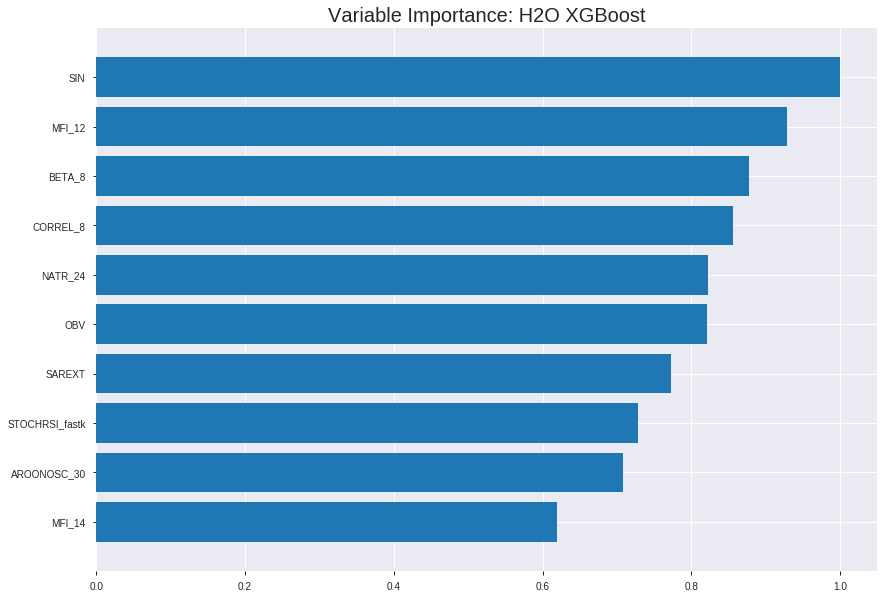

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_170643_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21723091750268647
RMSE: 0.46608037665480667
LogLoss: 0.626472845875051
Mean Per-Class Error: 0.2776267407291504
AUC: 0.7910642570281124
pr_auc: 0.788450160164176
Gini: 0.5821285140562249
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4781218667825063: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      429  411   0.4893   (411.0/840.0)
1      105  808   0.115    (105.0/913.0)
Total  534  1219  0.2944   (516.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478122     0.757974  259
max f2                       0.420979     0.85879   329
max f0point5                 0.530299     0.741897  182
max accuracy                 0.499708     0.72162   227
max precision                0.742582     1         0
max recall                   0.362929     1         380
max specificity              0.742582     1         0
max absolute_mcc             0.530299     0.445531  182
max min_per_class_accuracy   0.52031      0.711939  197
max mean_per_class_accuracy  0.530299     0.722373  182

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.686327           1.81337   1.81337            0.944444         0.703153  0.944444                    0.703153            0.0186199       0.0186199                  81.3375   81.3375
    2        0.0205362                   0.670597           1.70671   1.76004            0.888889         0.677073  0.916667                    0.690113            0.0175246       0.0361446                  70.6706   76.004
    3        0.0302339                   0.656193           1.69416   1.73891            0.882353         0.661954  0.90566                     0.681081            0.0164294       0.0525739                  69.4156   73.8908
    4        0.040502                    0.647544           1.81337   1.75779            0.944444         0.651136  0.915493                    0.673489            0.0186199       0.0711939                  81.3375   75.7787
    5        0.0501997                   0.639491           1.8071    1.76731            0.941176         0.642529  0.920455                    0.667508            0.0175246       0.0887185                  80.71     76.7313
    6        0.100399                    0.617609           1.68004   1.72368            0.875            0.62728   0.897727                    0.647394            0.0843373       0.173056                   68.0038   72.3676
    7        0.150029                    0.601163           1.589     1.67913            0.827586         0.609506  0.874525                    0.634861            0.0788609       0.251917                   58.9002   67.9126
    8        0.200228                    0.587599           1.54913   1.64653            0.806818         0.5944    0.85755                     0.624717            0.0777656       0.329682                   54.9126   64.6533
    9        0.300057                    0.565251           1.42632   1.57327            0.742857         0.575473  0.819392                    0.608333            0.142388        0.47207                    42.6318   57.3268
    10       0.399886                    0.544578           1.25077   1.49276            0.651429         0.555125  0.777461                    0.59505             0.124863        0.596933                   25.0771   49.2759
    11       0.500285                    0.522591           1.08002   1.40993            0.5625           0.533633  0.734322                    0.582725            0.108434        0.705367                   8.00246   40.993
    12       0.600114                    0.499633           1.03134   1.34695            0.537143         0.510377  0.701521                    0.57069             0.102957        0.808324                   3.13378   34.6951
    13       0.699943                    0.476199           0.778989  1.26595            0.405714         0.488488  0.659332                    0.558966            0.0777656       0.88609                    -22.1011  26.5946
    14       0.799772                    0.451617           0.482754  1.16819            0.251429         0.464945  0.608417                    0.54723             0.0481928       0.934283                   -51.7246  16.8186
    15       0.899601                    0.414106           0.449839  1.08847            0.234286         0.435357  0.566899                    0.534815            0.0449069       0.979189                   -55.0161  8.84713
    16       1                           0.304333           0.207277  1                  0.107955         0.385003  0.520821                    0.519774           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2533621515437728
RMSE: 0.5033509228597607
LogLoss: 0.7000599449738673
Mean Per-Class Error: 0.45510410641989596
AUC: 0.5481331533963113
pr_auc: 0.5848429621969267
Gini: 0.0962663067926226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3115386366844177: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    225  0.9868   (225.0/228.0)
1      0    273  0        (0.0/273.0)
Total  3    498  0.4491   (225.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311539     0.708171  396
max f2                       0.311539     0.858491  396
max f0point5                 0.382666     0.607059  365
max accuracy                 0.382666     0.560878  365
max precision                0.720021     1         0
max recall                   0.311539     1         396
max specificity              0.720021     1         0
max absolute_mcc             0.507689     0.10507   99
max min_per_class_accuracy   0.459281     0.531136  201
max mean_per_class_accuracy  0.507689     0.544896  99

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 46.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.650674           0.917582  0.917582           0.5              0.676397  0.5                         0.676397            0.010989        0.010989                   -8.24176  -8.24176
    2        0.0219561                   0.640687           1.1011    1.001              0.6              0.64529   0.545455                    0.662257            0.010989        0.021978                   10.1099   0.0999001
    3        0.0319361                   0.597945           1.83516   1.26168            1                0.60866   0.6875                      0.645508            0.018315        0.040293                   83.5165   26.1676
    4        0.0419162                   0.577226           1.1011    1.22344            0.6              0.586578  0.666667                    0.631477            0.010989        0.0512821                  10.1099   22.3443
    5        0.0518962                   0.560508           1.1011    1.19992            0.6              0.567025  0.653846                    0.619082            0.010989        0.0622711                  10.1099   19.9915
    6        0.101796                    0.542687           1.02769   1.11549            0.56             0.549492  0.607843                    0.584969            0.0512821       0.113553                   2.76923   11.5492
    7        0.151697                    0.525672           1.17451   1.1349             0.64             0.533478  0.618421                    0.568031            0.0586081       0.172161                   17.4505   13.4905
    8        0.201597                    0.513927           1.32132   1.18105            0.72             0.519316  0.643564                    0.555973            0.0659341       0.238095                   32.1319   18.1047
    9        0.301397                    0.491282           0.954286  1.10596            0.52             0.502631  0.602649                    0.53831             0.0952381       0.333333                   -4.57143  10.596
    10       0.401198                    0.476207           1.02769   1.08649            0.56             0.483003  0.59204                     0.524552            0.102564        0.435897                   2.76923   8.64906
    11       0.500998                    0.45548            0.954286  1.06015            0.52             0.467872  0.577689                    0.513261            0.0952381       0.531136                   -4.57143  6.0155
    12       0.600798                    0.439638           0.844176  1.02428            0.46             0.447457  0.55814                     0.50233             0.0842491       0.615385                   -15.5824  2.4278
    13       0.700599                    0.426621           1.1378    1.04045            0.62             0.432559  0.566952                    0.492391            0.113553        0.728938                   13.7802   4.04496
    14       0.800399                    0.406077           0.880879  1.02055            0.48             0.417766  0.55611                     0.483087            0.0879121       0.81685                    -11.9121  2.0553
    15       0.9002                      0.387734           0.954286  1.01321            0.52             0.398289  0.552106                    0.473685            0.0952381       0.912088                   -4.57143  1.32063
    16       1                           0.294396           0.880879  1                  0.48             0.358524  0.54491                     0.462192          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:06:48  1.867 sec   0                  0.5              0.693147            0.5             0                  1                0.479179                         0.5                0.693147              0.5               0                    1                  0.45509
    2019-08-25 17:06:48  1.924 sec   5                  0.494573         0.682338            0.667013        0.675766           1.60004          0.435254                         0.499172           0.691492              0.557202          0.574523             0.917582           0.443114
    2019-08-25 17:06:48  1.964 sec   10                 0.491037         0.675334            0.698864        0.71106            1.72804          0.389047                         0.499766           0.692678              0.549177          0.567864             0.917582           0.451098
    2019-08-25 17:06:48  2.009 sec   15                 0.487285         0.66792             0.714402        0.727586           1.81337          0.358243                         0.499967           0.693088              0.550471          0.571677             0.917582           0.44511
    2019-08-25 17:06:48  2.066 sec   20                 0.483092         0.659661            0.732827        0.74134            1.81337          0.335995                         0.500042           0.693241              0.558769          0.585222             0.917582           0.449102
    2019-08-25 17:06:48  2.117 sec   25                 0.480096         0.653779            0.744996        0.747864           1.81337          0.351968                         0.499671           0.692494              0.561516          0.589611             0.917582           0.447106
    2019-08-25 17:06:48  2.164 sec   30                 0.477124         0.647945            0.751367        0.754927           1.81337          0.341129                         0.500455           0.69408               0.560914          0.587951             0.917582           0.44511
    2019-08-25 17:06:48  2.213 sec   35                 0.474393         0.642617            0.761582        0.762046           1.81337          0.334855                         0.500734           0.694652              0.556849          0.589006             1.22344            0.449102
    2019-08-25 17:06:48  2.265 sec   40                 0.471607         0.637191            0.771434        0.770673           1.81337          0.302909                         0.501927           0.6971                0.548615          0.582665             0.917582           0.447106
    2019-08-25 17:06:48  2.327 sec   45                 0.468642         0.631448            0.783622        0.779444           1.81337          0.294353                         0.5028             0.698906              0.548061          0.587151             0.917582           0.44511
    2019-08-25 17:06:48  2.397 sec   50                 0.46608          0.626473            0.791064        0.78845            1.81337          0.294353                         0.503351           0.70006               0.548133          0.584843             0.917582           0.449102

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ---------------------
SIN           153.93820190429688     1.0                  0.05386928737163372
MFI_12        142.91696166992188     0.9284047747860087   0.050012503610144386
BETA_8        135.16905212402344     0.8780734765763849   0.04730119244310277
CORREL_8      131.74667358398438     0.85584131784189     0.04610356189534248
NATR_24       126.6256332397461      0.8225744595774156   0.044311499947542105
---           ---                    ---                  ---
HT_TRENDMODE  12.364253997802734     0.08031959477797182  0.004326759332667735
AROONOSC_8    12.33742904663086      0.08014533685602628  0.0043173721825936675
aroonup_14    10.124098777770996     0.06576729267024395  0.003542837188507711
aroonup_20    6.6803507804870605     0.04339631552043348  0.0023377285916403195
aroondown_14  6.583545684814453      0.04276745865141021  0.002303852520247279


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6818181818181819)

('auc', 0.578760162601626)

('logloss', 0.682382814180111)

('mean_per_class_error', 0.4159679878048781)

('rmse', 0.49466078964540844)

('mse', 0.244689296812619)

xgboost prediction progress: |████████████████████████████████████████████| 100%


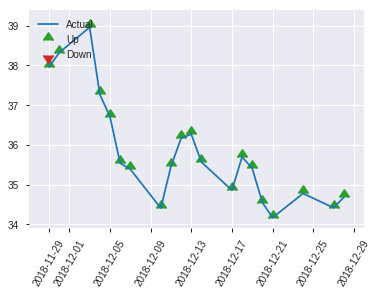


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.244689296812619
RMSE: 0.49466078964540844
LogLoss: 0.682382814180111
Mean Per-Class Error: 0.4159679878048781
AUC: 0.578760162601626
pr_auc: 0.5492473102472549
Gini: 0.157520325203252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4148142635822296: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   109  0.8516   (109.0/128.0)
1      3    120  0.0244   (3.0/123.0)
Total  22   229  0.4462   (112.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414814     0.681818  228
max f2                       0.404536     0.836763  236
max f0point5                 0.442474     0.588547  204
max accuracy                 0.442474     0.577689  204
max precision                0.599509     0.75      3
max recall                   0.369444     1         247
max specificity              0.679032     0.992188  0
max absolute_mcc             0.410185     0.220271  231
max min_per_class_accuracy   0.497886     0.546875  125
max mean_per_class_accuracy  0.442474     0.584032  204

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 49.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.599729           1.36043   1.36043            0.666667         0.640817  0.666667                    0.640817            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.59324            0.680217  1.02033            0.333333         0.595347  0.5                         0.618082            0.00813008      0.0243902                  -31.9783  2.03252
    3        0.0318725                   0.589806           2.04065   1.27541            1                0.589939  0.625                       0.611046            0.0162602       0.0406504                  104.065   27.5407
    4        0.0438247                   0.588338           1.36043   1.2986             0.666667         0.589191  0.636364                    0.605086            0.0162602       0.0569106                  36.0434   29.8596
    5        0.0517928                   0.583505           2.04065   1.41276            1                0.586147  0.692308                    0.602172            0.0162602       0.0731707                  104.065   41.2758
    6        0.103586                    0.566868           1.09881   1.25578            0.538462         0.57382   0.615385                    0.587996            0.0569106       0.130081                   9.88118   25.5785
    7        0.151394                    0.551637           1.02033   1.18143            0.5              0.558079  0.578947                    0.578549            0.0487805       0.178862                   2.03252   18.1429
    8        0.203187                    0.538196           1.09881   1.16037            0.538462         0.544707  0.568627                    0.569922            0.0569106       0.235772                   9.88118   16.037
    9        0.302789                    0.527791           1.06114   1.12773            0.52             0.532682  0.552632                    0.557672            0.105691        0.341463                   6.11382   12.7728
    10       0.40239                     0.512799           1.06114   1.11125            0.52             0.519119  0.544554                    0.548129            0.105691        0.447154                   6.11382   11.1245
    11       0.501992                    0.497886           1.06114   1.1013             0.52             0.506009  0.539683                    0.539772            0.105691        0.552846                   6.11382   10.1303
    12       0.601594                    0.477849           0.81626   1.05411            0.4              0.48766   0.516556                    0.531144            0.0813008       0.634146                   -18.374   5.41108
    13       0.701195                    0.464298           1.06114   1.05511            0.52             0.470251  0.517045                    0.522495            0.105691        0.739837                   6.11382   5.5109
    14       0.800797                    0.445075           1.30602   1.08632            0.64             0.452203  0.532338                    0.513752            0.130081        0.869919                   30.6016   8.63164
    15       0.900398                    0.417029           0.897886  1.06547            0.44             0.433076  0.522124                    0.504827            0.0894309       0.95935                    -10.2114  6.54723
    16       1                           0.313189           0.40813   1                  0.2              0.395178  0.49004                     0.493906           

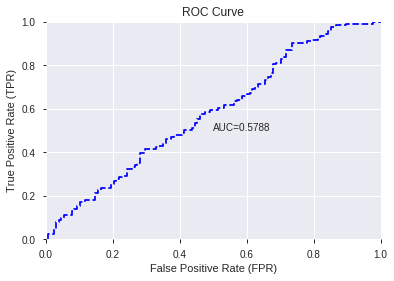

This function is available for GLM models only


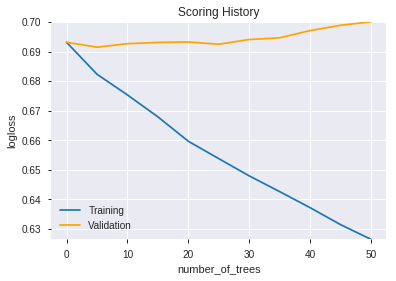

--2019-08-25 17:07:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.68
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

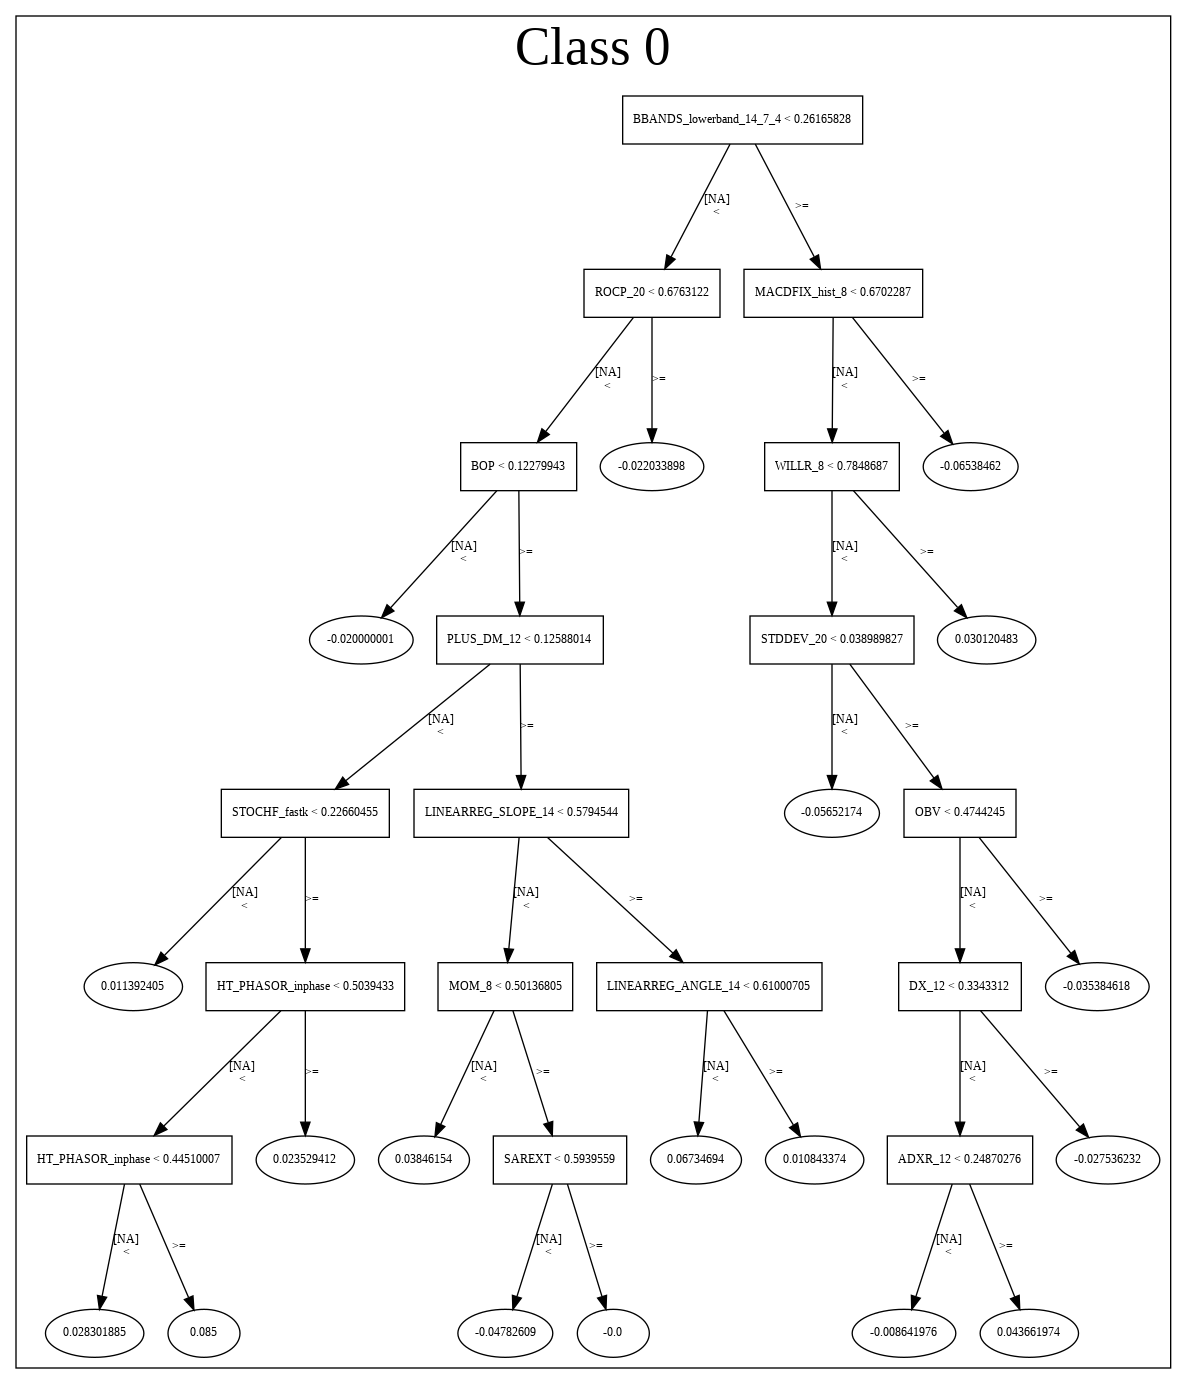

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_170643_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_170643_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'MFI_12',
 'BETA_8',
 'CORREL_8',
 'NATR_24',
 'OBV',
 'SAREXT',
 'STOCHRSI_fastk',
 'AROONOSC_30',
 'MFI_14',
 'BETA_20',
 'ADXR_8',
 'DX_12',
 'BOP',
 'PLUS_DI_20',
 'ADXR_12',
 'DX_8',
 'BETA_14',
 'BETA_30',
 'ADX_14',
 'HT_PHASOR_quadrature',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'week',
 'BETA_24',
 'STOCHRSI_fastd',
 'ADXR_14',
 'ADX_20',
 'aroonup_30',
 'dayofweek',
 'aroonup_24',
 'BETA_12',
 'aroonup_8',
 'aroondown_8',
 'month',
 'aroondown_12',
 'ADX_24',
 'weekday_name',
 'aroondown_24',
 'HT_TRENDMODE',
 'AROONOSC_8',
 'aroonup_14',
 'aroonup_20',
 'aroondown_14']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_170800_model_1  0.5  17.613400                   0.5  0.714115  0.509960
1  DeepLearning_grid_1_AutoML_20190825_170800_model_9  0.5   0.693425                   0.5  0.500139  0.250139
2  DeepLearning_grid_1_AutoML_20190825_170800_model_2  0.5  16.925376                   0.5  0.700028  0.490040
3  DeepLearning_grid_1_AutoML_20190825_170800_model_6  0.5  16.925376                   0.5  0.700028  0.490040
4               DeepLearning_1_AutoML_20190825_170800  0.5   0.696363                   0.5  0.501602  0.251605
5  DeepLearning_grid_1_AutoML_20190825_170800_model_5  0.5   0.693029                   0.5  0.499941  0.249941
6  DeepLearning_grid_1_AutoML_20190825_170800_model_3  0.5  16.925376                   0.5  0.700028  0.490040
7  DeepLearning_grid_1_AutoML_20190825_170800_model_8  0.5   0.696327                   0.5  0.501585  0.251587
8  DeepLearning_grid_1_AutoML_20190825_170800_model_7  0.5  16.925376                   0.5  0.700028  0.490040
9  DeepLearning_grid_1_AutoML_20190825_170800_model_4  0.5  16.925376                   0.5  0.700028  0.490040

variable  relative_importance  scaled_importance  percentage
0                         COSH             1.000000           1.000000    0.001360
1                         TANH             0.997465           0.997465    0.001356
2                         SINH             0.984094           0.984094    0.001338
3                CDLHANGINGMAN             0.953294           0.953294    0.001296
4                          EXP             0.950838           0.950838    0.001293
...                        ...                  ...                ...         ...
1037   BBANDS_lowerband_24_7_3             0.645391           0.645391    0.000877
1038               MIDPOINT_14             0.644454           0.644454    0.000876
1039  BBANDS_middleband_12_1_4             0.641628           0.641628    0.000872
1040  BBANDS_middleband_24_2_3             0.636699           0.636699    0.000866
1041                   KAMA_24             0.625957           0.625957    0.000851

[1042 rows x 4 columns]

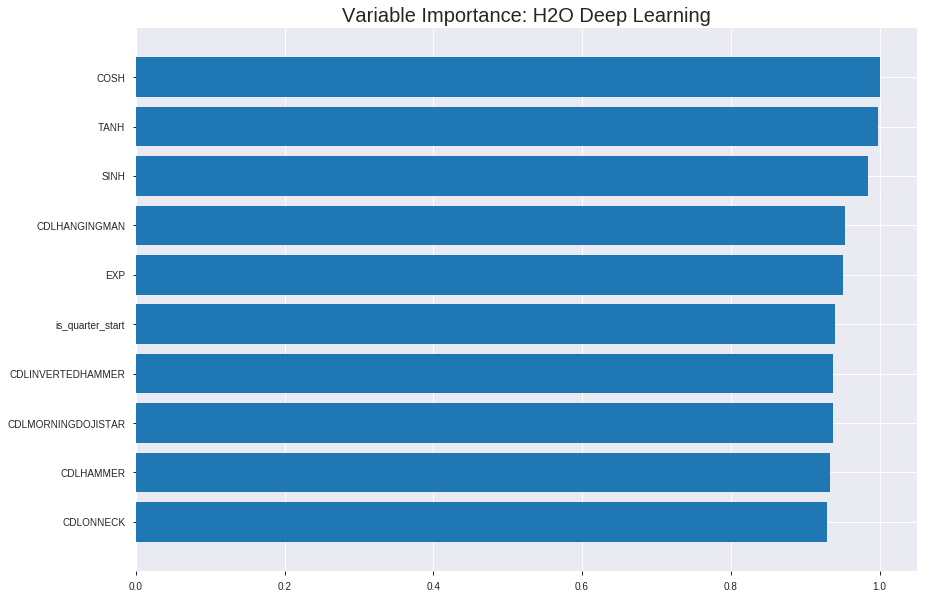

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_170800_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.29356551697617855
RMSE: 0.5418168666405454
LogLoss: 2.7249339870462572
Mean Per-Class Error: 0.3453873937307672
AUC: 0.6760450894487039
pr_auc: 0.4445735915110577
Gini: 0.3520901788974078
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4588606187598504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      324  516   0.6143   (516.0/840.0)
1      101  812   0.1106   (101.0/913.0)
Total  425  1328  0.352    (617.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458861     0.724676  244
max f2                       0.00275389   0.847931  396
max f0point5                 0.840911     0.667468  107
max accuracy                 0.840911     0.65773   107
max precision                0.9652       0.672302  35
max recall                   0.00012189   1         399
max specificity              0.999984     0.803571  0
max absolute_mcc             0.458861     0.320668  244
max min_per_class_accuracy   0.927239     0.641667  62
max mean_per_class_accuracy  0.840911     0.654613  107

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 72.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0399315                   1                  1.39889   1.39889            0.728571         1          0.728571                    1                   0.0558598       0.0558598                  39.8889   39.8889
    2        0.046777                    1                  1.44003   1.40491            0.75             1          0.731707                    1                   0.00985761      0.0657174                  44.0033   40.491
    3        0.0513406                   1                  1.68004   1.42937            0.875            1          0.744444                    1                   0.00766703      0.0733844                  68.0038   42.9366
    4        0.100399                    1                  1.04933   1.24366            0.546512         1          0.647727                    1                   0.0514786       0.124863                   4.93263   24.3665
    5        0.150029                    1                  1.28003   1.25569            0.666667         1          0.653992                    1                   0.0635268       0.18839                    28.0029   25.5694
    6        0.200228                    0.999996           1.17821   1.23627            0.613636         0.999999   0.643875                    1                   0.0591457       0.247536                   17.8209   23.6268
    7        0.300057                    0.996942           1.22883   1.23379            0.64             0.999315   0.642586                    0.999772            0.122673        0.370208                   22.8828   23.3792
    8        0.399886                    0.977732           1.3934    1.27364            0.725714         0.988769   0.663338                    0.997025            0.139102        0.50931                    39.3403   27.3638
    9        0.500285                    0.930978           1.2873    1.27638            0.670455         0.957823   0.664766                    0.989158            0.129244        0.638554                   28.7302   27.638
    10       0.600114                    0.809954           1.06425   1.24109            0.554286         0.879651   0.646388                    0.970942            0.106243        0.744797                   6.42529   24.1093
    11       0.699943                    0.615075           0.877734  1.18927            0.457143         0.722463   0.619397                    0.935503            0.0876232       0.832421                   -12.2266  18.9269
    12       0.799772                    0.323593           0.833848  1.1449             0.434286         0.473545   0.596291                    0.87784             0.0832421       0.915663                   -16.6152  14.4905
    13       0.899601                    0.0682302          0.449839  1.06777            0.234286         0.174192   0.556119                    0.799756            0.0449069       0.96057                    -55.0161  6.77733
    14       1                           3.41006e-08        0.392736  1                  0.204545         0.0197915  0.520821                    0.721448            0.0394304       1                          -60.7264  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.48436119451559045
RMSE: 0.6959606271302928
LogLoss: 14.005764934002197
Mean Per-Class Error: 0.4661895122421438
AUC: 0.5156721933037722
pr_auc: 0.37655726087481384
Gini: 0.03134438660754446
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.8339310901226457e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.83393e-48  0.705426   150
max f2                       4.83393e-48  0.856874   150
max f0point5                 4.83393e-48  0.599473   150
max accuracy                 4.83393e-48  0.54491    150
max precision                0.00320025   0.580786   69
max recall                   4.83393e-48  1          150
max specificity              1            0.684211   0
max absolute_mcc             0.000337149  0.0674608  76
max min_per_class_accuracy   2.18637e-05  0.520147   91
max mean_per_class_accuracy  0.000337149  0.53381    76

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 39.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.313373                    1                  1.00525   1.00525            0.547771         1            0.547771                    1                   0.315018        0.315018                   0.524953   0.524953
    2        0.401198                    0.387772           1.12612   1.03171            0.613636         0.854376     0.562189                    0.968122            0.0989011       0.413919                   12.6124    3.17096
    3        0.500998                    2.18637e-05        1.0644    1.03822            0.58             0.0478567    0.565737                    0.784802            0.106227        0.520147                   6.43956    3.82207
    4        0.600798                    7.92223e-41        0.917582  1.01818            0.5              1.83807e-06  0.554817                    0.654437            0.0915751       0.611722                   -8.24176   1.81812
    5        0.700599                    3.19043e-63        1.0644    1.02476            0.58             7.55338e-43  0.558405                    0.561212            0.106227        0.717949                   6.43956    2.47644
    6        0.800399                    1.96254e-73        0.880879  1.00682            0.48             4.00836e-65  0.548628                    0.491236            0.0879121       0.805861                   -11.9121   0.68236
    7        0.9002                      1.1029e-76         0.954286  1.001              0.52             2.70256e-74  0.545455                    0.436775            0.0952381       0.901099                   -4.57143   0.0999001
    8        1                           1.69686e-84        0.990989  1                  0.54             1.17397e-77  0.54491                     0.393185            0.0989011       1                          -0.901099  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:08:02  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:08:09  8.988 sec         215 obs/sec       0.903023  1             1583       0.631459         5.32745             -0.597734      0.559983        0.363284           1.11792          0.479179                         0.733568           16.0735               -1.16999         0.510925          0.567865             1.22344            0.45509
    2019-08-25 17:08:31  30.407 sec        231 obs/sec       3.60354   4             6317       0.593879         3.94858             -0.413222      0.61694         0.41524            1.24486          0.427268                         0.728023           15.5735               -1.13731         0.515375          0.571616             1.5293             0.45509
    2019-08-25 17:08:52  51.048 sec        238 obs/sec       6.30804   7             11058      0.592612         2.71282             -0.407197      0.617525        0.455419           1.60004          0.479179                         0.725593           15.4055               -1.12307         0.513447          0.568867             1.22344            0.45509
    2019-08-25 17:09:12  1 min 11.377 sec  241 obs/sec       9.00285   10            15782      0.588917         2.08943             -0.389703      0.665715        0.498189           1.60004          0.400456                         0.709958           14.9977               -1.03256         0.511969          0.567904             1.22344            0.45509
    2019-08-25 17:09:32  1 min 31.235 sec  244 obs/sec       11.6914   13            20495      0.569318         2.74572             -0.298744      0.628265        0.523983           1.81337          0.479179                         0.700682           14.0637               -0.979795        0.515102          0.3577               1.01836            0.45509
    2019-08-25 17:09:51  1 min 50.800 sec  247 obs/sec       14.3674   16            25186      0.541817         2.72493             -0.176302      0.676045        0.444574           1.39889          0.351968                         0.695961           14.0058               -0.953203        0.515672          0.376557             1.00525            0.45509
    2019-08-25 17:10:12  2 min 11.618 sec  246 obs/sec       17.0633   19            29912      0.548502         1.72428             -0.205508      0.670028        0.576232           1.70671          0.479179                         0.716983           15.0443               -1.07298         0.515953          0.570489             1.22344            0.45509
    2019-08-25 17:10:32  2 min 30.909 sec  248 obs/sec       19.7404   22            34605      0.584883         3.62951             -0.370729      0.631795        0.596387           1.81337          0.479179                         0.716316           14.4661               -1.06913         0.489621          0.334599             0.996514           0.45509
    2019-08-25 17:10:50  2 min 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
COSH                      1.0                    1.0                  0.0013596227544505795
TANH                      0.9974653124809265     0.9974653124809265   0.0013561765356242255
SINH                      0.9840940833091736     0.9840940833091736   0.0013379967081873366
CDLHANGINGMAN             0.9532938599586487     0.9532938599586487   0.001296120023677803
EXP                       0.9508383870124817     0.9508383870124817   0.0012927815067872565
---                       ---                    ---                  ---
BBANDS_lowerband_24_7_3   0.6453912258148193     0.6453912258148193   0.0008774885961405806
MIDPOINT_14               0.6444541811943054     0.6444541811943054   0.0008762145689525944
BBANDS_middleband_12_1_4  0.6416277885437012     0.6416277885437012   0.000872371741191821
BBANDS_middleband_24_2_3  0.6366992592811584     0.6366992592811584   0.0008656708006604924
KAMA_24                   0.6259568929672241     0.6259568929672241   0.0008510652349834239


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4900398406374502)

('F1', 0.6577540106951871)

('auc', 0.5)

('logloss', 17.613399914536114)

('mean_per_class_error', 0.5)

('rmse', 0.7141149482839229)

('mse', 0.5099601593625498)

deeplearning prediction progress: |███████████████████████████████████████| 100%


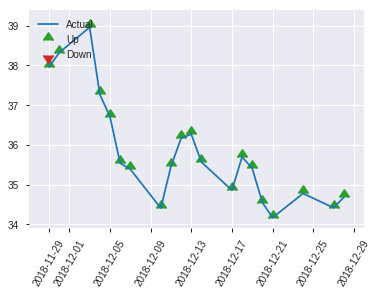


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5099601593625498
RMSE: 0.7141149482839229
LogLoss: 17.613399914536114
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    123  0        (0.0/123.0)
Total  0    251  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.657754  0
max f2                       1            0.827725  0
max f0point5                 1            0.545697  0
max accuracy                 1            0.49004   0
max precision                1            0.49004   0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.49004          1        0.49004                     1                   1               1                          0       0

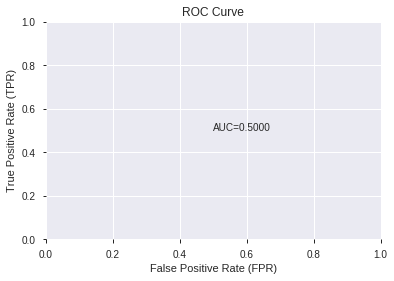

This function is available for GLM models only


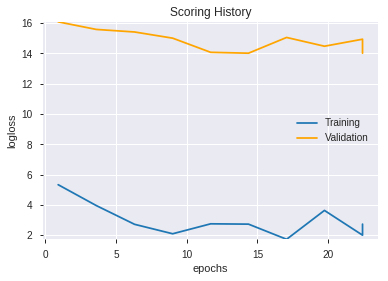

--2019-08-25 17:40:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.170
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.170|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


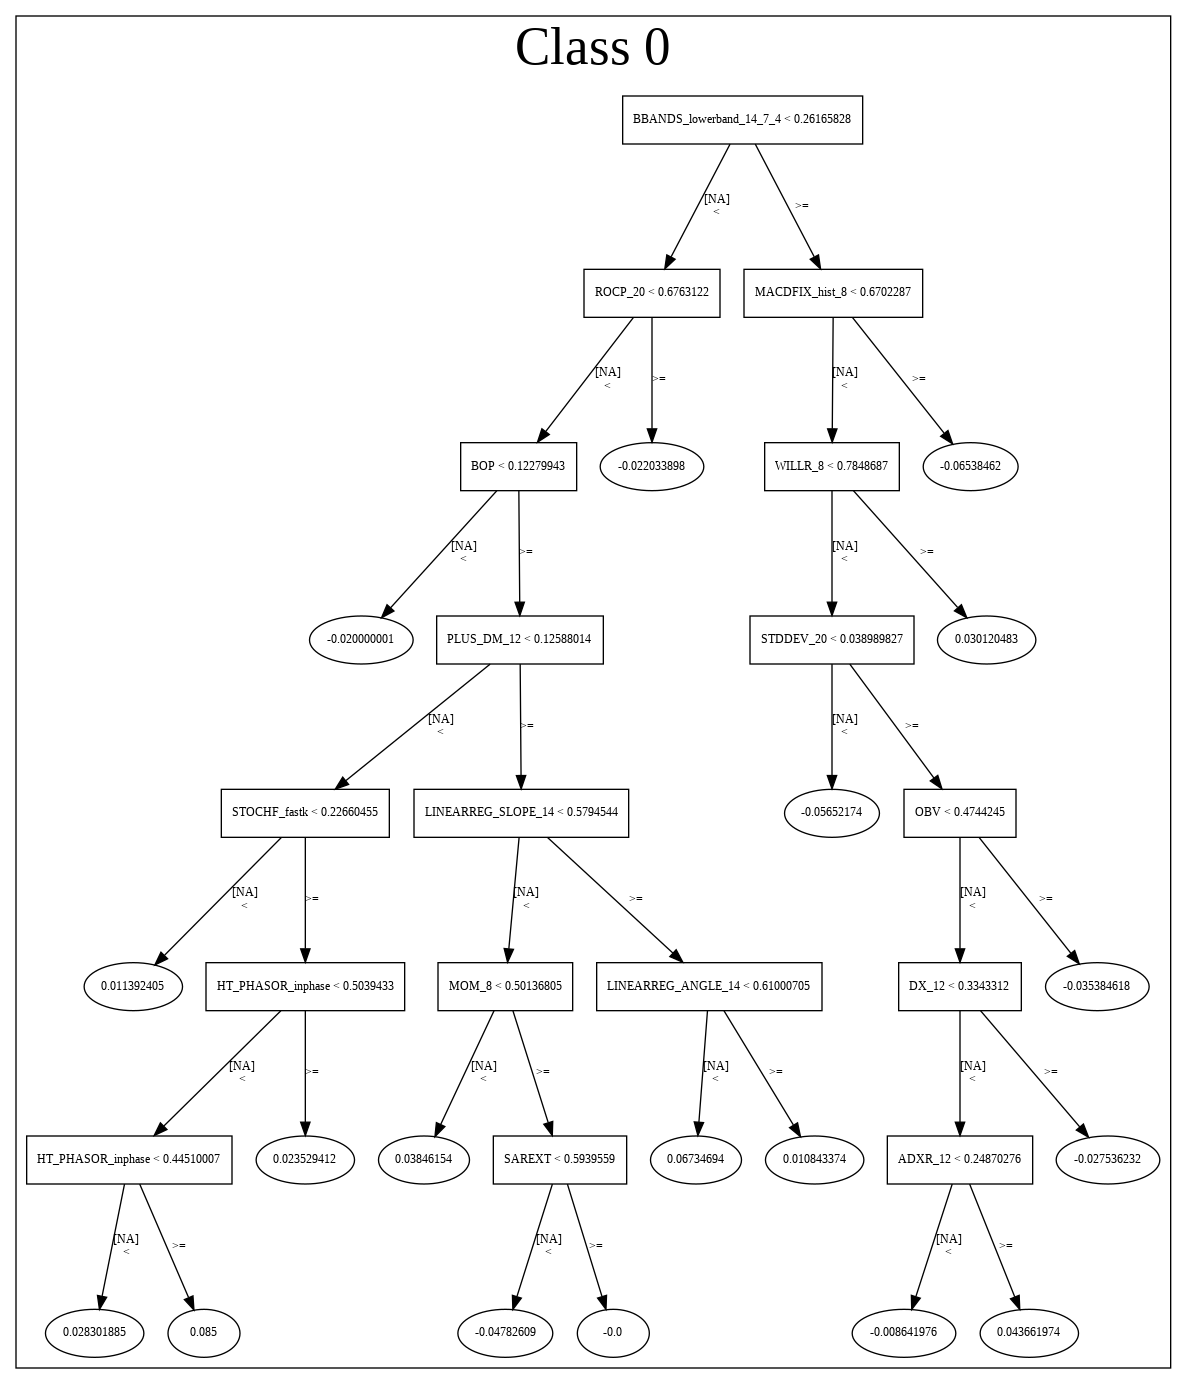

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_170800_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_170800_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['COSH',
 'TANH',
 'SINH',
 'CDLHANGINGMAN',
 'EXP',
 'is_quarter_start',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGDOJISTAR',
 'CDLHAMMER',
 'CDLONNECK',
 'CDL2CROWS',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'CDLEVENINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLCOUNTERATTACK',
 'CDLSHOOTINGSTAR',
 'CDL3LINESTRIKE',
 'CDLGRAVESTONEDOJI',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'HT_TRENDMODE',
 'CDLUNIQUE3RIVER',
 'CDLRISEFALL3METHODS',
 'CDLSTICKSANDWICH',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'CORREL_12',
 'CDLDARKCLOUDCOVER',
 'TAN',
 'CDLHIKKAKEMOD',
 'CDLLONGLEGGEDDOJI',
 'CDLXSIDEGAP3METHODS',
 'PLUS_DM_30',
 'CDL3INSIDE',
 'CDLDOJI',
 'COS',
 'CDL3OUTSIDE',
 'BBANDS_lowerband_24_3_2',
 'CDLTASUKIGAP',
 'STOCH_slowd',
 'weekday_name',
 'MFI_14',
 'OBV',
 'ADXR_14',
 'Volume',
 'MINUS_DI_30',
 'DIV',
 'SIN',
 'CDLRICKSHAWMAN',
 'BBAND

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190825_174115_model_1  0.5  16.925376                   0.5  0.700028  0.49004

variable  relative_importance  scaled_importance    percentage
0              CDLMATCHINGLOW         7.258906e-03           1.000000  1.032001e-02
1                    CORREL_8         5.583741e-03           0.769226  7.938422e-03
2                         SIN         4.855149e-03           0.668854  6.902580e-03
3         CDLXSIDEGAP3METHODS         4.834569e-03           0.666019  6.873322e-03
4                        DX_8         4.760662e-03           0.655837  6.768248e-03
...                       ...                  ...                ...           ...
1037                   TSF_30         4.414123e-06           0.000608  6.275573e-06
1038                   MAX_30         3.556631e-06           0.000490  5.056473e-06
1039  BBANDS_lowerband_30_2_3         1.862952e-06           0.000257  2.648565e-06
1040                   SUM_14         1.672139e-06           0.000230  2.377285e-06
1041  BBANDS_lowerband_20_6_2         6.735252e-07           0.000093  9.575528e-07

[1042 rows x 4 columns]

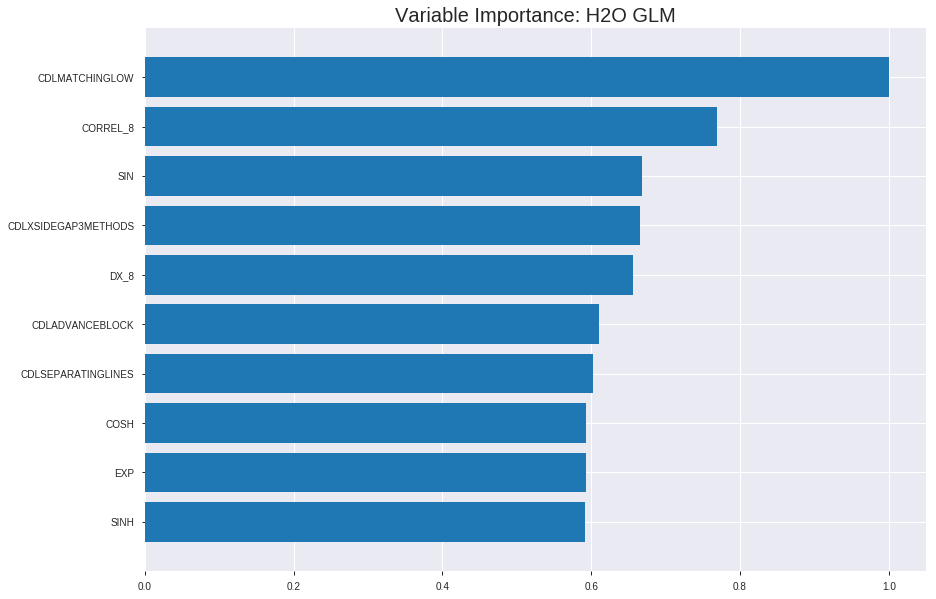

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_174115_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.245077249750039
RMSE: 0.49505277471198866
LogLoss: 0.6832194896122805
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2427.133204280672
Residual deviance: 2395.3675305806555
AIC: 4481.3675305806555
AUC: 0.5817412507171543
pr_auc: 0.5924314945674023
Gini: 0.16348250143430865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4522441984520651: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      48   792   0.9429   (792.0/840.0)
1      17   896   0.0186   (17.0/913.0)
Total  65   1688  0.4615   (809.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452244     0.688966  359
max f2                       0.406448     0.845684  393
max f0point5                 0.484581     0.591167  293
max accuracy                 0.503397     0.565317  242
max precision                0.652301     1         0
max recall                   0.406448     1         393
max specificity              0.652301     1         0
max absolute_mcc             0.517752     0.124614  205
max min_per_class_accuracy   0.513855     0.555312  214
max mean_per_class_accuracy  0.517752     0.562227  205

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.629695           1.3867    1.3867             0.722222         0.639746  0.722222                    0.639746            0.0142388       0.0142388                  38.6698    38.6698
    2        0.0205362                   0.619847           1.70671   1.5467             0.888889         0.623858  0.805556                    0.631802            0.0175246       0.0317634                  70.6706    54.6702
    3        0.0302339                   0.61226            0.90355   1.34041            0.470588         0.616432  0.698113                    0.626872            0.00876232      0.0405257                  -9.645     34.0408
    4        0.040502                    0.606377           1.49337   1.37919            0.777778         0.60981   0.71831                     0.622546            0.0153341       0.0558598                  49.3367    37.9186
    5        0.0501997                   0.60263            1.58121   1.41821            0.823529         0.604234  0.738636                    0.619009            0.0153341       0.0711939                  58.1213    41.8214
    6        0.100399                    0.584465           1.15639   1.2873             0.602273         0.592952  0.670455                    0.60598             0.0580504       0.129244                   15.639     28.7302
    7        0.150029                    0.57235            0.926918  1.16809            0.482759         0.57864   0.608365                    0.596936            0.0460022       0.175246                   -7.30823   16.8087
    8        0.200228                    0.562494           1.09093   1.14874            0.568182         0.567569  0.598291                    0.589574            0.0547645       0.230011                   9.0934     14.8744
    9        0.300057                    0.541217           1.10814   1.13524            0.577143         0.55105   0.591255                    0.576757            0.110624        0.340635                   10.814     13.5235
    10       0.399886                    0.525286           1.14105   1.13669            0.594286         0.532502  0.592011                    0.565709            0.11391         0.454545                   14.1055    13.6688
    11       0.500285                    0.513865           0.99275   1.1078             0.517045         0.519514  0.576967                    0.556438            0.0996714       0.554217                   -0.725007  10.7802
    12       0.600114                    0.504241           1.02037   1.09326            0.531429         0.509026  0.569392                    0.548551            0.101862        0.656079                   2.03661    9.32569
    13       0.699943                    0.494322           0.932593  1.07034            0.485714         0.499142  0.557457                    0.541504            0.0930997       0.749179                   -6.74073   7.03423
    14       0.799772                    0.484398           0.954536  1.05589            0.497143         0.489478  0.549929                    0.53501             0.0952903       0.844469                   -4.54639   5.58871
    15       0.899601                    0.470716           0.844819  1.03246            0.44             0.478328  0.53773                     0.52872             0.0843373       0.928806                   -15.5181   3.24649
    16       1                           0.395534           0.709107  1                  0.369318         0.450045  0.520821                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.45702298601194324
RMSE: 0.6760347520741394
LogLoss: 8.632825840732718
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 691.6529992083883
Residual deviance: 113250.52728860152
AIC: 115336.52728860152
AUC: 0.5187809266756636
pr_auc: 0.5672651167451096
Gini: 0.03756185335132711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.282110303405602e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    228  1        (228.0/228.0)
1      0    273  0        (0.0/273.0)
Total  0    501  0.4551   (228.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       9.28211e-50  0.705426  338
max f2                       9.28211e-50  0.856874  338
max f0point5                 9.28211e-50  0.599473  338
max accuracy                 9.28211e-50  0.54491   338
max precision                0.442993     0.711111  44
max recall                   9.28211e-50  1         338
max specificity              0.565825     0.995614  0
max absolute_mcc             0.442993     0.104845  44
max min_per_class_accuracy   5.60436e-05  0.517544  251
max mean_per_class_accuracy  0.000329183  0.53087   229

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 12.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.560188           0.917582  0.917582           0.5              0.563496      0.5                         0.563496            0.010989        0.010989                   -8.24176  -8.24176
    2        0.0219561                   0.55221            1.1011    1.001              0.6              0.556935      0.545455                    0.560514            0.010989        0.021978                   10.1099   0.0999001
    3        0.0319361                   0.519392           1.46813   1.14698            0.8              0.538557      0.625                       0.553652            0.014652        0.03663                    46.8132   14.6978
    4        0.0419162                   0.467326           0.734066  1.04867            0.4              0.4777        0.571429                    0.535569            0.00732601      0.043956                   -26.5934  4.86656
    5        0.0518962                   0.460649           1.46813   1.12933            0.8              0.463993      0.615385                    0.521804            0.014652        0.0586081                  46.8132   12.9332
    6        0.101796                    0.441522           1.32132   1.22344            0.72             0.448934      0.666667                    0.486083            0.0659341       0.124542                   32.1319   22.3443
    7        0.151697                    0.429662           0.880879  1.11076            0.48             0.436331      0.605263                    0.469718            0.043956        0.168498                   -11.9121  11.0758
    8        0.201597                    0.406136           0.954286  1.07203            0.52             0.419111      0.584158                    0.457191            0.047619        0.216117                   -4.57143  7.2027
    9        0.301397                    0.128844           0.954286  1.03304            0.52             0.273222      0.562914                    0.396274            0.0952381       0.311355                   -4.57143  3.30398
    10       0.401198                    0.00361057         1.02769   1.03171            0.56             0.0449363     0.562189                    0.308877            0.102564        0.413919                   2.76923   3.17096
    11       0.500998                    6.18468e-05        1.02769   1.03091            0.56             0.000787856   0.561753                    0.247504            0.102564        0.516484                   2.76923   3.09093
    12       0.600798                    5.80402e-08        0.954286  1.01818            0.52             9.86944e-06   0.554817                    0.206392            0.0952381       0.611722                   -4.57143  1.81812
    13       0.700599                    1.41321e-97        0.880879  0.998622           0.48             1.39222e-09   0.54416                     0.176992            0.0879121       0.699634                   -11.9121  -0.137754
    14       1                           0                  1.00322   1                  0.546667         1.17248e-105  0.54491                     0.124               0.300366        1                          0.322344  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:41:18  0.000 sec   2            4.3       1043          1.36644           226.049
    2019-08-25 17:41:20  2.064 sec   4            3.2       1043          1.36352           235.47
    2019-08-25 17:41:22  4.186 sec   6            2.3       1043          1.35997           243.556
    2019-08-25 17:41:24  6.279 sec   8            1.7       1043          1.35576           251.221
    2019-08-25 17:41:26  8.386 sec   10           1.2       1043          1.35084           258.796

Could not find exact threshold 0.0; using closest threshold found 0.0.


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.4900398406374502)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('F1', 0.6577540106951871)

('auc', 0.5)

('logloss', 16.925376480374545)

Could not find exact threshold 0.0; using closest threshold found 0.0.


('mean_per_class_error', 0.5)

('rmse', 0.7000284570197487)

('mse', 0.4900398406374502)

glm prediction progress: |████████████████████████████████████████████████| 100%


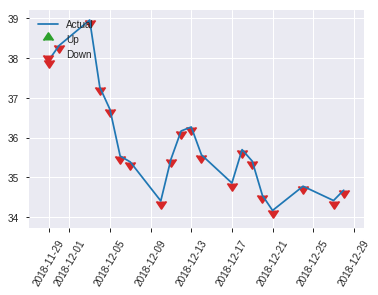


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4900398406374502
RMSE: 0.7000284570197487
LogLoss: 16.925376480374545
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 348.8121992937332
Residual deviance: 174265.51895893694
AIC: 176351.51895893694
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    123  0        (0.0/123.0)
Total  0    251  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0            0.657754  0
max f2                       0            0.827725  0
max f0point5                 0            0.545697  0
max accuracy                 0            0.49004   0
max precision                0            0.49004   0
max recall                   0            1         0
max specificity              0            0         0
max absolute_mcc             0            0         0
max min_per_class_accuracy   0            0         0
max mean_per_class_accuracy  0            0.5       0

Gains/Lift Table: Avg response rate: 49.00 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0                  1       1                  0.49004          0        0.49004                     0                   1               1                          0       0

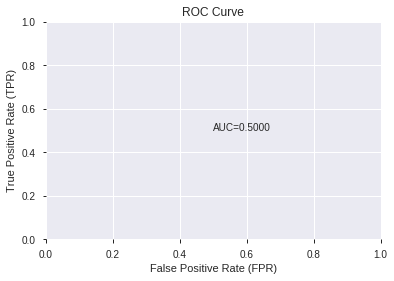

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


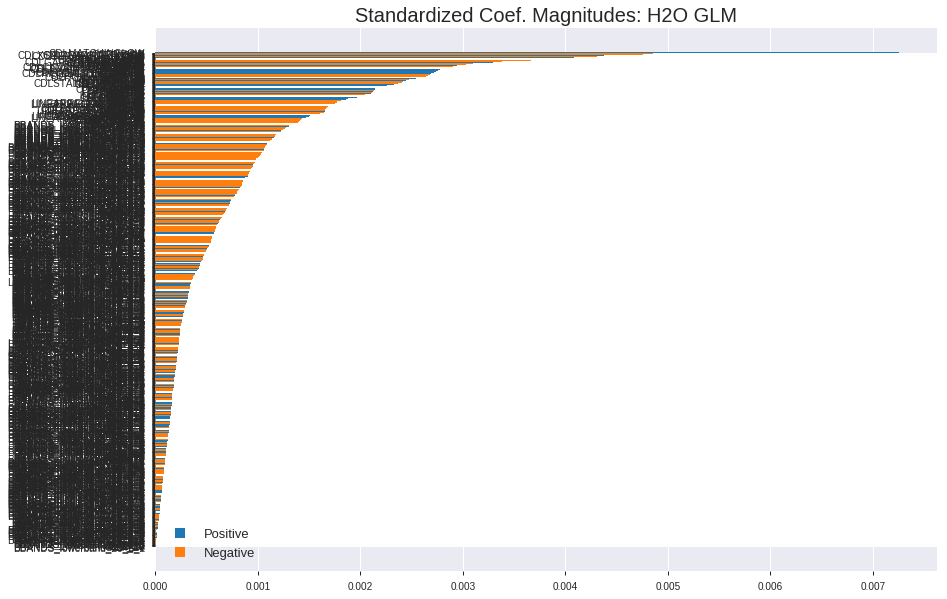

'log_likelihood'
--2019-08-25 17:41:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


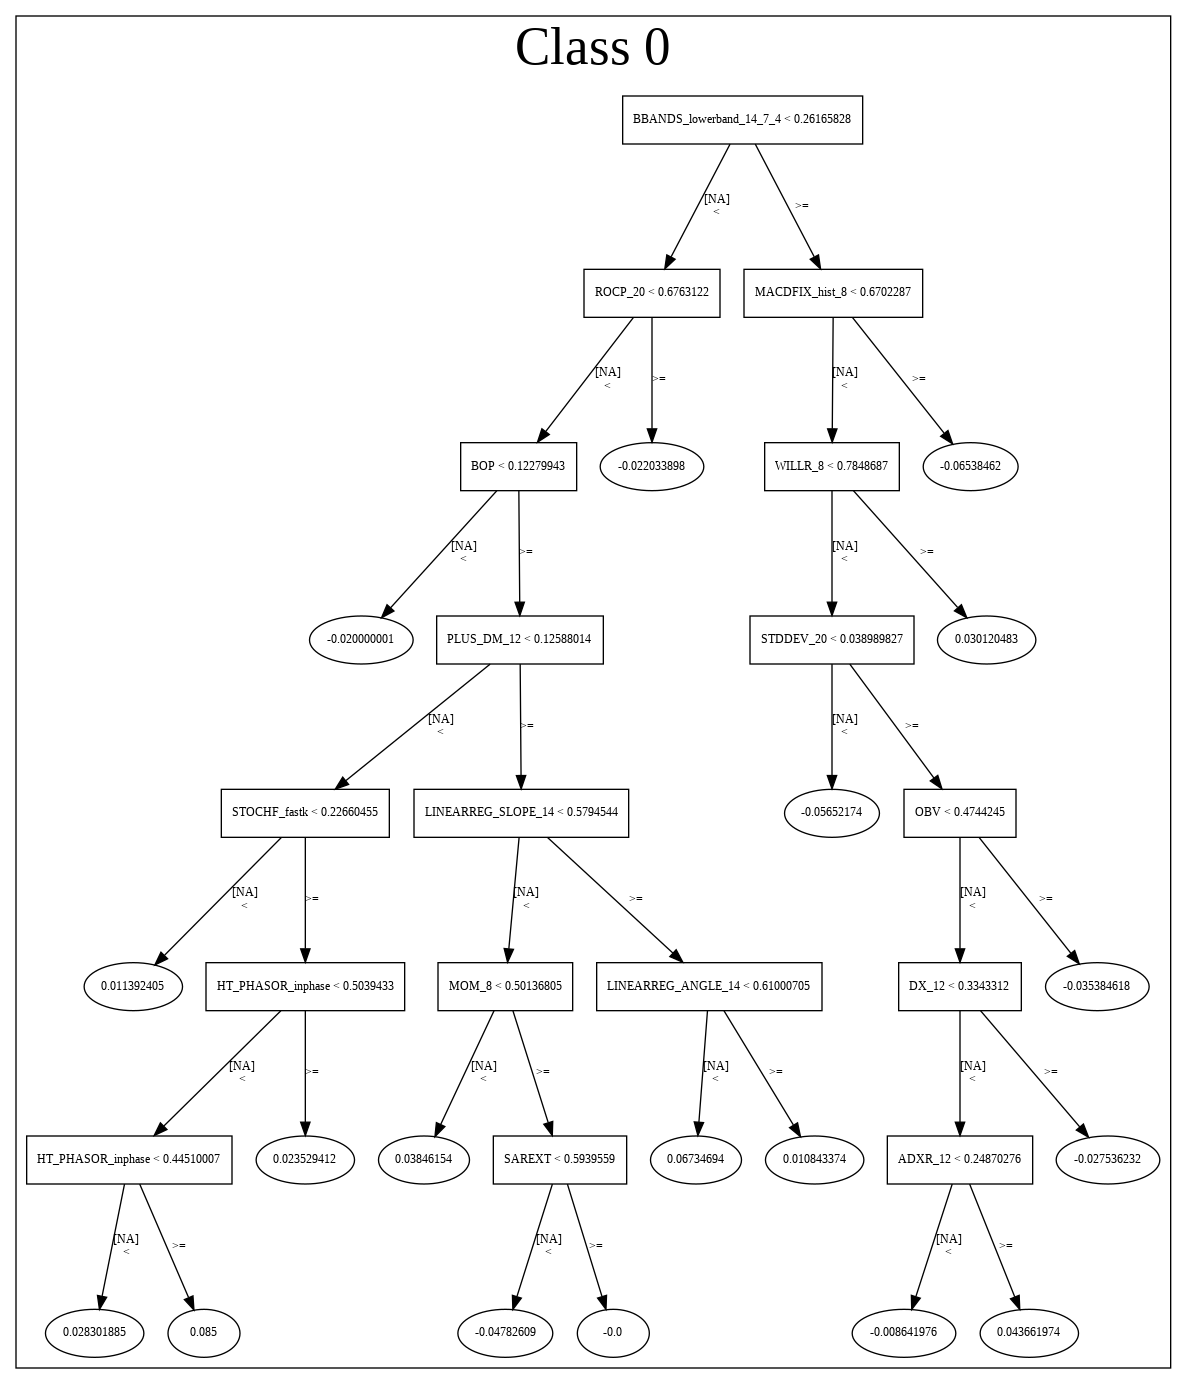

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_174115_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_174115_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLMATCHINGLOW',
 'CORREL_8',
 'SIN',
 'CDLXSIDEGAP3METHODS',
 'DX_8',
 'CDLADVANCEBLOCK',
 'CDLSEPARATINGLINES',
 'COSH',
 'EXP',
 'SINH',
 'STOCHRSI_fastk',
 'OBV',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'DX_12',
 'CDLHIKKAKEMOD',
 'HT_TRENDMODE',
 'DX_14',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_24',
 'CDLENGULFING',
 'ULTOSC',
 'CDL2CROWS',
 'days_in_month',
 'CDLTHRUSTING',
 'DX_20',
 'WILLR_14',
 'CDLONNECK',
 'quarter',
 'BETA_24',
 'CDLCLOSINGMARUBOZU',
 'CDLEVENINGDOJISTAR',
 'DX_24',
 'CDLINVERTEDHAMMER',
 'ADXR_14',
 'CCI_12',
 'BOP',
 'month',
 'WILLR_12',
 'CDLCOUNTERATTACK',
 'WILLR_8',
 'MFI_14',
 'CDLRISEFALL3METHODS',
 'CDL3LINESTRIKE',
 'CCI_14',
 'CDLHARAMI',
 'DX_30',
 'CDLUNIQUE3RIVER',
 'ROCR_20',
 'ROCP_20',
 'ROC_20',
 'CDLHOMINGPIGEON',
 'ROCR100_20',
 'aroondown_20',
 'dayofyear',
 'STDDEV_14',
 'MFI_12',
 'BETA_20',
 'is_quarter_start',
 'HT_DCPERIOD',
 'BETA_30',
 'PLUS_DM_24',
 'CDLSTALLEDPATTERN',
 'PLUS_DM_20',
 'day',
 'CDL3OUTSIDE',
 'PLUS_DM_30',
 'SAREXT',
 'VA

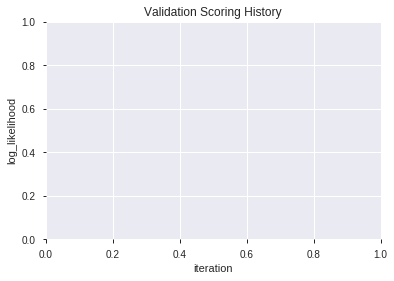

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190825_174247  0.568089  0.709199              0.477039  0.507398  0.257453
1               XGBoost_3_AutoML_20190825_174247  0.567518  0.696003              0.496094  0.500784  0.250785
2  XGBoost_grid_1_AutoML_20190825_174247_model_1  0.565422  0.714918              0.496094  0.508931  0.259011
3  XGBoost_grid_1_AutoML_20190825_174247_model_4  0.563199  0.693891              0.496094  0.500323  0.250323
4  XGBoost_grid_1_AutoML_20190825_174247_model_7  0.552782  0.717422              0.488440  0.509850  0.259947
5  XGBoost_grid_1_AutoML_20190825_174247_model_3  0.550559  0.759487              0.492188  0.527676  0.278442
6  XGBoost_grid_1_AutoML_20190825_174247_model_2  0.544398  0.692614              0.492188  0.499629  0.249629
7  XGBoost_grid_1_AutoML_20190825_174247_model_6  0.533727  0.701483              0.492346  0.503694  0.253708
8  XGBoost_grid_1_AutoML_20190825_174247_model_5  0.530615  0.724697              0.484534  0.513166  0.263339
9               XGBoost_1_AutoML_20190825_174247  0.527884  0.729294              0.492188  0.515428  0.265666

variable  relative_importance  scaled_importance  percentage
0                        BOP           140.418488           1.000000    0.021314
1                     Volume           130.534180           0.929608    0.019813
2                  CORREL_12           102.413773           0.729347    0.015545
3                     MFI_14           102.107124           0.727163    0.015498
4                   CORREL_8            96.976105           0.690622    0.014720
..                       ...                  ...                ...         ...
324              LINEARREG_8             2.338692           0.016655    0.000355
325  BBANDS_lowerband_14_5_5             1.849440           0.013171    0.000281
326  BBANDS_upperband_24_2_3             1.788834           0.012739    0.000272
327  BBANDS_upperband_30_6_4             1.606573           0.011441    0.000244
328  BBANDS_upperband_14_2_3             0.576220           0.004104    0.000087

[329 rows x 4 columns]

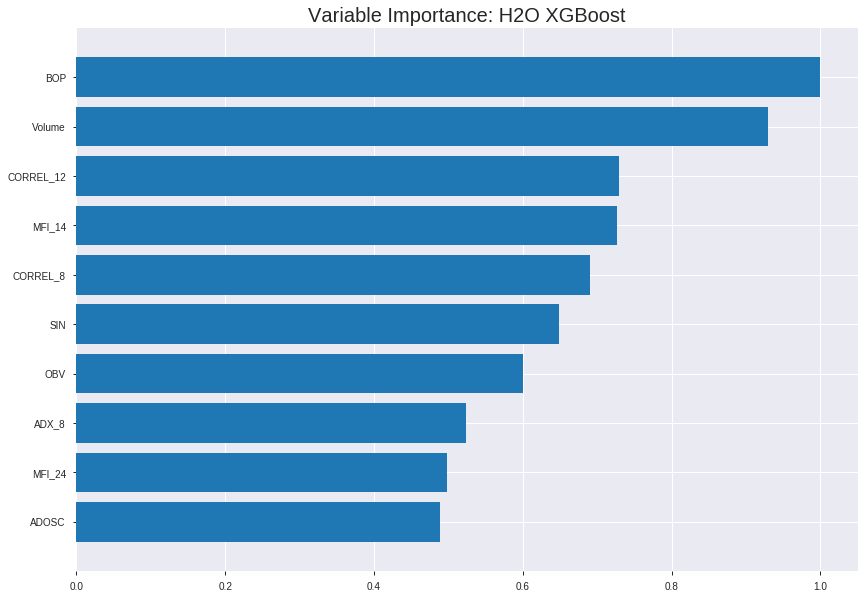

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190825_174247


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16877341973756896
RMSE: 0.4108204227367098
LogLoss: 0.5241960765426976
Mean Per-Class Error: 0.13633625410733852
AUC: 0.9370983935742971
pr_auc: 0.9436226080548461
Gini: 0.8741967871485943
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4937826267310551: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      695  145  0.1726   (145.0/840.0)
1      92   821  0.1008   (92.0/913.0)
Total  787  966  0.1352   (237.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493783     0.873869  220
max f2                       0.44608      0.908903  258
max f0point5                 0.553579     0.889712  174
max accuracy                 0.493783     0.864803  220
max precision                0.830968     1         0
max recall                   0.340194     1         337
max specificity              0.830968     1         0
max absolute_mcc             0.493783     0.729799  220
max min_per_class_accuracy   0.508112     0.859524  208
max mean_per_class_accuracy  0.503821     0.863664  212

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 51.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.774424           1.92004    1.92004            1                0.797924  1                           0.797924            0.0197152       0.0197152                  92.0044   92.0044
    2        0.0205362                   0.755525           1.92004    1.92004            1                0.764414  1                           0.781169            0.0197152       0.0394304                  92.0044   92.0044
    3        0.0302339                   0.744295           1.92004    1.92004            1                0.749038  1                           0.770863            0.0186199       0.0580504                  92.0044   92.0044
    4        0.040502                    0.735163           1.92004    1.92004            1                0.740258  1                           0.763104            0.0197152       0.0777656                  92.0044   92.0044
    5        0.0501997                   0.726599           1.92004    1.92004            1                0.730524  1                           0.75681             0.0186199       0.0963855                  92.0044   92.0044
    6        0.100399                    0.693818           1.92004    1.92004            1                0.708854  1                           0.732832            0.0963855       0.192771                   92.0044   92.0044
    7        0.150029                    0.667813           1.89797    1.91274            0.988506         0.681087  0.996198                    0.715715            0.094195        0.286966                   89.7974   91.2743
    8        0.200228                    0.645451           1.87641    1.90363            0.977273         0.655998  0.991453                    0.700743            0.094195        0.381161                   87.6406   90.3633
    9        0.300057                    0.601259           1.75547    1.85434            0.914286         0.623358  0.965779                    0.674997            0.175246        0.556407                   75.5469   85.4339
    10       0.399886                    0.564703           1.62381    1.79679            0.845714         0.583417  0.935806                    0.652135            0.162103        0.71851                    62.3808   79.6789
    11       0.500285                    0.515424           1.23276    1.6836             0.642045         0.541825  0.876853                    0.629997            0.123768        0.842278                   23.2755   68.3596
    12       0.600114                    0.476391           0.811904   1.53859            0.422857         0.494497  0.801331                    0.607457            0.0810515       0.92333                    -18.8096  53.859
    13       0.699943                    0.43422            0.449839   1.38331            0.234286         0.454618  0.720456                    0.585658            0.0449069       0.968237                   -55.0161  38.3308
    14       0.799772                    0.391722           0.208462   1.23666            0.108571         0.414016  0.64408                     0.564234            0.0208105       0.989047                   -79.1538  23.6662
    15       0.899601                    0.340182           0.0987451  1.11039            0.0514286        0.367466  0.578313                    0.542398            0.00985761      0.998905                   -90.1255  11.0387
    16       1                           0.175964           0.0109093  1                  0.00568182       0.297697  0.520821                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2722794752158412
RMSE: 0.5218040582592677
LogLoss: 0.7413054200314789
Mean Per-Class Error: 0.45409196067090807
AUC: 0.5405099286678234
pr_auc: 0.5936686097336267
Gini: 0.08101985733564687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24404273927211761: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    224  0.9825   (224.0/228.0)
1      2    271  0.0073   (2.0/273.0)
Total  6    495  0.4511   (226.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244043     0.705729  393
max f2                       0.212905     0.856874  399
max f0point5                 0.244043     0.60142   393
max accuracy                 0.244043     0.548902  393
max precision                0.702096     1         0
max recall                   0.212905     1         399
max specificity              0.702096     1         0
max absolute_mcc             0.603892     0.109573  10
max min_per_class_accuracy   0.38026      0.542125  202
max mean_per_class_accuracy  0.381782     0.545908  199

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 39.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.625734           1.5293    1.5293             0.833333         0.667969  0.833333                    0.667969            0.018315        0.018315                   52.9304    52.9304
    2        0.0219561                   0.603892           1.83516   1.66833            1                0.610154  0.909091                    0.64169             0.018315        0.03663                    83.5165    66.8332
    3        0.0319361                   0.590867           0.734066  1.37637            0.4              0.59833   0.75                        0.62814             0.00732601      0.043956                   -26.5934   37.6374
    4        0.0419162                   0.576474           1.1011    1.31083            0.6              0.582185  0.714286                    0.617198            0.010989        0.0549451                  10.1099    31.0832
    5        0.0518962                   0.564354           0.734066  1.19992            0.4              0.56624   0.653846                    0.607399            0.00732601      0.0622711                  -26.5934   19.9915
    6        0.101796                    0.511271           1.17451   1.18746            0.64             0.528799  0.647059                    0.568869            0.0586081       0.120879                   17.4505    18.746
    7        0.151697                    0.475167           0.954286  1.11076            0.52             0.489252  0.605263                    0.54268             0.047619        0.168498                   -4.57143   11.0758
    8        0.201597                    0.461077           1.46813   1.19922            0.8              0.467164  0.653465                    0.523988            0.0732601       0.241758                   46.8132    19.9217
    9        0.301397                    0.428828           0.770769  1.05735            0.42             0.443144  0.576159                    0.497218            0.0769231       0.318681                   -22.9231   5.73466
    10       0.401198                    0.404008           1.02769   1.04997            0.56             0.416764  0.572139                    0.477205            0.102564        0.421245                   2.76923    4.99699
    11       0.500998                    0.380221           1.21121   1.08209            0.66             0.390279  0.589641                    0.459889            0.120879        0.542125                   21.1209    8.20892
    12       0.600798                    0.365737           0.880879  1.04867            0.48             0.373084  0.571429                    0.44547             0.0879121       0.630037                   -11.9121   4.86656
    13       0.700599                    0.344285           0.917582  1.02999            0.5              0.354299  0.561254                    0.432482            0.0915751       0.721612                   -8.24176   2.99928
    14       0.800399                    0.320964           0.770769  0.997671           0.42             0.334573  0.543641                    0.420274            0.0769231       0.798535                   -22.9231   -0.232934
    15       0.9002                      0.282238           0.990989  0.99693            0.54             0.301231  0.543237                    0.407077            0.0989011       0.897436                   -0.901099  -0.30701
    16       1                           0.212905           1.02769   1                  0.56             0.260228  0.54491                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:42:52  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.479179                         0.5                0.693147              0.5               0                    1                  0.45509
    2019-08-25 17:42:52  0.747 sec   5                  0.488302         0.669971            0.760069        0.770355           1.81337          0.34227                          0.503191           0.699568              0.470857          0.533534             1.04867            0.45509
    2019-08-25 17:42:53  1.285 sec   10                 0.476759         0.647472            0.814972        0.825242           1.92004          0.262407                         0.503969           0.701182              0.503342          0.559314             0.917582           0.451098
    2019-08-25 17:42:53  1.910 sec   15                 0.466284         0.627307            0.847838        0.858784           1.92004          0.247576                         0.508601           0.710757              0.509455          0.566876             1.22344            0.449102
    2019-08-25 17:42:54  2.481 sec   20                 0.456563         0.608772            0.864216        0.873379           1.92004          0.207074                         0.510599           0.715031              0.524926          0.573992             0.917582           0.451098
    2019-08-25 17:42:55  3.089 sec   25                 0.447766         0.592205            0.883444        0.890848           1.92004          0.199658                         0.51142            0.716947              0.525304          0.572145             1.22344            0.453094
    2019-08-25 17:42:55  3.725 sec   30                 0.440083         0.577752            0.893988        0.904413           1.92004          0.184256                         0.516318           0.727786              0.527866          0.576136             1.22344            0.45509
    2019-08-25 17:42:56  4.408 sec   35                 0.432116         0.562919            0.904713        0.914572           1.92004          0.173417                         0.517421           0.730541              0.53896           0.589837             1.5293             0.451098
    2019-08-25 17:42:56  4.982 sec   40                 0.425183         0.550114            0.915217        0.92298            1.92004          0.162008                         0.518618           0.733505              0.542502          0.590551             1.5293             0.45509
    2019-08-25 17:42:57  5.617 sec   45                 0.41781          0.536835            0.928871        0.936702           1.92004          0.144894                         0.519832           0.736425              0.545498          0.590317             1.5293             0.453094
    2019-08-25 17:42:58  6.212 sec   50                 0.41082          0.524196            0.937098        0.943623           1.92004          0.135197                         0.521804           0.741305              0.54051           0.593669             1.5293             0.451098

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      140.41848754882812     1.0                   0.021313517310092782
Volume                   130.5341796875         0.9296082158847422    0.01981322080086392
CORREL_12                102.41377258300781     0.7293467859593288    0.015544945347604687
MFI_14                   102.10712432861328     0.7271629691432709    0.015498400530093569
CORREL_8                 96.97610473632812      0.6906220571746747    0.014719585170324316
---                      ---                    ---                   ---
LINEARREG_8              2.3386917114257812     0.01665515525947067   0.00035497993992501093
BBANDS_lowerband_14_5_5  1.8494396209716797     0.013170912557568809  0.0002807184727854612
BBANDS_upperband_24_2_3  1.7888336181640625     0.01273930270429687   0.00027151934870654315
BBANDS_upperband_30_6_4  1.6065731048583984     0.011441321815261257  0.00024385481055991297
BBANDS_upperband_14_2_3  0.5762195587158203     0.004103587560117038  8.74618844960359e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.6629834254143646)

('auc', 0.568089430894309)

('logloss', 0.709198935510086)

('mean_per_class_error', 0.4372459349593496)

('rmse', 0.5073979470237967)

('mse', 0.25745267664396365)

xgboost prediction progress: |████████████████████████████████████████████| 100%


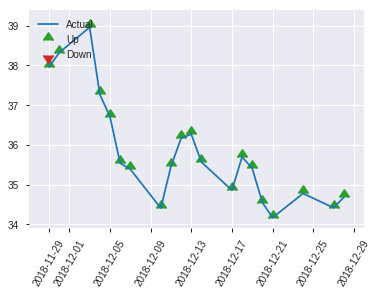


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25745267664396365
RMSE: 0.5073979470237967
LogLoss: 0.709198935510086
Mean Per-Class Error: 0.4372459349593496
AUC: 0.568089430894309
pr_auc: 0.5578477865654496
Gini: 0.13617886178861793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2757567763328552: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    119  0.9297   (119.0/128.0)
1      3    120  0.0244   (3.0/123.0)
Total  12   239  0.4861   (122.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275757     0.662983  238
max f2                       0.243456     0.828841  249
max f0point5                 0.32985      0.571429  187
max accuracy                 0.425428     0.561753  80
max precision                0.555998     1         0
max recall                   0.243456     1         249
max specificity              0.555998     1         0
max absolute_mcc             0.32985      0.144704  187
max min_per_class_accuracy   0.383352     0.539062  125
max mean_per_class_accuracy  0.32985      0.562754  187

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 38.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.514997           2.04065   2.04065            1                0.53157   1                           0.53157             0.0243902       0.0243902                  104.065   104.065
    2        0.0239044                   0.512162           1.36043   1.70054            0.666667         0.513002  0.833333                    0.522286            0.0162602       0.0406504                  36.0434   70.0542
    3        0.0318725                   0.504027           0         1.27541            0                0.507529  0.625                       0.518597            0               0.0406504                  -100      27.5407
    4        0.0438247                   0.494401           2.04065   1.48411            1                0.498986  0.727273                    0.513248            0.0243902       0.0650407                  104.065   48.4109
    5        0.0517928                   0.490431           0         1.25578            0                0.49192   0.615385                    0.509967            0               0.0650407                  -100      25.5785
    6        0.103586                    0.474503           1.25578   1.25578            0.615385         0.480021  0.615385                    0.494994            0.0650407       0.130081                   25.5785   25.5785
    7        0.151394                    0.456753           1.19038   1.23513            0.583333         0.468948  0.605263                    0.486769            0.0569106       0.186992                   19.0379   23.5131
    8        0.203187                    0.447776           1.25578   1.2404             0.615385         0.4511    0.607843                    0.477677            0.0650407       0.252033                   25.5785   24.0395
    9        0.302789                    0.427652           0.979512  1.15458            0.48             0.436844  0.565789                    0.464245            0.097561        0.349593                   -2.04878  15.4579
    10       0.40239                     0.404248           0.979512  1.11125            0.48             0.416778  0.544554                    0.452496            0.097561        0.447154                   -2.04878  11.1245
    11       0.501992                    0.383352           0.979512  1.08511            0.48             0.394767  0.531746                    0.441042            0.097561        0.544715                   -2.04878  8.51078
    12       0.601594                    0.357439           0.897886  1.05411            0.44             0.372277  0.516556                    0.429657            0.0894309       0.634146                   -10.2114  5.41108
    13       0.701195                    0.340118           1.06114   1.05511            0.52             0.347549  0.517045                    0.417994            0.105691        0.739837                   6.11382   5.5109
    14       0.800797                    0.318915           0.979512  1.04571            0.48             0.327662  0.512438                    0.406758            0.097561        0.837398                   -2.04878  4.57064
    15       0.900398                    0.299252           0.81626   1.02033            0.4              0.307512  0.5                         0.39578             0.0813008       0.918699                   -18.374   2.03252
    16       1                           0.237716           0.81626   1                  0.4              0.274816  0.49004                     0.383732          

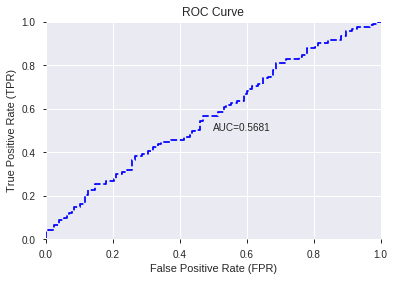

This function is available for GLM models only


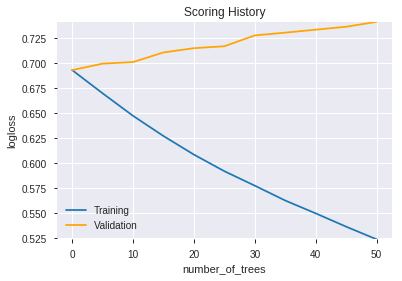

--2019-08-25 17:43:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


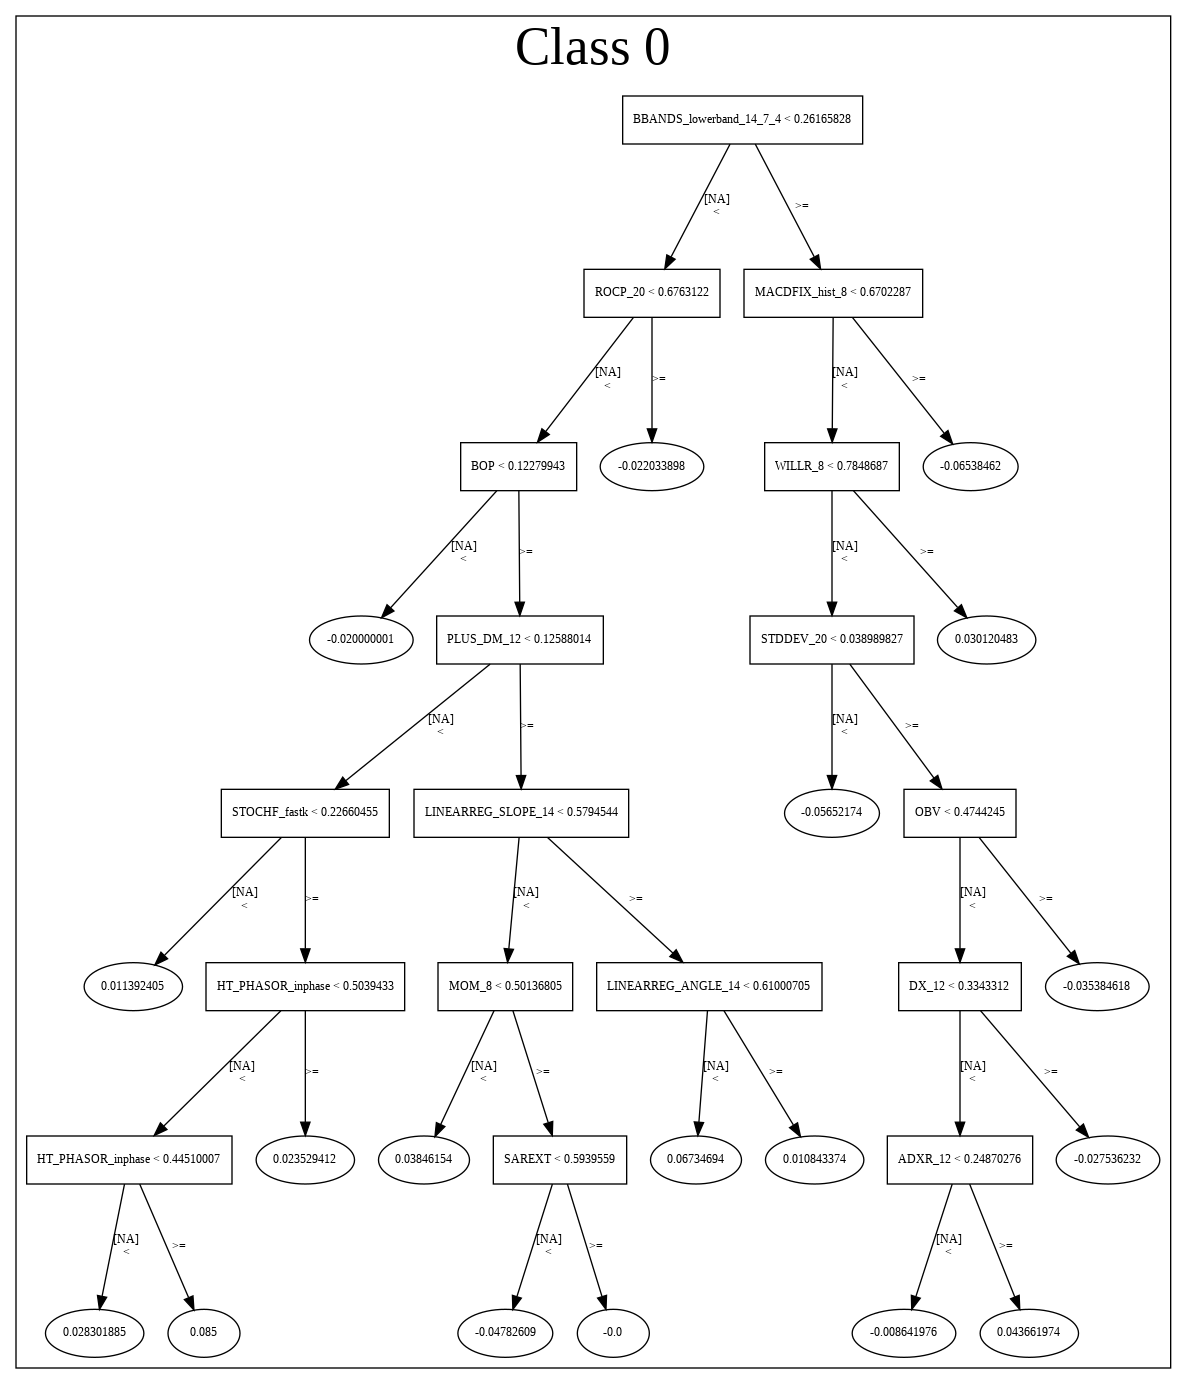

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190825_174247',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190825_174247',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_ada5',
   'type

['BOP',
 'Volume',
 'CORREL_12',
 'MFI_14',
 'CORREL_8',
 'SIN',
 'OBV',
 'ADX_8',
 'MFI_24',
 'ADOSC',
 'MACDEXT_hist',
 'DX_12',
 'ADXR_8',
 'PLUS_DM_12',
 'DX_14',
 'TAN',
 'MFI_12',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'CORREL_14',
 'LINEARREG_ANGLE_14',
 'HT_PHASOR_inphase',
 'ROC_20',
 'BBANDS_lowerband_14_7_4',
 'HT_PHASOR_quadrature',
 'TRIX_8',
 'CORREL_30',
 'STOCHRSI_fastd',
 'DX_20',
 'LINEARREG_ANGLE_8',
 'week',
 'MACDFIX_hist_8',
 'CCI_12',
 'AD',
 'BETA_8',
 'aroonup_30',
 'ADX_14',
 'MFI_8',
 'CORREL_24',
 'DIV',
 'MFI_20',
 'LINEARREG_SLOPE_14',
 'BETA_20',
 'ADXR_12',
 'BBANDS_lowerband_12_6_4',
 'STOCHRSI_fastk',
 'MACDFIX_hist_14',
 'MACDFIX_hist_24',
 'STDDEV_20',
 'dayofyear',
 'aroondown_14',
 'TRANGE',
 'BETA_12',
 'ADXR_14',
 'ROC_12',
 'ADX_24',
 'SAREXT',
 'WILLR_8',
 'MACDFIX_hist_12',
 'BETA_14',
 'MFI_30',
 'MINUS_DM_30',
 'COS',
 'day',
 'LINEARREG_INTERCEPT_30',
 'aroondown_30',
 'ULTOSC',
 'STOCH_slowd',
 'CCI_8',
 'MOM_8',
 'TRIX_14',
 'STDDEV_8',
 'PLUS

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

62

['BBANDS_upperband_14_0_2',
 'BBANDS_lowerband_14_3_5',
 'MA_14_4',
 'BBANDS_middleband_14_5_4',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_20_1_2',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_upperband_24_1_4',
 'ADXR_8',
 'aroondown_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DI_8',
 'ROCR_8',
 'ROCR100_8',
 'TRIX_8',
 'ADXR_12',
 'aroonup_12',
 'CCI_12',
 'MINUS_DI_12',
 'PLUS_DI_12',
 'TRIX_12',
 'ADXR_14',
 'aroonup_14',
 'CCI_14',
 'DX_14',
 'MFI_14',
 'MOM_14',
 'PLUS_DM_14',
 'MACDFIX_hist_20',
 'MINUS_DM_20',
 'MOM_20',
 'WILLR_20',
 'aroondown_24',
 'AROONOSC_24',
 'CCI_24',
 'DX_24',
 'MACDFIX_24',
 'MFI_24',
 'MINUS_DI_24',
 'MOM_24',
 'PLUS_DI_24',
 'ROCR100_24',
 'CMO_30',
 'MFI_30',
 'PLUS_DM_30',
 'ROC_30',
 'WILLR_30',
 'APO',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'ATR_20',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CDLBELTHOLD',
 'CORREL_8',
 'VAR_8',
 'CORREL_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_174549_model_8  0.546907  0.691720              0.492346  0.499272  0.249272
1  DeepLearning_grid_1_AutoML_20190825_174549_model_6  0.542556  0.833363              0.484375  0.547736  0.300015
2  DeepLearning_grid_1_AutoML_20190825_174549_model_4  0.517149  1.189017              0.500000  0.592769  0.351375
3  DeepLearning_grid_1_AutoML_20190825_174549_model_1  0.498476  3.587627              0.500000  0.689719  0.475712
4  DeepLearning_grid_1_AutoML_20190825_174549_model_2  0.497618  2.585924              0.496094  0.682975  0.466455
5  DeepLearning_grid_1_AutoML_20190825_174549_model_7  0.493521  0.829736              0.500000  0.550574  0.303132
6  DeepLearning_grid_1_AutoML_20190825_174549_model_3  0.484883  1.420192              0.492188  0.634146  0.402141
7  DeepLearning_grid_1_AutoML_20190825_174549_model_5  0.480818  0.767936              0.484375  0.530418  0.281343
8               DeepLearning_1_AutoML_20190825_174549  0.474911  1.099020              0.488440  0.603207  0.363859
9  DeepLearning_grid_1_AutoML_20190825_174549_model_9  0.471545  0.704165              0.492188  0.505436  0.255466

variable  relative_importance  scaled_importance  percentage
0       CORREL_8             1.000000           1.000000    0.019579
1   STOCHF_fastk             0.936894           0.936894    0.018343
2        ADXR_12             0.933403           0.933403    0.018275
3         ADXR_8             0.926921           0.926921    0.018148
4     PLUS_DM_30             0.925319           0.925319    0.018117
..           ...                  ...                ...         ...
57      WILLR_20             0.761171           0.761171    0.014903
58        TRIX_8             0.759668           0.759668    0.014874
59        CMO_30             0.753541           0.753541    0.014754
60    MACDFIX_24             0.749799           0.749799    0.014680
61         VAR_8             0.730495           0.730495    0.014302

[62 rows x 4 columns]

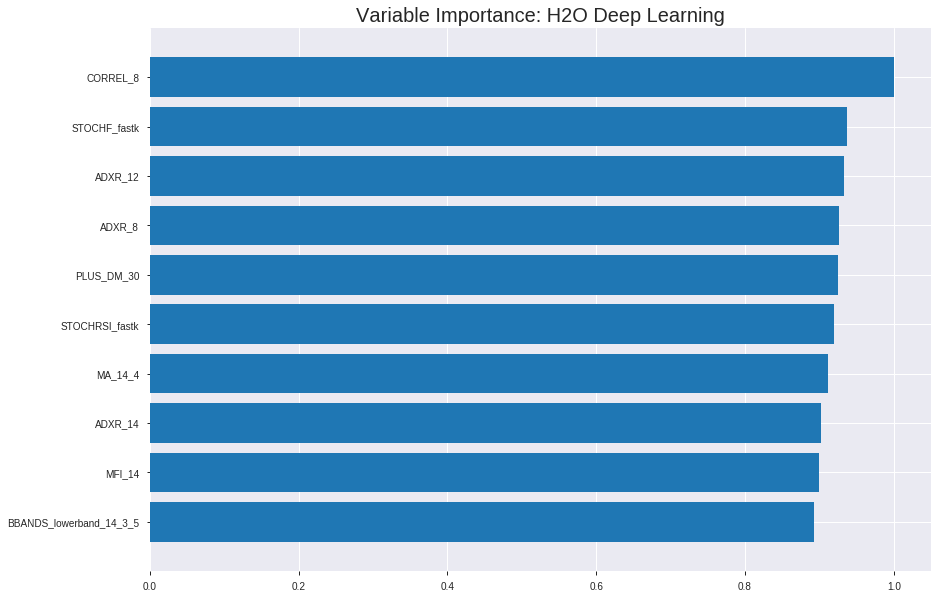

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_174549_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2470836645337277
RMSE: 0.49707510954958073
LogLoss: 0.6873244175353477
Mean Per-Class Error: 0.43972057059406455
AUC: 0.5842141292442498
pr_auc: 0.5933372764167633
Gini: 0.16842825848849952
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.502429749794358: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      71   769   0.9155   (769.0/840.0)
1      23   890   0.0252   (23.0/913.0)
Total  94   1659  0.4518   (792.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50243      0.692068  365
max f2                       0.480574     0.845997  392
max f0point5                 0.519076     0.595472  330
max accuracy                 0.531395     0.567598  297
max precision                0.739805     0.833333  4
max recall                   0.480574     1         392
max specificity              0.747205     0.99881   0
max absolute_mcc             0.50787      0.136541  355
max min_per_class_accuracy   0.546922     0.54874   256
max mean_per_class_accuracy  0.531395     0.560279  297

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 56.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.728243           1.60004   1.60004            0.833333         0.737111  0.833333                    0.737111            0.0164294       0.0164294                  60.0037   60.0037
    2        0.0205362                   0.715449           1.17336   1.3867             0.611111         0.721326  0.722222                    0.729219            0.0120482       0.0284775                  17.336    38.6698
    3        0.0302339                   0.70478            1.46827   1.41286            0.764706         0.708561  0.735849                    0.722593            0.0142388       0.0427163                  46.8269   41.2862
    4        0.040502                    0.697586           1.17336   1.35214            0.611111         0.700991  0.704225                    0.717116            0.0120482       0.0547645                  17.336    35.2144
    5        0.0501997                   0.693155           1.01649   1.2873             0.529412         0.695604  0.670455                    0.71296             0.00985761      0.0646221                  1.64938   28.7302
    6        0.100399                    0.665737           1.17821   1.23276            0.613636         0.676724  0.642045                    0.694842            0.0591457       0.123768                   17.8209   23.2755
    7        0.150029                    0.646468           1.19175   1.21919            0.62069          0.656008  0.634981                    0.681996            0.0591457       0.182913                   19.1751   21.9191
    8        0.200228                    0.625982           1.0473    1.1761             0.545455         0.636749  0.612536                    0.670652            0.0525739       0.235487                   4.72966   17.6095
    9        0.300057                    0.585033           1.14105   1.16444            0.594286         0.605023  0.606464                    0.648817            0.11391         0.349398                   14.1055   16.4437
    10       0.399886                    0.555909           1.02037   1.12847            0.531429         0.56811   0.587732                    0.628669            0.101862        0.45126                    2.03661   12.8471
    11       0.500285                    0.546741           0.970931  1.09686            0.505682         0.550864  0.571266                    0.613055            0.0974808       0.54874                    -2.90688  9.68551
    12       0.600114                    0.538827           1.06425   1.09143            0.554286         0.543523  0.568441                    0.601488            0.106243        0.654984                   6.42529   9.14317
    13       0.699943                    0.528986           0.976479  1.07504            0.508571         0.533871  0.559902                    0.591844            0.0974808       0.752464                   -2.35206  7.50368
    14       0.799772                    0.520172           0.932593  1.05726            0.485714         0.524727  0.550642                    0.583467            0.0930997       0.845564                   -6.74073  5.72566
    15       0.899601                    0.510453           0.899678  1.03977            0.468571         0.515542  0.541535                    0.575929            0.0898138       0.935378                   -10.0322  3.97701
    16       1                           0.470106           0.643651  1                  0.335227         0.49924   0.520821                    0.568229         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2485077902332907
RMSE: 0.49850555687303094
LogLoss: 0.6901802305921321
Mean Per-Class Error: 0.4541401580875265
AUC: 0.5492979242979243
pr_auc: 0.5748238522366438
Gini: 0.09859584859584869
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4532250389837934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    220  0.9649   (220.0/228.0)
1      4    269  0.0147   (4.0/273.0)
Total  12   489  0.4471   (224.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.453225     0.706037   388
max f2                       0.431268     0.856874   399
max f0point5                 0.472874     0.609572   338
max accuracy                 0.472874     0.566866   338
max precision                0.65398      1          0
max recall                   0.431268     1          399
max specificity              0.65398      1          0
max absolute_mcc             0.472874     0.0997294  338
max min_per_class_accuracy   0.499269     0.531136   194
max mean_per_class_accuracy  0.503246     0.54586    175

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 50.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.625625           0.611722  0.611722           0.333333         0.639644  0.333333                    0.639644            0.00732601      0.00732601                 -38.8278  -38.8278
    2        0.0219561                   0.59782            1.46813   1.001              0.8              0.610974  0.545455                    0.626612            0.014652        0.021978                   46.8132   0.0999001
    3        0.0319361                   0.554599           0.734066  0.917582           0.4              0.574146  0.5                         0.610216            0.00732601      0.029304                   -26.5934  -8.24176
    4        0.0419162                   0.545444           1.83516   1.13605            1                0.548257  0.619048                    0.595464            0.018315        0.047619                   83.5165   13.6054
    5        0.0518962                   0.545281           1.1011    1.12933            0.6              0.545329  0.615385                    0.585823            0.010989        0.0586081                  10.1099   12.9332
    6        0.101796                    0.539623           1.1011    1.11549            0.6              0.543697  0.607843                    0.565173            0.0549451       0.113553                   10.1099   11.5492
    7        0.151697                    0.53375            0.880879  1.03832            0.48             0.536478  0.565789                    0.555734            0.043956        0.157509                   -11.9121  3.83169
    8        0.201597                    0.530034           1.17451   1.07203            0.64             0.531763  0.584158                    0.5498              0.0586081       0.216117                   17.4505   7.2027
    9        0.301397                    0.518389           1.24791   1.13027            0.68             0.523451  0.615894                    0.541075            0.124542        0.340659                   24.7912   13.0267
    10       0.401198                    0.507261           0.954286  1.08649            0.52             0.513215  0.59204                     0.534145            0.0952381       0.435897                   -4.57143  8.64906
    11       0.500998                    0.499092           0.954286  1.06015            0.52             0.502938  0.577689                    0.527929            0.0952381       0.531136                   -4.57143  6.0155
    12       0.600798                    0.492038           0.954286  1.04257            0.52             0.495407  0.568106                    0.522526            0.0952381       0.626374                   -4.57143  4.25687
    13       0.700599                    0.485229           1.0644    1.04568            0.58             0.488882  0.569801                    0.517734            0.106227        0.732601                   6.43956   4.5678
    14       0.800399                    0.478254           0.917582  1.02971            0.5              0.481841  0.561097                    0.513258            0.0915751       0.824176                   -8.24176  2.9706
    15       0.9002                      0.468051           0.844176  1.00914            0.46             0.472791  0.549889                    0.508772            0.0842491       0.908425                   -15.5824  0.91372
    16       1                           0.431268           0.917582  1                  0.5              0.455472  0.54491                     0.503453         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:52:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:53:01  1 min 32.098 sec  567 obs/sec       0.627496  1             1100       0.598312         1.0254              -0.434398      0.524237        0.538946           1.06669          0.471763                         0.579939           0.94833               -0.356258        0.539096          0.574337             1.22344            0.45509
    2019-08-25 17:53:17  1 min 47.873 sec  868 obs/sec       8.02795   13            14073      0.497075         0.687324            0.00994846     0.584214        0.593337           1.60004          0.451797                         0.498506           0.69018               -0.00211593      0.549298          0.574824             0.611722           0.447106
    2019-08-25 17:53:32  2 min  3.148 sec  976 obs/sec       16.688    27            29254      0.496642         0.685475            0.0116714      0.606962        0.611773           1.28003          0.432972                         0.593015           0.983462              -0.418107        0.540622          0.571251             1.22344            0.45509
    2019-08-25 17:53:48  2 min 18.944 sec  1051 obs/sec      26.5328   43            46512      0.481909         0.655973            0.0694398      0.653935        0.663179           1.81337          0.399315                         0.552671           0.84155               -0.231719        0.541161          0.562387             0.917582           0.427146
    2019-08-25 17:54:04  2 min 34.395 sec  1097 obs/sec      36.4187   59            63842      0.470873         0.630546            0.111574       0.681996        0.68971            1.92004          0.385054                         0.55647            0.854657              -0.248711        0.524557          0.55405              1.22344            0.449102
    2019-08-25 17:54:19  2 min 49.720 sec  1140 obs/sec      46.8659   76            82156      0.46563          0.617485            0.13125        0.713848        0.730104           1.92004          0.345123                         0.53144            0.775827              -0.138903        0.522556          0.545313             0.917582           0.447106
    2019-08-25 17:54:34  3 min  4.517 sec  1176 obs/sec      57.2926   93            100434     0.451067         0.583102            0.184742       0.738811        0.757903           1.92004          0.333143                         0.607035           1.13427               -0.485952        0.51356           0.545607             1.22344            0.449102
    2019-08-25 17:54:35  3 min  5.998 sec  1175 obs/sec      57.2926   93            100434     0.497075         0.687324            0.00994846     0.584214        0.593337           1.60004          0.451797                         0.498506           0.69018               -0.00211593      0.549298          0.574824             0.611722           0.447106

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
CORREL_8      1.0                    1.0                  0.019578985210372962
STOCHF_fastk  0.9368937611579895     0.9368937611579895   0.018343429093402974
ADXR_12       0.9334031939506531     0.9334031939506531   0.018275087329674724
ADXR_8        0.9269213080406189     0.9269213080406189   0.018148178581306837
PLUS_DM_30    0.9253188371658325     0.9253188371658325   0.018116803827749342
---           ---                    ---                  ---
WILLR_20      0.7611709833145142     0.7611709833145142   0.014902955424879918
TRIX_8        0.7596684098243713     0.7596684098243713   0.014873536560738913
CMO_30        0.753540575504303      0.753540575504303    0.014753559783214678
MACDFIX_24    0.7497987747192383     0.7497987747192383   0.014680299120983734
VAR_8         0.730495035648346      0.730495035648346    0.014302351499209835


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5936254980079682)

('F1', 0.6594594594594595)

('auc', 0.5469067581300813)

('logloss', 0.6917203759607653)

('mean_per_class_error', 0.40621824186991873)

('rmse', 0.49927172549148596)

('mse', 0.2492722558752457)

deeplearning prediction progress: |███████████████████████████████████████| 100%


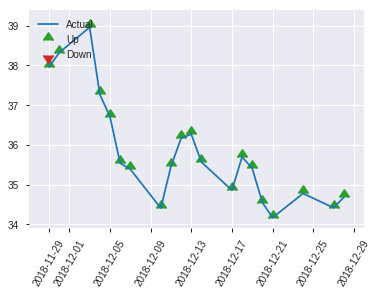


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2492722558752457
RMSE: 0.49927172549148596
LogLoss: 0.6917203759607653
Mean Per-Class Error: 0.40621824186991873
AUC: 0.5469067581300813
pr_auc: 0.5120533834768989
Gini: 0.09381351626016254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40011698462262674: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    125  0.9766   (125.0/128.0)
1      1    122  0.0081   (1.0/123.0)
Total  4    247  0.502    (126.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400117     0.659459  245
max f2                       0.395051     0.827725  249
max f0point5                 0.471269     0.586371  125
max accuracy                 0.471269     0.593625  125
max precision                0.544524     0.625     6
max recall                   0.395051     1         249
max specificity              0.545216     0.992188  0
max absolute_mcc             0.471269     0.18754   125
max min_per_class_accuracy   0.472012     0.585938  124
max mean_per_class_accuracy  0.471269     0.593782  125

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 47.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.54488            0.680217  0.680217           0.333333         0.545109  0.333333                    0.545109            0.00813008      0.00813008                 -31.9783  -31.9783
    2        0.0239044                   0.544765           1.36043   1.02033            0.666667         0.544804  0.5                         0.544957            0.0162602       0.0243902                  36.0434   2.03252
    3        0.0318725                   0.544495           2.04065   1.27541            1                0.544561  0.625                       0.544858            0.0162602       0.0406504                  104.065   27.5407
    4        0.0438247                   0.543702           0         0.927568           0                0.544139  0.454545                    0.544662            0               0.0406504                  -100      -7.24316
    5        0.0517928                   0.54289            1.02033   0.941839           0.5              0.543189  0.461538                    0.544435            0.00813008      0.0487805                  2.03252   -5.81614
    6        0.103586                    0.529974           1.25578   1.09881            0.615385         0.536496  0.538462                    0.540465            0.0650407       0.113821                   25.5785   9.88118
    7        0.151394                    0.523599           0.850271  1.02033            0.416667         0.526506  0.5                         0.536057            0.0406504       0.154472                   -14.9729  2.03252
    8        0.203187                    0.520082           0.941839  1.00032            0.461538         0.521611  0.490196                    0.532375            0.0487805       0.203252                   -5.81614  0.0318827
    9        0.302789                    0.49678            1.14276   1.04718            0.56             0.509506  0.513158                    0.524852            0.113821        0.317073                   14.2764   4.71759
    10       0.40239                     0.482387           1.38764   1.13145            0.68             0.488769  0.554455                    0.515921            0.138211        0.455285                   38.7642   13.145
    11       0.501992                    0.472012           1.38764   1.18228            0.68             0.475926  0.579365                    0.507985            0.138211        0.593496                   38.7642   18.2282
    12       0.601594                    0.462653           0.734634  1.10817            0.36             0.467346  0.543046                    0.501257            0.0731707       0.666667                   -26.5366  10.8168
    13       0.701195                    0.448208           0.653008  1.04351            0.32             0.456517  0.511364                    0.494902            0.0650407       0.731707                   -34.6992  4.35144
    14       0.800797                    0.432619           0.571382  0.984791           0.28             0.441392  0.482587                    0.488246            0.0569106       0.788618                   -42.8618  -1.52085
    15       0.900398                    0.418348           1.14276   1.00227            0.56             0.42354   0.49115                     0.481089            0.113821        0.902439                   14.2764   0.226635
    16       1                           0.395051           0.979512  1                  0.48             0.408288  0.49004                     0.473837   

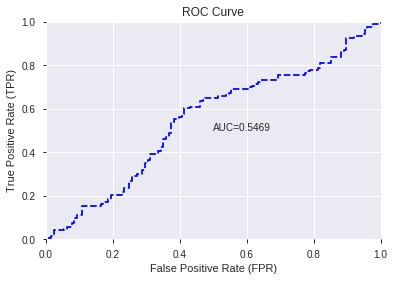

This function is available for GLM models only


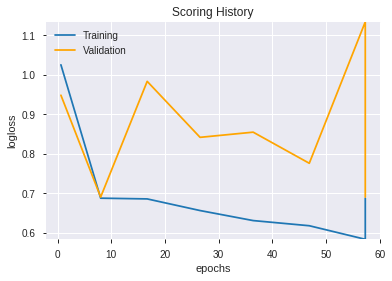

--2019-08-25 17:56:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


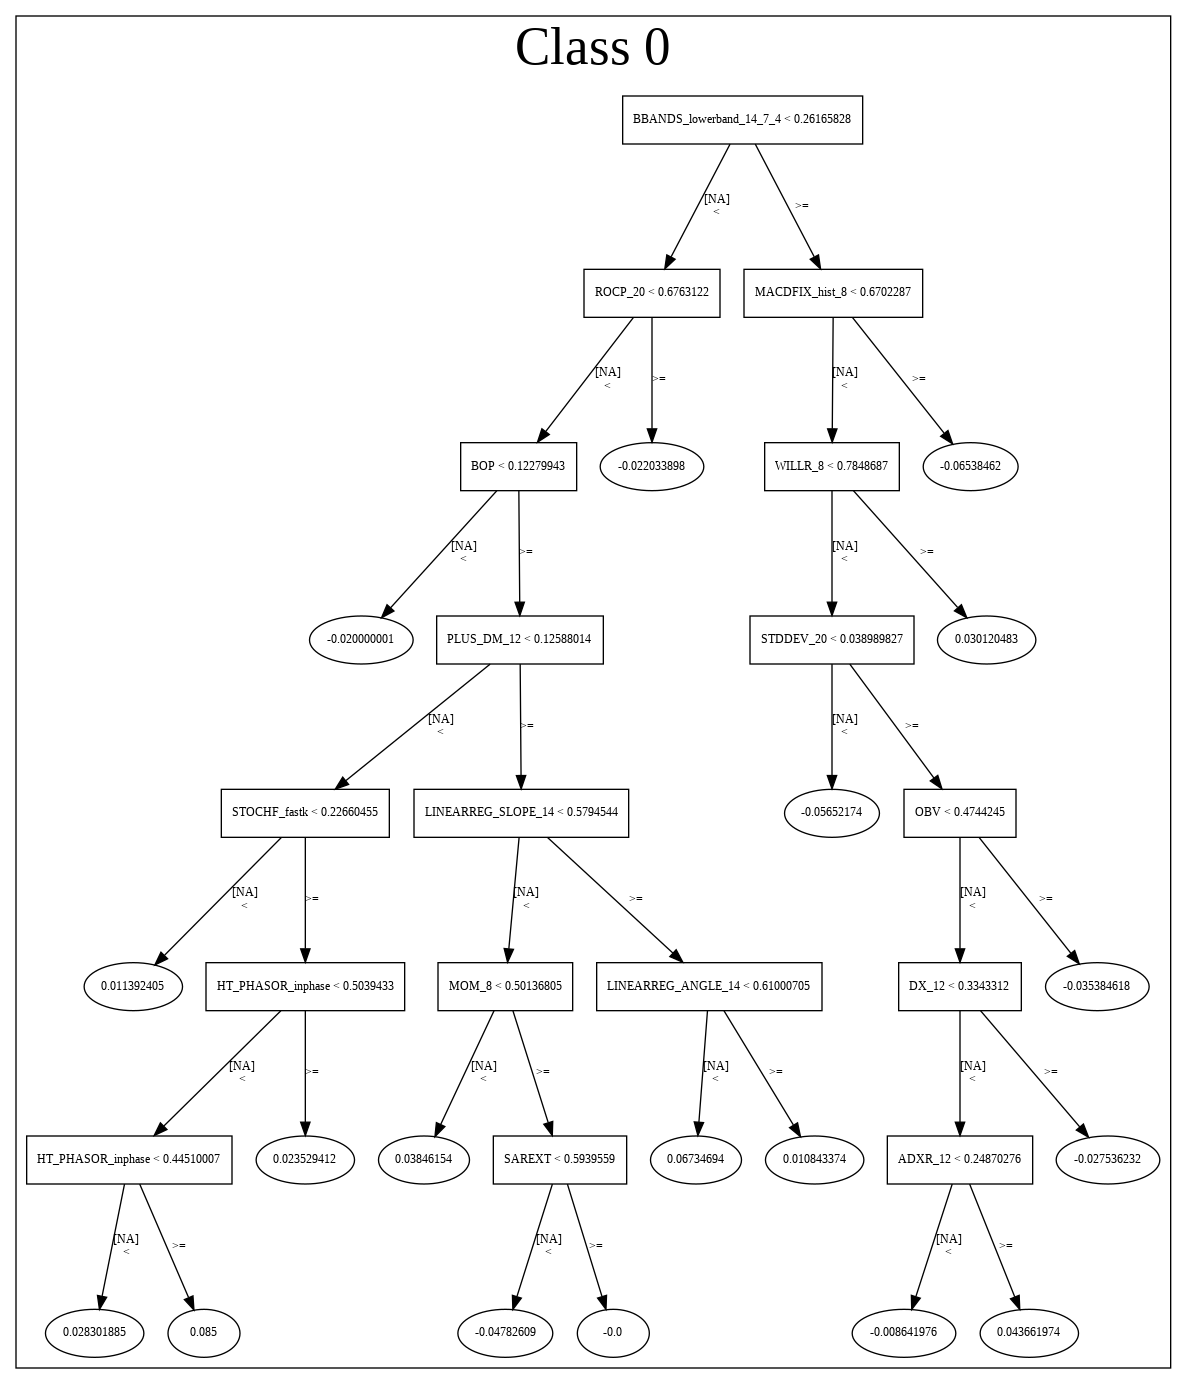

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_174549_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_174549_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CORREL_8',
 'STOCHF_fastk',
 'ADXR_12',
 'ADXR_8',
 'PLUS_DM_30',
 'STOCHRSI_fastk',
 'MA_14_4',
 'ADXR_14',
 'MFI_14',
 'BBANDS_lowerband_14_3_5',
 'PLUS_DM_14',
 'STOCHRSI_fastd',
 'aroonup_14',
 'AROONOSC_24',
 'ATR_20',
 'ROCR100_24',
 'BBANDS_middleband_14_5_4',
 'ATR_8',
 'aroondown_24',
 'ROCR_8',
 'MFI_8',
 'BBANDS_upperband_14_0_2',
 'ROCR100_8',
 'CDLBELTHOLD',
 'TRANGE',
 'TRIX_12',
 'aroonup_12',
 'MACDFIX_hist_20',
 'BBANDS_middleband_20_1_2',
 'BBANDS_lowerband_20_6_5',
 'PLUS_DI_12',
 'DX_14',
 'MOM_20',
 'APO',
 'BBANDS_upperband_24_1_4',
 'MOM_24',
 'ULTOSC',
 'CCI_14',
 'HT_PHASOR_inphase',
 'CCI_12',
 'ROC_30',
 'aroondown_8',
 'WILLR_30',
 'MOM_14',
 'MINUS_DM_20',
 'MFI_30',
 'PLUS_DI_24',
 'MINUS_DI_8',
 'CORREL_12',
 'CCI_24',
 'DX_24',
 'MINUS_DI_24',
 'MACDFIX_hist_8',
 'MINUS_DI_12',
 'BBANDS_upperband_14_5_5',
 'MFI_24',
 'ADOSC',
 'WILLR_20',
 'TRIX_8',
 'CMO_30',
 'MACDFIX_24',
 'VAR_8']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_175750_model_1  0.546811  0.700992              0.484375  0.503842  0.253857

variable  relative_importance  scaled_importance  percentage
0    BBANDS_lowerband_14_3_5             0.007262           1.000000    0.042977
1                    MA_14_4             0.006595           0.908267    0.039035
2    BBANDS_lowerband_20_6_5             0.006467           0.890618    0.038276
3   BBANDS_middleband_14_5_4             0.006103           0.840407    0.036118
4   BBANDS_middleband_20_1_2             0.006013           0.828001    0.035585
..                       ...                  ...                ...         ...
57                    CCI_24             0.000495           0.068196    0.002931
58                    TRANGE             0.000251           0.034595    0.001487
59               aroondown_8             0.000237           0.032574    0.001400
60                aroonup_12             0.000091           0.012501    0.000537
61                     ATR_8             0.000023           0.003165    0.000136

[62 rows x 4 columns]

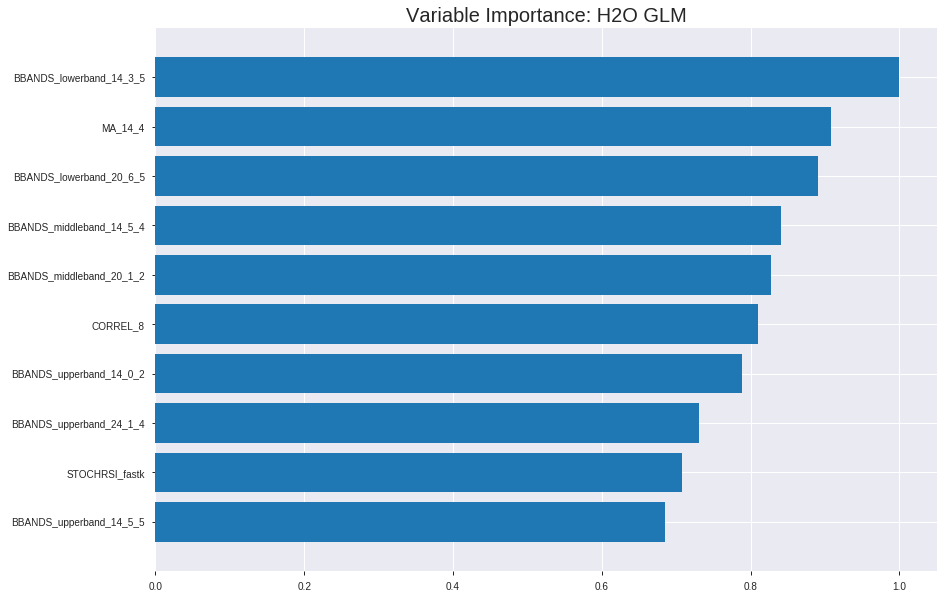

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_175750_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24789180137876773
RMSE: 0.4978873380382029
LogLoss: 0.6889199869651799
Null degrees of freedom: 1752
Residual degrees of freedom: 1690
Null deviance: 2427.133204280672
Residual deviance: 2415.35347429992
AIC: 2541.35347429992
AUC: 0.5629902727794294
pr_auc: 0.5817104846580905
Gini: 0.12598054555885874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4778349103602784: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    835   0.994    (835.0/840.0)
1      0    913   0        (0.0/913.0)
Total  5    1748  0.4763   (835.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477835     0.686208  394
max f2                       0.477835     0.84537   394
max f0point5                 0.499537     0.58462   333
max accuracy                 0.524474     0.551626  168
max precision                0.566885     1         0
max recall                   0.477835     1         394
max specificity              0.566885     1         0
max absolute_mcc             0.529001     0.116998  141
max min_per_class_accuracy   0.519936     0.538883  202
max mean_per_class_accuracy  0.524474     0.556748  168

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.559111           1.60004   1.60004            0.833333         0.56152   0.833333                    0.56152             0.0164294       0.0164294                  60.0037    60.0037
    2        0.0205362                   0.555907           1.3867    1.49337            0.722222         0.557648  0.777778                    0.559584            0.0142388       0.0306681                  38.6698    49.3367
    3        0.0302339                   0.553266           1.46827   1.48532            0.764706         0.5544    0.773585                    0.557921            0.0142388       0.0449069                  46.8269    48.5317
    4        0.040502                    0.550862           0.746684  1.29806            0.388889         0.552263  0.676056                    0.556487            0.00766703      0.0525739                  -25.3316   29.8058
    5        0.0501997                   0.549003           1.46827   1.33094            0.764706         0.549975  0.693182                    0.555229            0.0142388       0.0668127                  46.8269    33.0939
    6        0.100399                    0.543362           1.02548   1.17821            0.534091         0.545696  0.613636                    0.550463            0.0514786       0.118291                   2.54779    17.8209
    7        0.150029                    0.539683           1.0814    1.14619            0.563218         0.54163   0.596958                    0.547541            0.0536692       0.171961                   8.1404     14.6186
    8        0.200228                    0.535389           1.13457   1.14327            0.590909         0.537552  0.595442                    0.545036            0.0569551       0.228916                   13.4571    14.3274
    9        0.300057                    0.529022           1.21786   1.16809            0.634286         0.532258  0.608365                    0.540785            0.121577        0.350493                   21.7856    16.8087
    10       0.399886                    0.523351           0.965508  1.11751            0.502857         0.526125  0.582026                    0.537125            0.0963855       0.446878                   -3.44923   11.7515
    11       0.500285                    0.519816           0.927294  1.07934            0.482955         0.521628  0.562144                    0.534015            0.0930997       0.539978                   -7.27061   7.93405
    12       0.600114                    0.515929           0.910649  1.05128            0.474286         0.517903  0.547529                    0.531335            0.0909091       0.630887                   -8.93506   5.12787
    13       0.699943                    0.511609           0.998423  1.04374            0.52             0.513774  0.543602                    0.52883             0.0996714       0.730559                   -0.157722  4.37402
    14       0.799772                    0.50666            0.932593  1.02987            0.485714         0.50923   0.536377                    0.526384            0.0930997       0.823658                   -6.74073   2.98666
    15       0.899601                    0.500467           0.987451  1.02516            0.514286         0.503927  0.533925                    0.523892            0.0985761       0.922234                   -1.25489   2.51597
    16       1                           0.469684           0.774563  1                  0.403409         0.493313  0.520821                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25277174645197986
RMSE: 0.502764106169066
LogLoss: 0.6987169359988357
Null degrees of freedom: 500
Residual degrees of freedom: 438
Null deviance: 691.6529992083883
Residual deviance: 700.1143698708333
AIC: 826.1143698708333
AUC: 0.5111978664610244
pr_auc: 0.5594344277151615
Gini: 0.022395732922048772
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41534036370904187: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    225  0.9868   (225.0/228.0)
1      0    273  0        (0.0/273.0)
Total  3    498  0.4491   (225.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.41534      0.708171   396
max f2                       0.41534      0.858491   396
max f0point5                 0.41534      0.602649   396
max accuracy                 0.419763     0.550898   394
max precision                0.538379     1          0
max recall                   0.41534      1          396
max specificity              0.538379     1          0
max absolute_mcc             0.41534      0.0849298  396
max min_per_class_accuracy   0.481616     0.494505   190
max mean_per_class_accuracy  0.489806     0.527448   132

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 47.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.535893           0.917582  0.917582           0.5              0.53713   0.5                         0.53713             0.010989        0.010989                   -8.24176   -8.24176
    2        0.0219561                   0.533362           0.734066  0.834166           0.4              0.534335  0.454545                    0.535859            0.00732601      0.018315                   -26.5934   -16.5834
    3        0.0319361                   0.51911            1.83516   1.14698            1                0.526859  0.625                       0.533047            0.018315        0.03663                    83.5165    14.6978
    4        0.0419162                   0.510791           1.1011    1.13605            0.6              0.513121  0.619048                    0.528302            0.010989        0.047619                   10.1099    13.6054
    5        0.0518962                   0.508111           0.734066  1.05875            0.4              0.508747  0.576923                    0.524542            0.00732601      0.0549451                  -26.5934   5.87489
    6        0.101796                    0.503304           1.1011    1.07951            0.6              0.50576   0.588235                    0.515335            0.0549451       0.10989                    10.1099    7.95087
    7        0.151697                    0.499768           1.17451   1.11076            0.64             0.501757  0.605263                    0.510869            0.0586081       0.168498                   17.4505    11.0758
    8        0.201597                    0.496581           0.880879  1.05386            0.48             0.497988  0.574257                    0.50768             0.043956        0.212454                   -11.9121   5.3857
    9        0.301397                    0.491841           1.0644    1.05735            0.58             0.49458   0.576159                    0.503342            0.106227        0.318681                   6.43956    5.73466
    10       0.401198                    0.48578            0.770769  0.986059           0.42             0.488905  0.537313                    0.499751            0.0769231       0.395604                   -22.9231   -1.39413
    11       0.500998                    0.481334           0.990989  0.987041           0.54             0.483384  0.537849                    0.496491            0.0989011       0.494505                   -0.901099  -1.29592
    12       0.600798                    0.475568           1.17451   1.01818            0.64             0.478044  0.554817                    0.493426            0.117216        0.611722                   17.4505    1.81812
    13       0.700599                    0.463607           1.02769   1.01954            0.56             0.471187  0.555556                    0.490258            0.102564        0.714286                   2.76923    1.9536
    14       0.800399                    0.44983            0.807473  0.993094           0.44             0.455823  0.541147                    0.485965            0.0805861       0.794872                   -19.2527   -0.690581
    15       0.9002                      0.44017            1.1378    1.00914            0.62             0.444941  0.549889                    0.481417            0.113553        0.908425                   13.7802    0.91372
    16       1                           0.409739           0.917582  1                  0.5              0.42888   0.54491                 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:57:50  0.000 sec   2            4.3       63            1.37784           1.39743
    2019-08-25 17:57:50  0.015 sec   4            2.7       63            1.37566           1.40821
    2019-08-25 17:57:50  0.031 sec   6            1.6       63            1.37321           1.42222
    2019-08-25 17:57:50  0.045 sec   8            1         63            1.37051           1.43809
    2019-08-25 17:57:50  0.059 sec   10           0.64      63            1.36751           1.45374

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6648648648648648)

('auc', 0.5468114837398373)

('logloss', 0.7009916844083859)

('mean_per_class_error', 0.444899644308943)

('rmse', 0.503841858806118)

('mse', 0.2538566186852041)

glm prediction progress: |████████████████████████████████████████████████| 100%


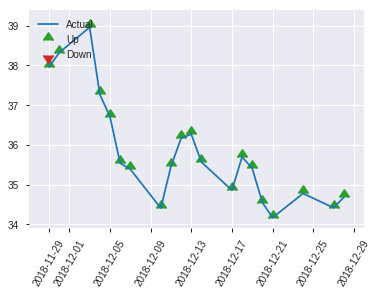


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2538566186852041
RMSE: 0.503841858806118
LogLoss: 0.7009916844083859
Null degrees of freedom: 250
Residual degrees of freedom: 188
Null deviance: 348.8121992937332
Residual deviance: 351.8978255730097
AIC: 477.8978255730097
AUC: 0.5468114837398373
pr_auc: 0.5140421685671439
Gini: 0.09362296747967469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3737163638743202: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    124  0.9688   (124.0/128.0)
1      0    123  0        (0.0/123.0)
Total  4    247  0.494    (124.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373716     0.664865  246
max f2                       0.373716     0.832206  246
max f0point5                 0.389629     0.566779  191
max accuracy                 0.432536     0.557769  73
max precision                0.48298      1         0
max recall                   0.373716     1         246
max specificity              0.48298      1         0
max absolute_mcc             0.389629     0.129917  191
max min_per_class_accuracy   0.413851     0.512195  123
max mean_per_class_accuracy  0.389629     0.5551    191

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 41.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.480621           1.36043   1.36043            0.666667         0.481878  0.666667                    0.481878            0.0162602       0.0162602                  36.0434   36.0434
    2        0.0239044                   0.479424           0.680217  1.02033            0.333333         0.480039  0.5                         0.480958            0.00813008      0.0243902                  -31.9783  2.03252
    3        0.0318725                   0.478702           2.04065   1.27541            1                0.47886   0.625                       0.480434            0.0162602       0.0406504                  104.065   27.5407
    4        0.0438247                   0.477208           0.680217  1.11308            0.333333         0.477992  0.545455                    0.479768            0.00813008      0.0487805                  -31.9783  11.3082
    5        0.0517928                   0.4766             1.02033   1.09881            0.5              0.476835  0.538462                    0.479317            0.00813008      0.0569106                  2.03252   9.88118
    6        0.103586                    0.472531           0.941839  1.02033            0.461538         0.474937  0.5                         0.477127            0.0487805       0.105691                   -5.81614  2.03252
    7        0.151394                    0.455741           0.850271  0.966624           0.416667         0.464346  0.473684                    0.473091            0.0406504       0.146341                   -14.9729  -3.33761
    8        0.203187                    0.445855           1.41276   1.08034            0.692308         0.44933   0.529412                    0.467034            0.0731707       0.219512                   41.2758   8.03443
    9        0.302789                    0.431728           1.30602   1.15458            0.64             0.439309  0.565789                    0.457914            0.130081        0.349593                   30.6016   15.4579
    10       0.40239                     0.421139           0.734634  1.05063            0.36             0.426845  0.514851                    0.450224            0.0731707       0.422764                   -26.5366  5.06319
    11       0.501992                    0.413514           0.897886  1.02033            0.44             0.417276  0.5                         0.443687            0.0894309       0.512195                   -10.2114  2.03252
    12       0.601594                    0.405543           1.14276   1.0406             0.56             0.409853  0.509934                    0.438085            0.113821        0.626016                   14.2764   4.05966
    13       0.701195                    0.395336           1.22439   1.0667             0.6              0.400339  0.522727                    0.432723            0.121951        0.747967                   22.439    6.67036
    14       0.800797                    0.38836            0.81626   1.03555            0.4              0.391034  0.507463                    0.427538            0.0813008       0.829268                   -18.374   3.55539
    15       0.900398                    0.381343           1.06114   1.03838            0.52             0.384765  0.50885                     0.422807            0.105691        0.934959                   6.11382   3.83841
    16       1                           0.36562            0.653008  1                  0.32             0.377029  0.49004                     0.418247        

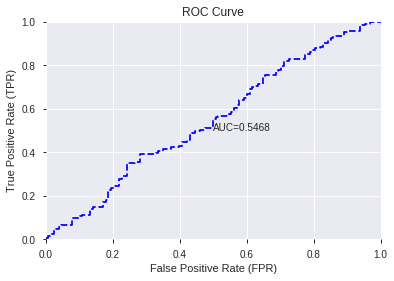

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


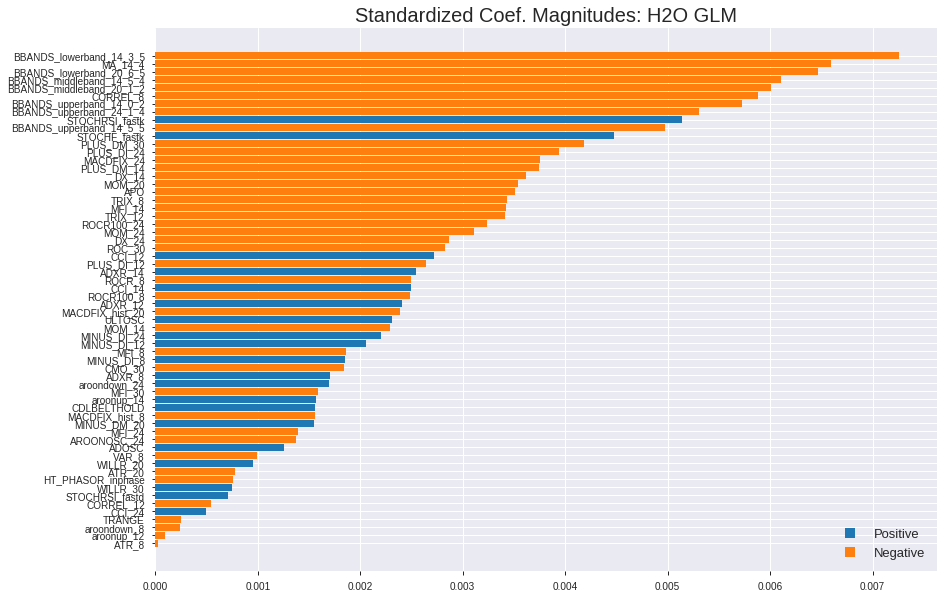

'log_likelihood'
--2019-08-25 17:58:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


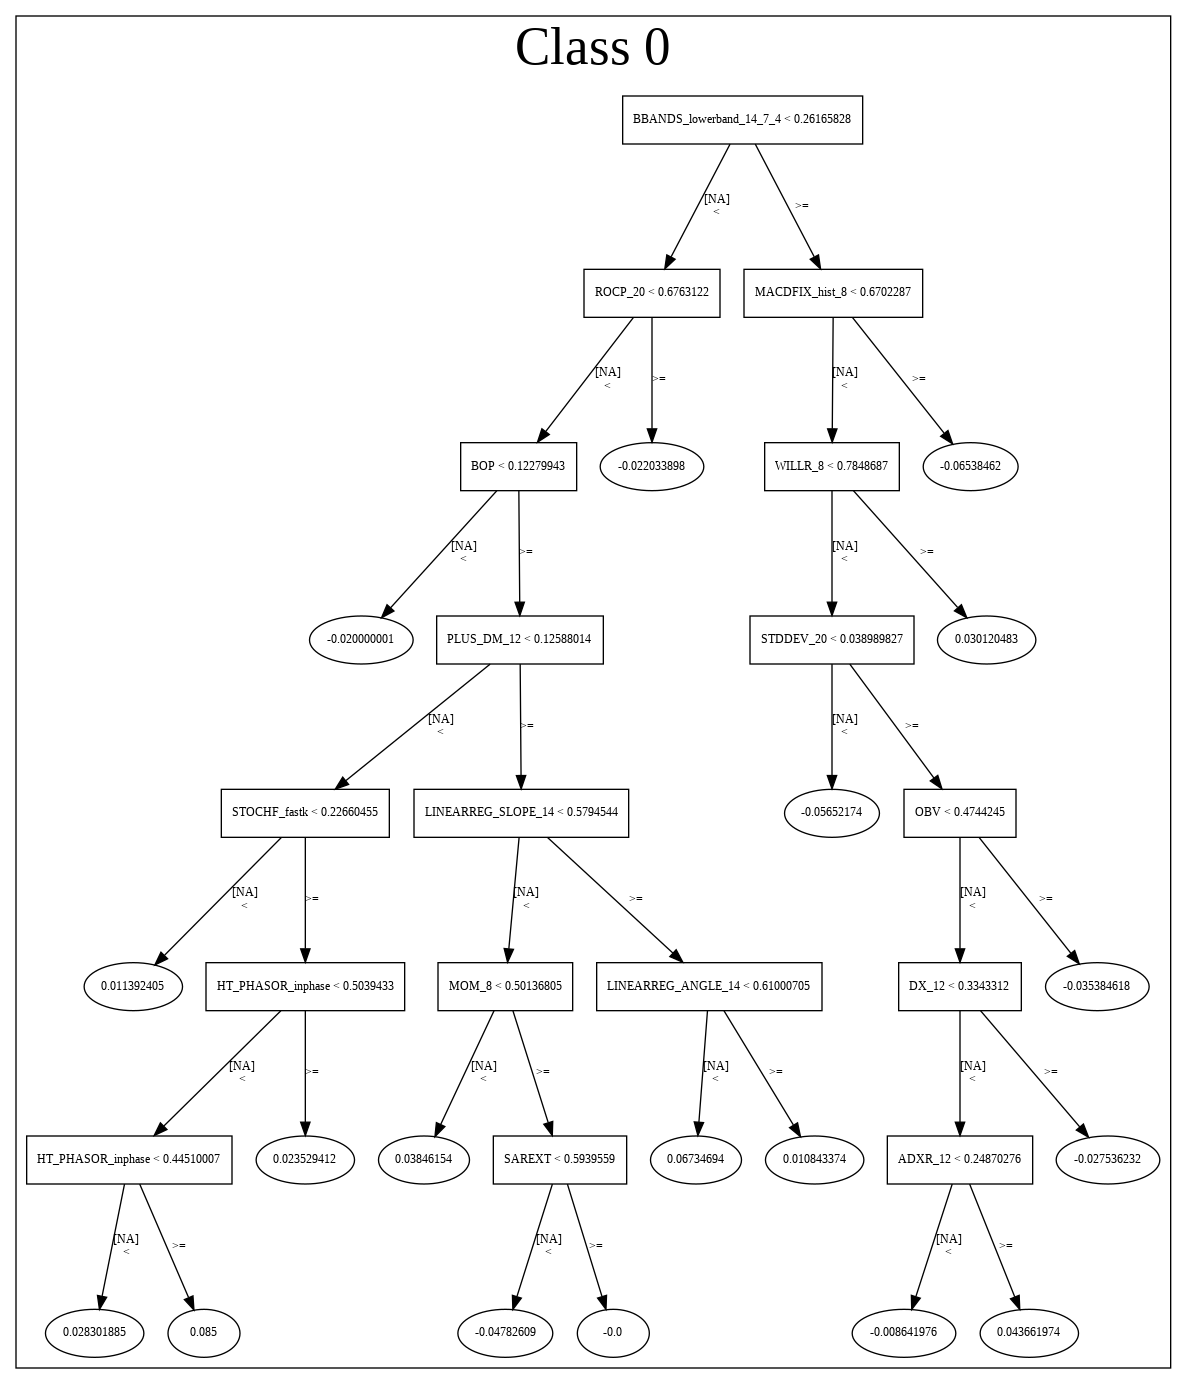

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_175750_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_175750_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BBANDS_lowerband_14_3_5',
 'MA_14_4',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_middleband_14_5_4',
 'BBANDS_middleband_20_1_2',
 'CORREL_8',
 'BBANDS_upperband_14_0_2',
 'BBANDS_upperband_24_1_4',
 'STOCHRSI_fastk',
 'BBANDS_upperband_14_5_5',
 'STOCHF_fastk',
 'PLUS_DM_30',
 'PLUS_DI_24',
 'MACDFIX_24',
 'PLUS_DM_14',
 'DX_14',
 'MOM_20',
 'APO',
 'TRIX_8',
 'MFI_14',
 'TRIX_12',
 'ROCR100_24',
 'MOM_24',
 'DX_24',
 'ROC_30',
 'CCI_12',
 'PLUS_DI_12',
 'ADXR_14',
 'ROCR_8',
 'CCI_14',
 'ROCR100_8',
 'ADXR_12',
 'MACDFIX_hist_20',
 'ULTOSC',
 'MOM_14',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'MFI_8',
 'MINUS_DI_8',
 'CMO_30',
 'ADXR_8',
 'aroondown_24',
 'MFI_30',
 'aroonup_14',
 'CDLBELTHOLD',
 'MACDFIX_hist_8',
 'MINUS_DM_20',
 'MFI_24',
 'AROONOSC_24',
 'ADOSC',
 'VAR_8',
 'WILLR_20',
 'ATR_20',
 'HT_PHASOR_inphase',
 'WILLR_30',
 'STOCHRSI_fastd',
 'CORREL_12',
 'CCI_24',
 'TRANGE',
 'aroondown_8',
 'aroonup_12',
 'ATR_8']

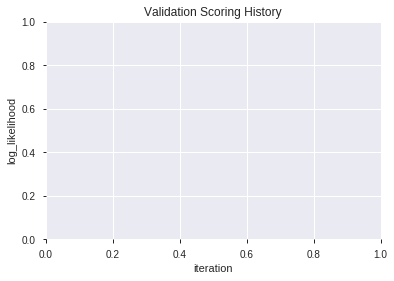

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190825_175856  0.561674  0.708887              0.500000  0.506397  0.256438
1  XGBoost_grid_1_AutoML_20190825_175856_model_4  0.553671  0.692448              0.496094  0.499561  0.249562
2  XGBoost_grid_1_AutoML_20190825_175856_model_5  0.551321  0.714999              0.496094  0.509334  0.259421
3  XGBoost_grid_1_AutoML_20190825_175856_model_6  0.550813  0.711069              0.480786  0.507285  0.257338
4               XGBoost_3_AutoML_20190825_175856  0.543953  0.724492              0.496094  0.512864  0.263030
5  XGBoost_grid_1_AutoML_20190825_175856_model_2  0.533346  0.695971              0.500000  0.501273  0.251275
6               XGBoost_2_AutoML_20190825_175856  0.531949  0.708279              0.500000  0.506816  0.256863
7  XGBoost_grid_1_AutoML_20190825_175856_model_1  0.530869  0.725590              0.496094  0.513491  0.263673
8  XGBoost_grid_1_AutoML_20190825_175856_model_3  0.522929  0.714425              0.488599  0.509657  0.259751
9  XGBoost_grid_1_AutoML_20190825_175856_model_7  0.522040  0.729396              0.492188  0.515296  0.265530

variable  relative_importance  scaled_importance  percentage
0                  CORREL_8           287.602997           1.000000    0.036801
1            STOCHRSI_fastd           244.847748           0.851339    0.031330
2                    MFI_14           228.627350           0.794941    0.029255
3                    MFI_30           216.274246           0.751989    0.027674
4                 CORREL_12           212.491913           0.738838    0.027190
..                      ...                  ...                ...         ...
57                ROCR100_8            54.066452           0.187990    0.006918
58              aroondown_8            53.060921           0.184494    0.006790
59  BBANDS_upperband_24_1_4            47.687489           0.165810    0.006102
60               aroonup_14            38.593929           0.134192    0.004938
61              CDLBELTHOLD            16.533470           0.057487    0.002116

[62 rows x 4 columns]

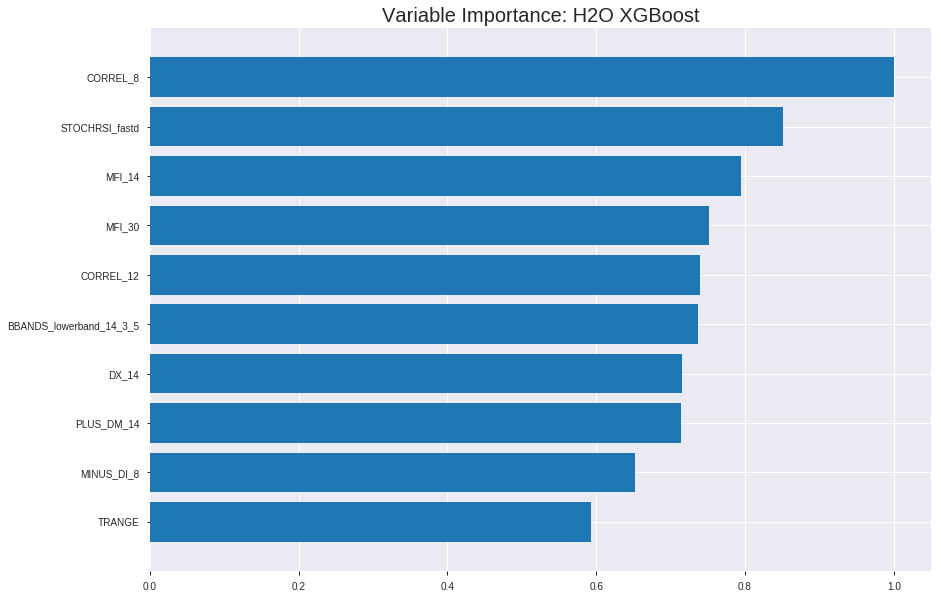

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190825_175856


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15056831727637077
RMSE: 0.38803133543100715
LogLoss: 0.4846094491952862
Mean Per-Class Error: 0.09502686068951127
AUC: 0.9633944870390654
pr_auc: 0.9674357496926951
Gini: 0.9267889740781308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5099470416704813: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      749  91   0.1083   (91.0/840.0)
1      78   835  0.0854   (78.0/913.0)
Total  827  926  0.0964   (169.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509947     0.908102  210
max f2                       0.443068     0.929259  254
max f0point5                 0.550922     0.927112  181
max accuracy                 0.531343     0.903594  194
max precision                0.852096     1         0
max recall                   0.300121     1         352
max specificity              0.852096     1         0
max absolute_mcc             0.531343     0.809672  194
max min_per_class_accuracy   0.515385     0.901424  206
max mean_per_class_accuracy  0.531343     0.904973  194

Gains/Lift Table: Avg response rate: 52.08 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.794759           1.92004    1.92004            1                0.812187  1                           0.812187            0.0197152       0.0197152                  92.0044   92.0044
    2        0.0205362                   0.781552           1.92004    1.92004            1                0.786184  1                           0.799186            0.0197152       0.0394304                  92.0044   92.0044
    3        0.0302339                   0.769525           1.92004    1.92004            1                0.775259  1                           0.791511            0.0186199       0.0580504                  92.0044   92.0044
    4        0.040502                    0.76297            1.92004    1.92004            1                0.766819  1                           0.785251            0.0197152       0.0777656                  92.0044   92.0044
    5        0.0501997                   0.757016           1.92004    1.92004            1                0.75959   1                           0.780294            0.0186199       0.0963855                  92.0044   92.0044
    6        0.100399                    0.726904           1.92004    1.92004            1                0.740699  1                           0.760497            0.0963855       0.192771                   92.0044   92.0044
    7        0.150029                    0.701725           1.92004    1.92004            1                0.714188  1                           0.745178            0.0952903       0.288061                   92.0044   92.0044
    8        0.200228                    0.677571           1.87641    1.9091             0.977273         0.689392  0.994302                    0.731192            0.094195        0.382256                   87.6406   90.9103
    9        0.300057                    0.625961           1.87616    1.89814            0.977143         0.651957  0.988593                    0.70483             0.187295        0.569551                   87.6157   89.8142
    10       0.399886                    0.576052           1.75547    1.86252            0.914286         0.602409  0.970043                    0.679262            0.175246        0.744797                   75.5469   86.2525
    11       0.500285                    0.52412            1.4073     1.77117            0.732955         0.548568  0.922463                    0.653034            0.141292        0.88609                    40.7305   77.1169
    12       0.600114                    0.464334           0.669272   1.58787            0.348571         0.49467   0.826996                    0.62669             0.0668127       0.952903                   -33.0728  58.7869
    13       0.699943                    0.41573            0.285264   1.40209            0.148571         0.439081  0.730236                    0.599932            0.0284775       0.98138                    -71.4736  40.2086
    14       0.799772                    0.367842           0.13166    1.24351            0.0685714        0.39164   0.647646                    0.573933            0.0131435       0.994524                   -86.834   24.3509
    15       0.899601                    0.313387           0.0438867  1.11039            0.0228571        0.342199  0.578313                    0.548217            0.00438116      0.998905                   -95.6113  11.0387
    16       1                           0.171902           0.0109093  1                  0.00568182       0.273283  0.520821                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2683183308659241
RMSE: 0.517994527833957
LogLoss: 0.73304679785116
Mean Per-Class Error: 0.4315596684017736
AUC: 0.5775335775335776
pr_auc: 0.6146948307270033
Gini: 0.15506715506715518
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22735875844955444: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   218  0.9561   (218.0/228.0)
1      2    271  0.0073   (2.0/273.0)
Total  12   489  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.227359     0.711286  388
max f2                       0.202518     0.857951  397
max f0point5                 0.303749     0.61252   312
max accuracy                 0.303749     0.572854  312
max precision                0.591032     0.9       9
max recall                   0.202518     1         397
max specificity              0.722956     0.995614  0
max absolute_mcc             0.421956     0.142423  150
max min_per_class_accuracy   0.386912     0.56044   197
max mean_per_class_accuracy  0.421956     0.56844   150

Gains/Lift Table: Avg response rate: 54.49 %, avg score: 38.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.618815           1.5293    1.5293             0.833333         0.656945  0.833333                    0.656945            0.018315        0.018315                   52.9304    52.9304
    2        0.0219561                   0.588204           1.83516   1.66833            1                0.60171   0.909091                    0.631838            0.018315        0.03663                    83.5165    66.8332
    3        0.0319361                   0.568727           1.1011    1.49107            0.6              0.576295  0.8125                      0.614481            0.010989        0.047619                   10.1099    49.1071
    4        0.0419162                   0.551735           0.734066  1.31083            0.4              0.556554  0.714286                    0.600689            0.00732601      0.0549451                  -26.5934   31.0832
    5        0.0518962                   0.544183           1.1011    1.2705             0.6              0.547316  0.692308                    0.590425            0.010989        0.0659341                  10.1099    27.0499
    6        0.101796                    0.514842           1.1011    1.18746            0.6              0.529091  0.647059                    0.560359            0.0549451       0.120879                   10.1099    18.746
    7        0.151697                    0.487722           1.32132   1.23149            0.72             0.502516  0.671053                    0.541332            0.0659341       0.186813                   32.1319    23.1492
    8        0.201597                    0.472668           1.1011    1.19922            0.6              0.480364  0.653465                    0.526241            0.0549451       0.241758                   10.1099    19.9217
    9        0.301397                    0.43415            1.0644    1.15457            0.58             0.452987  0.629139                    0.501984            0.106227        0.347985                   6.43956    15.4574
    10       0.401198                    0.412261           1.0644    1.13214            0.58             0.422974  0.616915                    0.48233             0.106227        0.454212                   6.43956    13.2141
    11       0.500998                    0.388087           1.02769   1.11133            0.56             0.400056  0.605578                    0.465941            0.102564        0.556777                   2.76923    11.1335
    12       0.600798                    0.362902           0.844176  1.06696            0.46             0.374137  0.581395                    0.450691            0.0842491       0.641026                   -15.5824   6.69563
    13       0.700599                    0.332345           0.917582  1.04568            0.5              0.348098  0.569801                    0.436077            0.0915751       0.732601                   -8.24176   4.5678
    14       0.800399                    0.30152            0.990989  1.03886            0.54             0.314945  0.566085                    0.420973            0.0989011       0.831502                   -0.901099  3.88589
    15       0.9002                      0.262685           0.954286  1.02948            0.52             0.281278  0.560976                    0.405486            0.0952381       0.92674                    -4.57143   2.94827
    16       1                           0.180602           0.734066  1                  0.4              0.238017  0.54491                     0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:58:57  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.479179                         0.5                0.693147              0.5               0                    1                  0.45509
    2019-08-25 17:58:57  0.110 sec   5                  0.483172         0.659957            0.809457        0.817576           1.92004          0.288078                         0.501996           0.697162              0.545788          0.579681             1.22344            0.45509
    2019-08-25 17:58:57  0.174 sec   10                 0.469642         0.633865            0.862804        0.862995           1.81337          0.232744                         0.503772           0.700781              0.557218          0.592816             1.5293             0.439122
    2019-08-25 17:58:57  0.242 sec   15                 0.456873         0.609628            0.890202        0.898222           1.92004          0.196805                         0.507832           0.709208              0.549916          0.572608             1.22344            0.449102
    2019-08-25 17:58:57  0.324 sec   20                 0.444606         0.586702            0.912032        0.919568           1.92004          0.155733                         0.510439           0.714986              0.548559          0.579646             0.917582           0.447106
    2019-08-25 17:58:57  0.391 sec   25                 0.433261         0.565779            0.927625        0.933499           1.92004          0.146606                         0.511006           0.716371              0.552897          0.5933               1.5293             0.449102
    2019-08-25 17:58:57  0.461 sec   30                 0.422756         0.546658            0.938536        0.944666           1.92004          0.130633                         0.511547           0.717795              0.564488          0.60039              1.5293             0.449102
    2019-08-25 17:58:57  0.537 sec   35                 0.412614         0.52834             0.948602        0.954168           1.92004          0.119224                         0.51402            0.723539              0.572457          0.610563             1.5293             0.449102
    2019-08-25 17:58:57  0.604 sec   40                 0.404104         0.513085            0.953661        0.958431           1.92004          0.114661                         0.511619           0.71832               0.575477          0.615652             1.5293             0.421158
    2019-08-25 17:58:57  0.674 sec   45                 0.396859         0.500042            0.956635        0.960976           1.92004          0.105533                         0.516154           0.728652              0.57706           0.617745             1.5293             0.44511
    2019-08-25 17:58:58  0.752 sec   50                 0.388031         0.484609            0.963394        0.967436           1.92004          0.0964062                        0.517995           0.733047              0.577534          0.614695             1.5293             0.439122

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CORREL_8                 287.6029968261719      1.0                  0.03680110235608215
STOCHRSI_fastd           244.84774780273438     0.8513393480065894   0.03133022648575074
MFI_14                   228.62734985351562     0.7949407773094197   0.02925469691278746
MFI_30                   216.2742462158203      0.7519888478301814   0.02767401855963079
CORREL_12                212.49191284179688     0.7388376170858457   0.027190038770900038
---                      ---                    ---                  ---
ROCR100_8                54.06645202636719      0.1879898770979953   0.006918234708990629
aroondown_8              53.06092071533203      0.18449362941583747  0.006789568940177323
BBANDS_upperband_24_1_4  47.6874885559082       0.16581012396310552  0.006101995343640916
aroonup_14               38.593929290771484     0.1341916799083209   0.004938401747640729
CDLBELTHOLD              16.533470153808594     0.05748712752044609  0.0021155896640370833


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6577540106951871)

('auc', 0.5616742886178862)

('logloss', 0.7088873816479973)

('mean_per_class_error', 0.4251778455284553)

('rmse', 0.5063972816405601)

('mse', 0.2564382068529487)

xgboost prediction progress: |████████████████████████████████████████████| 100%


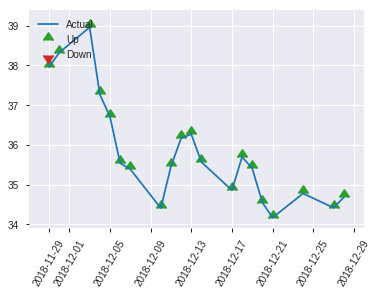


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2564382068529487
RMSE: 0.5063972816405601
LogLoss: 0.7088873816479973
Mean Per-Class Error: 0.4251778455284553
AUC: 0.5616742886178862
pr_auc: 0.581412740595769
Gini: 0.1233485772357723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19522178173065186: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    123  0        (0.0/123.0)
Total  0    251  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.195222     0.657754  250
max f2                       0.195222     0.827725  250
max f0point5                 0.432646     0.553236  88
max accuracy                 0.461436     0.577689  60
max precision                0.601446     1         0
max recall                   0.195222     1         250
max specificity              0.601446     1         0
max absolute_mcc             0.550229     0.185095  7
max min_per_class_accuracy   0.397824     0.515625  125
max mean_per_class_accuracy  0.432646     0.574822  88

Gains/Lift Table: Avg response rate: 49.00 %, avg score: 39.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.580034           2.04065   2.04065            1                0.594122  1                           0.594122            0.0243902       0.0243902                  104.065   104.065
    2        0.0239044                   0.563448           2.04065   2.04065            1                0.567528  1                           0.580825            0.0243902       0.0487805                  104.065   104.065
    3        0.0318725                   0.549739           2.04065   2.04065            1                0.555824  1                           0.574575            0.0162602       0.0650407                  104.065   104.065
    4        0.0438247                   0.540803           0.680217  1.66962            0.333333         0.545049  0.818182                    0.566522            0.00813008      0.0731707                  -31.9783  66.9623
    5        0.0517928                   0.537381           1.02033   1.56973            0.5              0.539433  0.769231                    0.562355            0.00813008      0.0813008                  2.03252   56.9731
    6        0.103586                    0.503915           1.09881   1.33427            0.538462         0.521752  0.653846                    0.542053            0.0569106       0.138211                   9.88118   33.4271
    7        0.151394                    0.492239           1.36043   1.34253            0.666667         0.498008  0.657895                    0.528144            0.0650407       0.203252                   36.0434   34.2533
    8        0.203187                    0.468537           1.25578   1.32042            0.615385         0.477019  0.647059                    0.515112            0.0650407       0.268293                   25.5785   32.0421
    9        0.302789                    0.447149           0.81626   1.15458            0.4              0.45768   0.565789                    0.49622             0.0813008       0.349593                   -18.374   15.4579
    10       0.40239                     0.419199           1.06114   1.13145            0.52             0.433901  0.554455                    0.480795            0.105691        0.455285                   6.11382   13.145
    11       0.501992                    0.397824           0.653008  1.03652            0.32             0.409135  0.507937                    0.466576            0.0650407       0.520325                   -34.6992  3.65208
    12       0.601594                    0.375049           1.06114   1.0406             0.52             0.387401  0.509934                    0.453468            0.105691        0.626016                   6.11382   4.05966
    13       0.701195                    0.345659           0.979512  1.03192            0.48             0.361719  0.505682                    0.440435            0.097561        0.723577                   -2.04878  3.19198
    14       0.800797                    0.325469           0.81626   1.0051             0.4              0.335322  0.492537                    0.427361            0.0813008       0.804878                   -18.374   0.509647
    15       0.900398                    0.276833           1.06114   1.0113             0.52             0.301702  0.495575                    0.413461            0.105691        0.910569                   6.11382   1.12958
    16       1                           0.195222           0.897886  1                  0.44             0.237194  0.49004                     0.395905         

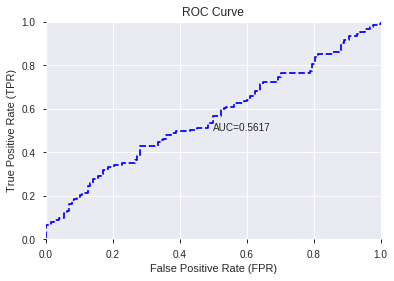

This function is available for GLM models only


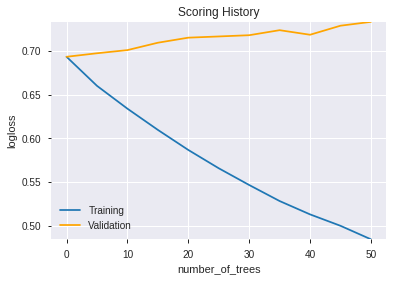

--2019-08-25 17:59:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

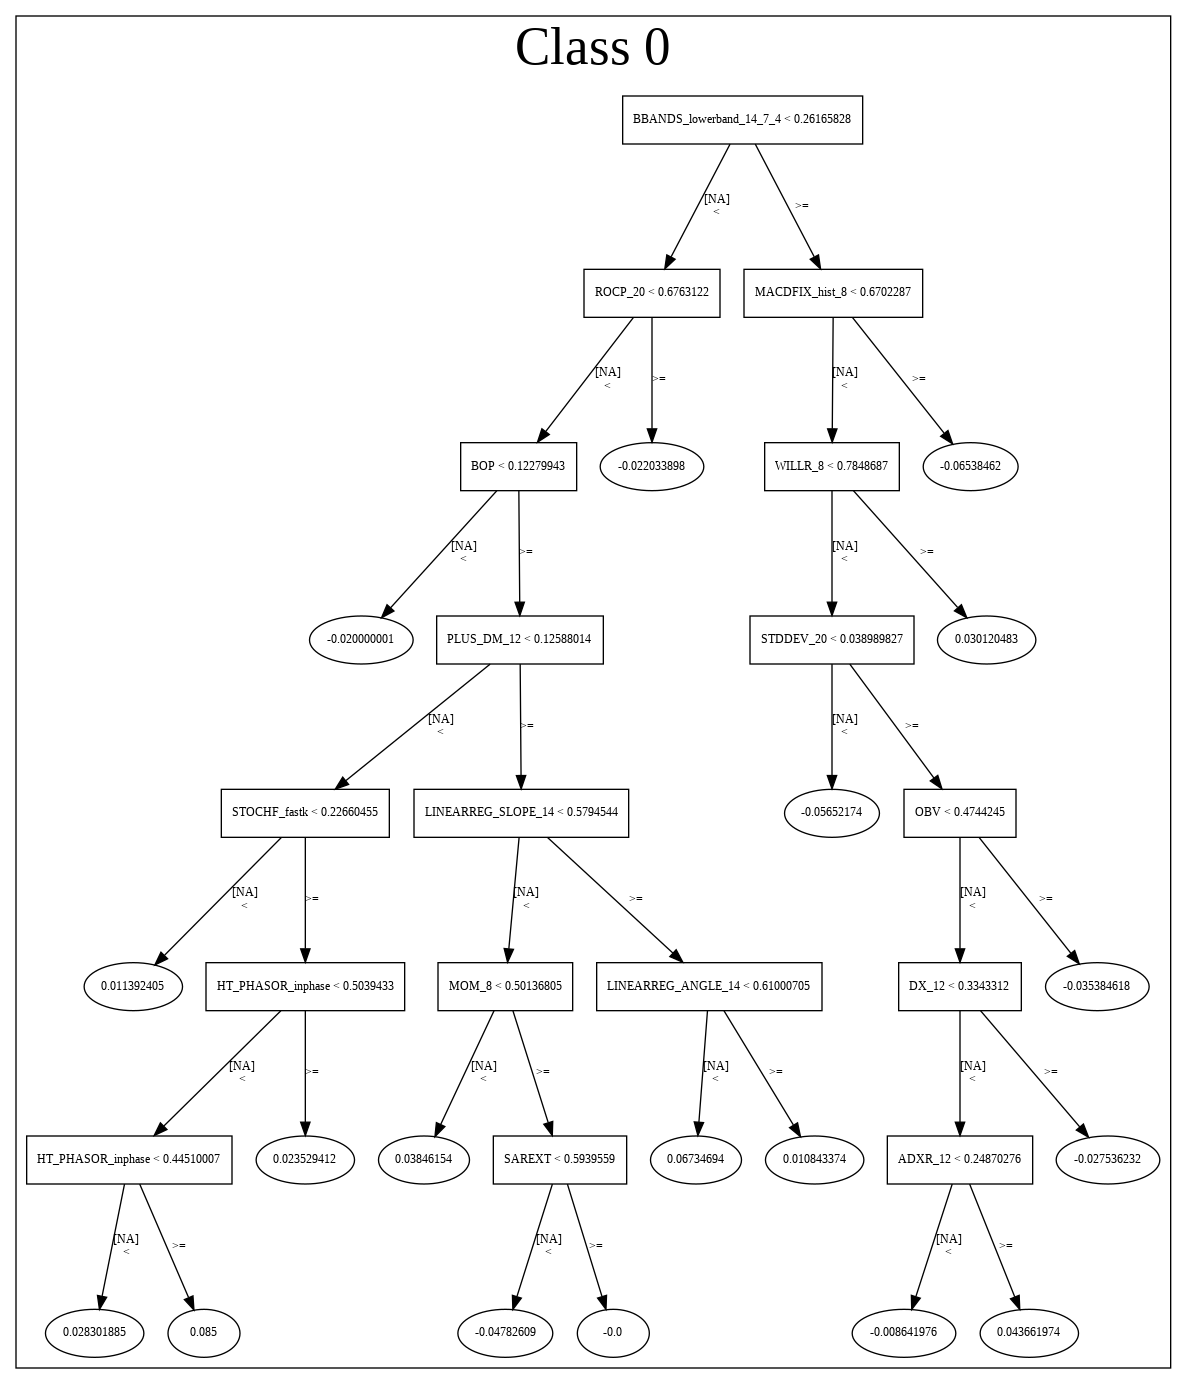

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190825_175856',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190825_175856',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_ada5',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_ada5',
   'ty

['CORREL_8',
 'STOCHRSI_fastd',
 'MFI_14',
 'MFI_30',
 'CORREL_12',
 'BBANDS_lowerband_14_3_5',
 'DX_14',
 'PLUS_DM_14',
 'MINUS_DI_8',
 'TRANGE',
 'MACDFIX_hist_20',
 'HT_PHASOR_inphase',
 'MACDFIX_hist_8',
 'STOCHRSI_fastk',
 'ROCR_8',
 'ULTOSC',
 'ADOSC',
 'MOM_20',
 'BBANDS_lowerband_20_6_5',
 'ADXR_8',
 'CCI_12',
 'ROC_30',
 'STOCHF_fastk',
 'VAR_8',
 'MFI_8',
 'MA_14_4',
 'TRIX_8',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'PLUS_DM_30',
 'MINUS_DM_20',
 'DX_24',
 'MFI_24',
 'CCI_14',
 'ATR_8',
 'MOM_24',
 'PLUS_DI_24',
 'ADXR_12',
 'MOM_14',
 'ADXR_14',
 'BBANDS_upperband_14_5_5',
 'BBANDS_middleband_20_1_2',
 'WILLR_30',
 'BBANDS_middleband_14_5_4',
 'MACDFIX_24',
 'WILLR_20',
 'ROCR100_24',
 'APO',
 'aroondown_24',
 'BBANDS_upperband_14_0_2',
 'CMO_30',
 'ATR_20',
 'AROONOSC_24',
 'PLUS_DI_12',
 'CCI_24',
 'TRIX_12',
 'aroonup_12',
 'ROCR100_8',
 'aroondown_8',
 'BBANDS_upperband_24_1_4',
 'aroonup_14',
 'CDLBELTHOLD']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.594
GLM             0.602
XGBoost         0.578
dtype: float64

DeepLearning    GLM  XGBoost
All          0.490  0.490    0.562
DLF          0.582  0.602    0.578
Fwe          0.490  0.490    0.562
RFE          0.594  0.558    0.578
XGBF         0.586  0.602    0.578





F1


DeepLearning    0.675
GLM             0.673
XGBoost         0.682
dtype: float64

DeepLearning    GLM  XGBoost
All          0.658  0.658    0.663
DLF          0.675  0.673    0.682
Fwe          0.658  0.658    0.663
RFE          0.659  0.665    0.658
XGBF         0.667  0.673    0.682





auc


DeepLearning    0.579
GLM             0.591
XGBoost         0.579
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.568
DLF          0.579  0.591    0.579
Fwe          0.500  0.500    0.568
RFE          0.547  0.547    0.562
XGBF         0.569  0.591    0.579





logloss


DeepLearning    17.613
GLM             16.925
XGBoost          0.709
dtype: float64

DeepLearning     GLM  XGBoost
All         16.925  16.925    0.709
DLF          0.692   0.690    0.682
Fwe         17.613  16.925    0.709
RFE          0.692   0.701    0.709
XGBF         0.716   0.690    0.682





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.437
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.437
DLF          0.415  0.394    0.416
Fwe          0.500  0.500    0.437
RFE          0.406  0.445    0.425
XGBF         0.410  0.394    0.416





rmse


DeepLearning    0.714
GLM             0.700
XGBoost         0.507
dtype: float64

DeepLearning    GLM  XGBoost
All          0.700  0.700    0.507
DLF          0.499  0.499    0.495
Fwe          0.714  0.700    0.507
RFE          0.499  0.504    0.506
XGBF         0.507  0.499    0.495





mse


DeepLearning    0.510
GLM             0.490
XGBoost         0.257
dtype: float64

DeepLearning    GLM  XGBoost
All          0.490  0.490    0.257
DLF          0.249  0.249    0.245
Fwe          0.510  0.490    0.257
RFE          0.249  0.254    0.256
XGBF         0.257  0.249    0.245

{'F1':       DeepLearning    GLM  XGBoost
 All          0.658    NaN      NaN
 DLF          0.675    NaN      NaN
 DLF            NaN  0.673      NaN
 DLF            NaN    NaN    0.682
 All            NaN  0.658      NaN
 All            NaN    NaN    0.663
 XGBF         0.667    NaN      NaN
 XGBF           NaN  0.673      NaN
 XGBF           NaN    NaN    0.682
 Fwe          0.658    NaN      NaN
 Fwe            NaN  0.658      NaN
 Fwe            NaN    NaN    0.663
 RFE          0.659    NaN      NaN
 RFE            NaN  0.665      NaN
 RFE            NaN    NaN    0.658,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.490    NaN      NaN
 DLF          0.582    NaN      NaN
 DLF            NaN  0.602      NaN
 DLF            NaN    NaN    0.578
 All            NaN  0.490      NaN
 All            NaN    NaN    0.562
 XGBF         0.586    NaN      NaN
 XGBF           NaN  0.602      NaN
 XGBF           NaN    NaN    0.578
 Fwe          0.490    NaN      NaN
 Fwe     